In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## !! CHANGE ME !! ##
from suite2p.io import lbm as lbmio
from suite2p.suite3d import utils
from suite2p.suite3d.job import Job
from suite2p.suite3d import ui


os.chdir('/home/ali/packages/s2p-lbm/')
from utils import tiff_utils as tfu

In [4]:
## Find all the tiffiles in the tif path
tif_path = r'Y:\\runs\\Coconut'
tifs = tfu.get_tif_paths(tif_path)

FileNotFoundError: [Errno 2] No such file or directory: 'Y:\\\\runs\\\\Coconut'

In [4]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 0.1
}

In [5]:
# Create the job
job = Job('Y:\\runs\\Coconut','Coconut-Demo', tifs = tifs,
          params=params, create=True, overwrite=False, verbosity = 3)

   Found and loaded params from Y:\runs\Coconut\s3d-Coconut-Demo\params.npy


In [38]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# use all of the frames in the loaded init files 
# if your files are really big, set this to <500 total
job.params['init_n_frames'] = None

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None

In [7]:
job.run_init_pass()

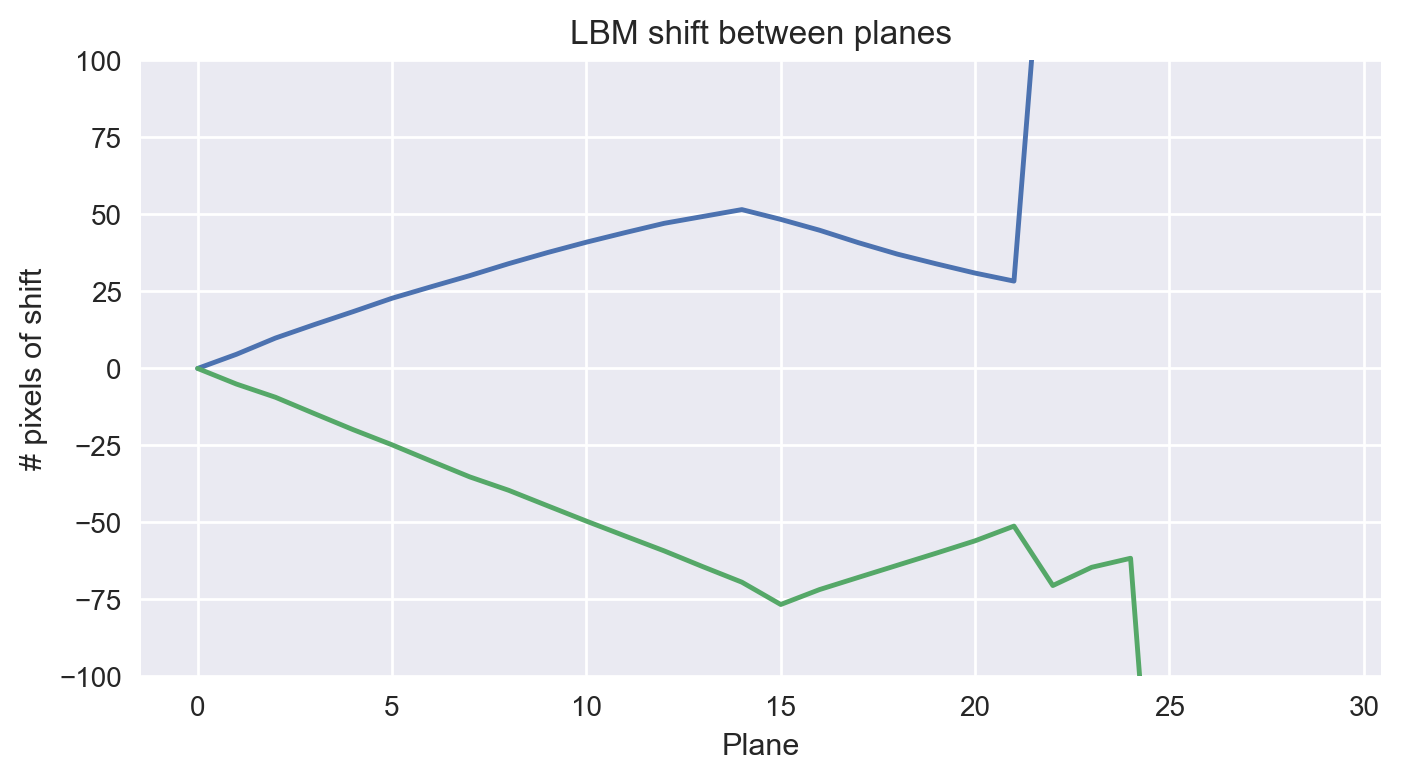

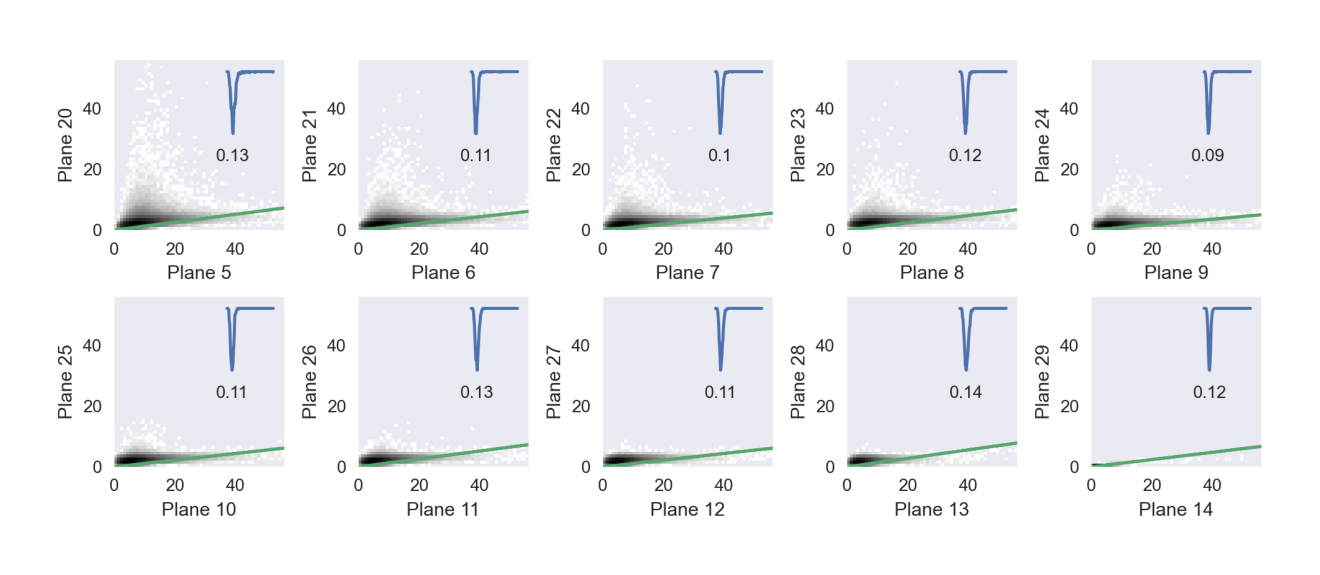

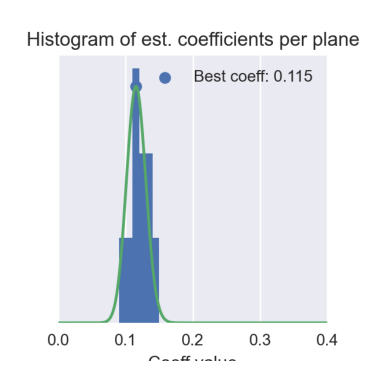

In [115]:
job.show_summary_plots()

In [10]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100
# FUSING: fuse the strips from the FOV into one image
# this is the number of pixels to skip between pixels, 13 makes it look relatively smooth
job.params['n_skip'] = 13
# should only fuse files where the plane_shifts look good, otherwise you might get an error
job.params['fuse_crop'] = ((0,22), (0,584), (0,584))

In [13]:
job.register()
job.fuse_registered_movie()

In [128]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:1000].mean(axis=1).compute()

In [8]:
job.params['n_svd_comp'] = 500
job.params['svd_crop'] = ((0,22), (55,584), (0, 460))
job.params['svd_block_shape'] = (4,200,200)
job.params['svd_block_overlaps'] = (2,100,100)
svd_dir_tag = 'svd_cropped_2'

In [73]:
job.make_new_dir(svd_dir_tag)
svd_info = job.svd_decompose_movie(svd_dir_tag, run_svd=True)

      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2 with tag svd_cropped_2
   Saved a copy of params at Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2
   Updated main params file
   Cropped to size (22, 9860, 529, 460)
   Time-cropped to size (22, 9860, 529, 460)
   Saved a copy of params at Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2
   Updated main params file
200 blocks with overlap (54 without, 3.70x increase)
   Will compute SVD in 200 blocks in a grid shaped (10, 5, 4)
   Batching 4 blocks together, for a total of 50 batches. Pix chunksize: 160000
   Saving SVD blocks in Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2\blocks
Starting with batch 0
      Starting batch 1 / 50, blocks 0 - 4
      Sending batch 1 to dask
      Dask completed in 169.873 sec
      Saving svd_info to Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2\svd_info.npy
   Batch 1 completed in 170.135
   Estimated time remaining for 49 batches: 02h18m56s
      Starting batch 2 / 50, blocks 4 - 8
     

      Sending batch 28 to dask
      Dask completed in 158.645 sec
      Saving svd_info to Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2\svd_info.npy
   Batch 28 completed in 159.383
   Estimated time remaining for 22 batches: 00h58m01s
      Starting batch 29 / 50, blocks 112 - 116
      Sending batch 29 to dask
      Dask completed in 156.951 sec
      Saving svd_info to Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2\svd_info.npy
   Batch 29 completed in 157.666
   Estimated time remaining for 21 batches: 00h55m20s
      Starting batch 30 / 50, blocks 116 - 120
      Sending batch 30 to dask
      Dask completed in 151.361 sec
      Saving svd_info to Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2\svd_info.npy
   Batch 30 completed in 152.049
   Estimated time remaining for 20 batches: 00h52m18s
      Starting batch 31 / 50, blocks 120 - 124
      Sending batch 31 to dask
      Dask completed in 158.127 sec
      Saving svd_info to Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2\svd

In [9]:
svd_info = n.load(os.path.join(job.dirs[svd_dir_tag], 'svd_info.npy'),allow_pickle=True).item()

In [10]:
job.params['t_batch_size'] = 400
job.params['n_proc_corr'] = 8
job.params['n_svd_comp'] = 200
job.params['intensity_thresh'] = 0.25

params_to_sweep = {
    'intensity_thresh' : (0.25, 0.4),
    'n_svd_comp' : (200,300,400),
}


In [11]:
sweep_summary = job.sweep_params(params_to_sweep, mov = svd_info,testing_dir_tag='sweep-01',
                           do_vmap=True, all_combinations=True, n_test_iters = 1)
v = job.vis_vmap_sweep(sweep_summary)

      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01 with tag sweep-01
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00000 with tag sweep-01-comb_00000
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00001 with tag sweep-01-comb_00001
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00002 with tag sweep-01-comb_00002
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00003 with tag sweep-01-comb_00003
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00004 with tag sweep-01-comb_00004
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00005 with tag sweep-01-comb_00005
   Saving summary for 6 combinations to Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep_summary.npy
   Running combination 01/06
      Combination params: comb00000-params-npil_filt_xy_5.000-conv_filt_xy_1.000-intensity_thresh_0.250-n_svd_comps_200.000
      Saving to tag sweep-01-

         Reconstructed in 141.65 seconds
      Loaded and swapped, idx 0 to 400
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\sweep-01\sweep-01-comb_00005\iters\batch0000


In [20]:
sweep_summary = n.load(os.path.join(job.dirs['sweep-01'], 'sweep_summary.npy'),allow_pickle=True).item()

In [12]:
v = job.vis_vmap_sweep(sweep_summary)

[1, 1, 2, 3]
(1, 1, 2, 3, 22, 529, 460)


In [41]:
job.params['intensity_thresh'] = 0.4
job.params['n_svd_comps'] = 300
job.params['t_batch_size'] = 300

In [26]:
vmap, mean_img, max_img = job.calculate_corr_map(mov = svd_info)

   Updated main params file
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\mov_sub with tag mov_sub
   Saving mov_sub to Y:\runs\Coconut\s3d-Coconut-Demo\mov_sub
   Using conv_filt: gaussian, 0.75, 1.00
   Using np_filt: gaussian, 1.00, 5.00
   Will reconstruct SVD movie on-the-fly from Y:\runs\Coconut\s3d-Coconut-Demo\svd_cropped_2 with 300 components
   Created files and dirs for 33 batches
      Running batch 1 of 33
         Reconstructing from svd
         Reconstructed in 109.59 seconds
      Loaded and swapped, idx 0 to 300
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0000
      Running batch 2 of 33
         Reconstructing from svd
         Reconstructed in 110.77 seconds
      Loaded and swapped, idx 300 to 600
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
       

         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0022
      Running batch 24 of 33
         Reconstructing from svd
         Reconstructed in 110.40 seconds
      Loaded and swapped, idx 6900 to 7200
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0023
      Running batch 25 of 33
         Reconstructing from svd
         Reconstructed in 116.26 seconds
      Loaded and swapped, idx 7200 to 7500
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0024
      Running batch 26 of 33
         Reconstructing from svd
         Reconstructed in 114.38 seconds
      Loaded and swapped, idx 7500 to 7800


In [31]:
v = napari.view_image(vmap)
v.add_image(mean_img)

<Image layer 'mean_img' at 0x1d3abf26f10>

In [43]:
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 5.8
job.params['percentile'] = 99.0
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.patch_and_detect(combined_name='combined-full')

   Loading from Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0032
30 blocks with overlap (20 without, 1.50x increase)
30 blocks with overlap (20 without, 1.50x increase)
   Detecting from patch: 0/30
   Updated main params file
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\detection with tag detection
   Created dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0000 with tag patch-0000
   Running cell detection on patch 0000 at Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0000, max 10000 iters
   Patch bounds are [ 0 22], [  0 120], [  0 120]
   Cell center bounds are [ 0 22], [  0 100], [  0 102]
   Time bounds are (None, None)
mov_sub
   Loading 15.48 GB movie to memory
   Loaded
   Loading from Y:\runs\Coconut\s3d-Coconut-Demo\iters\batch0032
      Movie shape: (13120, 22, 120, 120)
   Saving cell stats and info to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0000
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 5.800 and Th2: 4.000
   Ite

      Added cell 81 at 16, 067, 076, peak: 7.618, thresh: 2.756, 343 frames, 30 pixels
      Added cell 82 at 13, 055, 073, peak: 7.617, thresh: 2.700, 392 frames, 28 pixels
      Added cell 83 at 12, 069, 067, peak: 7.574, thresh: 2.409, 337 frames, 34 pixels
      Added cell 84 at 12, 052, 016, peak: 7.571, thresh: 2.353, 284 frames, 22 pixels
      Added cell 85 at 03, 020, 099, peak: 7.568, thresh: 2.445, 160 frames, 11 pixels
      Added cell 86 at 12, 063, 027, peak: 7.538, thresh: 2.383, 561 frames, 50 pixels
      Added cell 87 at 08, 005, 041, peak: 7.513, thresh: 2.468, 242 frames, 19 pixels
      Added cell 88 at 11, 010, 077, peak: 7.509, thresh: 2.608, 176 frames, 12 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 19, 034, 026, peak: 7.497, thresh: 2.539, 238 frames, 19 pixels
      Added cell 90 at 11, 098, 076, peak: 7.492, thresh: 2.573, 214 frames, 19 pixels
      Added cell 91 at 16, 042, 078, peak: 7.487, thresh: 2.679, 253 frames, 20 pixels
 

      Added cell 177 at 17, 098, 051, peak: 6.439, thresh: 2.329, 310 frames, 29 pixels
      Added cell 178 at 09, 089, 068, peak: 6.436, thresh: 2.381, 206 frames, 21 pixels
      Added cell 179 at 03, 094, 079, peak: 6.430, thresh: 2.408, 173 frames, 16 pixels
      Added cell 180 at 12, 021, 022, peak: 6.417, thresh: 2.319, 267 frames, 27 pixels
      Added cell 181 at 15, 038, 076, peak: 6.412, thresh: 2.466, 229 frames, 20 pixels
      Added cell 182 at 16, 019, 004, peak: 6.405, thresh: 2.318, 262 frames, 23 pixels
      Added cell 183 at 12, 072, 098, peak: 6.403, thresh: 2.232, 192 frames, 14 pixels
      Added cell 184 at 09, 046, 080, peak: 6.403, thresh: 2.302, 212 frames, 21 pixels
   Iter 0023: running 08 ROIs in parallel
      Added cell 185 at 10, 090, 042, peak: 6.393, thresh: 2.240, 263 frames, 20 pixels
      Added cell 186 at 12, 078, 005, peak: 6.389, thresh: 2.274, 256 frames, 17 pixels
      Added cell 187 at 10, 074, 086, peak: 6.386, thresh: 2.413, 248 frames, 

      Added cell 265 at 00, 037, 056, peak: 6.071, thresh: 2.205, 192 frames, 15 pixels
      Added cell 266 at 16, 006, 014, peak: 6.071, thresh: 2.509, 255 frames, 25 pixels
      Added cell 267 at 13, 044, 012, peak: 6.071, thresh: 2.495, 257 frames, 27 pixels
      Added cell 268 at 16, 060, 053, peak: 6.056, thresh: 2.329, 352 frames, 31 pixels
      Added cell 269 at 11, 032, 036, peak: 6.054, thresh: 2.329, 179 frames, 15 pixels
      Added cell 270 at 12, 057, 051, peak: 6.054, thresh: 2.318, 222 frames, 20 pixels
      Added cell 271 at 12, 020, 037, peak: 6.050, thresh: 2.291, 209 frames, 17 pixels
      Added cell 272 at 10, 061, 048, peak: 6.048, thresh: 2.252, 207 frames, 15 pixels
   Iter 0034: running 08 ROIs in parallel
      Added cell 273 at 00, 066, 093, peak: 6.047, thresh: 2.254, 175 frames, 13 pixels
      Added cell 274 at 08, 080, 036, peak: 6.031, thresh: 2.293, 240 frames, 17 pixels
      Added cell 275 at 14, 072, 021, peak: 6.030, thresh: 2.385, 318 frames, 

      Added cell 353 at 18, 072, 066, peak: 5.826, thresh: 2.392, 311 frames, 25 pixels
      Added cell 354 at 16, 084, 045, peak: 5.825, thresh: 2.314, 234 frames, 20 pixels
      Added cell 355 at 01, 095, 049, peak: 5.821, thresh: 2.269, 216 frames, 20 pixels
      Added cell 356 at 21, 068, 085, peak: 5.818, thresh: 2.211, 162 frames, 11 pixels
      Added cell 357 at 12, 048, 020, peak: 5.818, thresh: 2.234, 223 frames, 19 pixels
      Added cell 358 at 06, 023, 082, peak: 5.815, thresh: 2.359, 168 frames, 11 pixels
      Added cell 359 at 12, 099, 096, peak: 5.813, thresh: 2.338, 150 frames, 10 pixels
      Added cell 360 at 21, 034, 053, peak: 5.811, thresh: 2.233, 182 frames, 14 pixels
   Iter 0045: running 08 ROIs in parallel
      Added cell 361 at 21, 054, 047, peak: 5.811, thresh: 2.266, 149 frames, 10 pixels
      Added cell 362 at 21, 058, 075, peak: 5.810, thresh: 2.241, 238 frames, 21 pixels
      Added cell 363 at 06, 057, 090, peak: 5.807, thresh: 2.353, 182 frames, 

      Added cell 57 at 12, 018, 036, peak: 7.180, thresh: 2.463, 185 frames, 17 pixels
      Added cell 58 at 08, 031, 033, peak: 7.108, thresh: 2.437, 198 frames, 17 pixels
      Added cell 59 at 12, 042, 060, peak: 7.108, thresh: 2.316, 180 frames, 17 pixels
      Added cell 60 at 10, 020, 033, peak: 7.106, thresh: 2.328, 239 frames, 21 pixels
      Added cell 61 at 16, 040, 056, peak: 7.097, thresh: 2.529, 561 frames, 67 pixels
      Added cell 62 at 10, 084, 022, peak: 7.096, thresh: 2.422, 153 frames, 10 pixels
      Added cell 63 at 20, 048, 019, peak: 7.083, thresh: 2.350, 270 frames, 21 pixels
      Added cell 64 at 17, 038, 049, peak: 7.059, thresh: 2.590, 176 frames, 11 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 16, 096, 024, peak: 7.058, thresh: 2.746, 169 frames, 12 pixels
      Added cell 66 at 12, 037, 030, peak: 7.050, thresh: 2.311, 227 frames, 20 pixels
      Added cell 67 at 18, 071, 017, peak: 7.043, thresh: 2.475, 214 frames, 17 pixels
 

      Added cell 153 at 03, 086, 054, peak: 6.148, thresh: 2.283, 152 frames, 14 pixels
      Added cell 154 at 04, 025, 018, peak: 6.142, thresh: 2.378, 200 frames, 14 pixels
      Added cell 155 at 12, 027, 032, peak: 6.141, thresh: 2.340, 157 frames, 12 pixels
      Added cell 156 at 13, 073, 017, peak: 6.136, thresh: 2.442, 364 frames, 32 pixels
      Added cell 157 at 11, 087, 045, peak: 6.121, thresh: 2.364, 182 frames, 11 pixels
      Added cell 158 at 12, 082, 024, peak: 6.119, thresh: 2.333, 170 frames, 12 pixels
      Added cell 159 at 11, 062, 030, peak: 6.119, thresh: 2.366, 172 frames, 12 pixels
      Added cell 160 at 12, 003, 100, peak: 6.116, thresh: 2.291, 211 frames, 17 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 10, 072, 040, peak: 6.111, thresh: 2.325, 167 frames, 12 pixels
      Added cell 162 at 09, 087, 018, peak: 6.109, thresh: 2.261, 162 frames, 11 pixels
      Added cell 163 at 11, 070, 059, peak: 6.104, thresh: 2.368, 155 frames, 

      Added cell 241 at 06, 044, 065, peak: 5.852, thresh: 2.372, 160 frames, 12 pixels
      Added cell 242 at 04, 080, 066, peak: 5.852, thresh: 2.206, 179 frames, 12 pixels
      Added cell 243 at 09, 024, 041, peak: 5.852, thresh: 2.236, 168 frames, 11 pixels
      Added cell 244 at 12, 019, 048, peak: 5.850, thresh: 2.281, 173 frames, 10 pixels
      Added cell 245 at 06, 015, 082, peak: 5.848, thresh: 2.203, 182 frames, 11 pixels
      Added cell 246 at 06, 073, 036, peak: 5.848, thresh: 2.324, 153 frames, 12 pixels
      Added cell 247 at 12, 042, 046, peak: 5.848, thresh: 2.290, 199 frames, 19 pixels
      Added cell 248 at 06, 057, 059, peak: 5.845, thresh: 2.228, 188 frames, 13 pixels
   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 09, 007, 094, peak: 5.845, thresh: 2.287, 156 frames, 11 pixels
      Added cell 250 at 06, 039, 054, peak: 5.841, thresh: 2.326, 163 frames, 13 pixels
      Added cell 251 at 16, 095, 018, peak: 5.838, thresh: 2.479, 188 frames, 

      Added cell 49 at 16, 084, 083, peak: 8.556, thresh: 2.379, 564 frames, 36 pixels
      Added cell 50 at 20, 023, 043, peak: 8.553, thresh: 2.860, 277 frames, 24 pixels
      Added cell 51 at 08, 093, 040, peak: 8.540, thresh: 2.687, 170 frames, 13 pixels
      Added cell 52 at 19, 085, 090, peak: 8.540, thresh: 2.646, 212 frames, 13 pixels
      Added cell 53 at 13, 025, 035, peak: 8.525, thresh: 2.962, 326 frames, 33 pixels
      Added cell 54 at 16, 061, 076, peak: 8.463, thresh: 2.661, 225 frames, 11 pixels
      Added cell 55 at 16, 014, 047, peak: 8.463, thresh: 2.847, 317 frames, 26 pixels
      Added cell 56 at 13, 047, 085, peak: 8.410, thresh: 2.803, 357 frames, 31 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 12, 044, 055, peak: 8.376, thresh: 2.493, 437 frames, 39 pixels
      Added cell 58 at 16, 007, 082, peak: 8.332, thresh: 2.870, 247 frames, 12 pixels
      Added cell 59 at 13, 082, 080, peak: 8.288, thresh: 2.843, 370 frames, 44 pixels
 

      Added cell 145 at 11, 008, 038, peak: 6.749, thresh: 2.573, 210 frames, 20 pixels
      Added cell 146 at 09, 094, 042, peak: 6.748, thresh: 2.455, 176 frames, 11 pixels
      Added cell 147 at 08, 060, 070, peak: 6.746, thresh: 2.681, 189 frames, 16 pixels
      Added cell 148 at 17, 051, 045, peak: 6.736, thresh: 2.352, 229 frames, 18 pixels
      Added cell 149 at 06, 044, 087, peak: 6.735, thresh: 2.484, 181 frames, 12 pixels
      Added cell 150 at 06, 061, 077, peak: 6.721, thresh: 2.447, 198 frames, 17 pixels
      Added cell 151 at 10, 019, 020, peak: 6.711, thresh: 2.362, 211 frames, 17 pixels
      Added cell 152 at 06, 007, 079, peak: 6.683, thresh: 2.585, 169 frames, 11 pixels
   Iter 0019: running 08 ROIs in parallel
      Added cell 153 at 10, 024, 039, peak: 6.679, thresh: 2.596, 269 frames, 22 pixels
      Added cell 154 at 12, 060, 058, peak: 6.677, thresh: 2.244, 211 frames, 17 pixels
      Added cell 155 at 13, 097, 101, peak: 6.675, thresh: 2.561, 708 frames, 

      Added cell 233 at 09, 090, 093, peak: 6.284, thresh: 2.290, 147 frames, 10 pixels
      Added cell 234 at 11, 017, 034, peak: 6.283, thresh: 2.224, 210 frames, 15 pixels
      Added cell 235 at 12, 019, 028, peak: 6.283, thresh: 2.476, 168 frames, 13 pixels
      Added cell 236 at 06, 067, 045, peak: 6.275, thresh: 2.349, 201 frames, 15 pixels
      Added cell 237 at 01, 020, 086, peak: 6.273, thresh: 2.427, 220 frames, 18 pixels
      Added cell 238 at 09, 021, 076, peak: 6.271, thresh: 2.461, 149 frames, 11 pixels
      Added cell 239 at 04, 043, 053, peak: 6.268, thresh: 2.356, 165 frames, 11 pixels
      Added cell 240 at 04, 060, 085, peak: 6.262, thresh: 2.543, 165 frames, 9 pixels
   Iter 0030: running 08 ROIs in parallel
      Added cell 241 at 03, 033, 096, peak: 6.258, thresh: 2.450, 160 frames, 9 pixels
      Added cell 242 at 09, 016, 036, peak: 6.256, thresh: 2.435, 195 frames, 16 pixels
      Added cell 243 at 10, 027, 091, peak: 6.248, thresh: 2.404, 167 frames, 11

      Added cell 321 at 04, 027, 052, peak: 6.017, thresh: 2.396, 171 frames, 15 pixels
      Added cell 322 at 12, 016, 078, peak: 6.013, thresh: 2.309, 195 frames, 15 pixels
      Added cell 323 at 04, 095, 043, peak: 6.012, thresh: 2.547, 166 frames, 10 pixels
      Added cell 324 at 04, 017, 043, peak: 6.012, thresh: 2.362, 152 frames, 11 pixels
      Added cell 325 at 04, 014, 100, peak: 6.012, thresh: 2.423, 164 frames, 16 pixels
      Added cell 326 at 17, 015, 101, peak: 6.010, thresh: 2.306, 415 frames, 15 pixels
      Added cell 327 at 12, 002, 088, peak: 6.009, thresh: 2.246, 216 frames, 19 pixels
      Added cell 328 at 04, 031, 035, peak: 6.008, thresh: 2.349, 141 frames, 12 pixels
   Iter 0041: running 08 ROIs in parallel
      Added cell 329 at 06, 041, 040, peak: 6.004, thresh: 2.289, 173 frames, 16 pixels
      Added cell 330 at 05, 044, 065, peak: 6.003, thresh: 2.361, 174 frames, 15 pixels
      Added cell 331 at 04, 044, 071, peak: 6.001, thresh: 2.452, 174 frames, 

      Added cell 409 at 04, 037, 047, peak: 5.900, thresh: 2.330, 154 frames, 10 pixels
      Added cell 410 at 04, 072, 099, peak: 5.899, thresh: 2.365, 144 frames, 10 pixels
      Added cell 411 at 05, 086, 067, peak: 5.897, thresh: 2.311, 184 frames, 18 pixels
      Added cell 412 at 07, 014, 071, peak: 5.897, thresh: 2.391, 200 frames, 19 pixels
      Added cell 413 at 04, 087, 078, peak: 5.895, thresh: 2.192, 220 frames, 15 pixels
      Added cell 414 at 01, 099, 078, peak: 5.895, thresh: 2.357, 159 frames, 10 pixels
      Added cell 415 at 04, 092, 095, peak: 5.894, thresh: 2.381, 143 frames, 9 pixels
      Added cell 416 at 04, 016, 052, peak: 5.894, thresh: 2.265, 186 frames, 15 pixels
   Iter 0052: running 08 ROIs in parallel
      Added cell 417 at 06, 018, 056, peak: 5.893, thresh: 2.315, 157 frames, 12 pixels
      Added cell 418 at 09, 096, 095, peak: 5.893, thresh: 2.305, 164 frames, 11 pixels
      Added cell 419 at 12, 045, 101, peak: 5.893, thresh: 2.260, 185 frames, 1

      Added cell 497 at 06, 017, 080, peak: 5.810, thresh: 2.405, 195 frames, 17 pixels
      Added cell 498 at 11, 092, 057, peak: 5.809, thresh: 2.264, 185 frames, 13 pixels
      Added cell 499 at 05, 048, 063, peak: 5.809, thresh: 2.223, 161 frames, 10 pixels
      Added cell 500 at 01, 067, 075, peak: 5.809, thresh: 2.358, 180 frames, 16 pixels
      Added cell 501 at 04, 024, 089, peak: 5.808, thresh: 2.324, 197 frames, 13 pixels
      Added cell 502 at 04, 007, 045, peak: 5.805, thresh: 2.282, 256 frames, 25 pixels
      Added cell 503 at 04, 043, 088, peak: 5.805, thresh: 2.471, 150 frames, 15 pixels
      Added cell 504 at 04, 034, 099, peak: 5.804, thresh: 2.411, 211 frames, 17 pixels
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
   Iter 0063: running 02 ROIs in parallel
      Added cell 505 at 10, 094, 045, peak: 5.803, thresh: 2.208, 241 frames, 19 pixels
      Added cell 506 at 01, 014, 072, peak: 5.801, thresh:

      Added cell 65 at 12, 084, 034, peak: 8.576, thresh: 2.390, 167 frames, 12 pixels
      Added cell 66 at 12, 090, 065, peak: 8.527, thresh: 2.479, 376 frames, 37 pixels
      Added cell 67 at 12, 088, 040, peak: 8.501, thresh: 2.382, 580 frames, 57 pixels
      Added cell 68 at 16, 058, 094, peak: 8.432, thresh: 2.634, 340 frames, 33 pixels
      Added cell 69 at 12, 024, 021, peak: 8.247, thresh: 2.468, 331 frames, 24 pixels
      Added cell 70 at 08, 094, 080, peak: 8.244, thresh: 2.538, 194 frames, 12 pixels
      Added cell 71 at 16, 043, 061, peak: 8.217, thresh: 2.679, 358 frames, 30 pixels
      Added cell 72 at 20, 081, 021, peak: 8.198, thresh: 2.649, 175 frames, 12 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 16, 083, 021, peak: 8.136, thresh: 2.582, 343 frames, 20 pixels
      Added cell 74 at 10, 040, 017, peak: 8.103, thresh: 2.452, 267 frames, 24 pixels
      Added cell 75 at 16, 056, 056, peak: 8.100, thresh: 2.698, 248 frames, 14 pixels
 

      Added cell 161 at 21, 026, 022, peak: 6.375, thresh: 2.187, 198 frames, 16 pixels
      Added cell 162 at 04, 028, 038, peak: 6.368, thresh: 2.418, 174 frames, 11 pixels
      Added cell 163 at 12, 075, 064, peak: 6.362, thresh: 2.219, 183 frames, 14 pixels
      Added cell 164 at 04, 007, 028, peak: 6.353, thresh: 2.439, 176 frames, 11 pixels
      Added cell 165 at 07, 004, 017, peak: 6.346, thresh: 2.433, 206 frames, 13 pixels
      Added cell 166 at 16, 022, 044, peak: 6.344, thresh: 2.450, 265 frames, 25 pixels
      Added cell 167 at 16, 079, 033, peak: 6.339, thresh: 2.409, 240 frames, 18 pixels
      Added cell 168 at 06, 032, 037, peak: 6.331, thresh: 2.332, 203 frames, 14 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 12, 072, 068, peak: 6.332, thresh: 2.245, 196 frames, 20 pixels
      Added cell 170 at 00, 047, 053, peak: 6.325, thresh: 2.249, 178 frames, 13 pixels
      Added cell 171 at 04, 076, 047, peak: 6.324, thresh: 2.473, 167 frames, 

      Added cell 249 at 06, 050, 017, peak: 6.045, thresh: 2.284, 171 frames, 14 pixels
      Added cell 250 at 06, 055, 018, peak: 6.045, thresh: 2.483, 154 frames, 11 pixels
      Added cell 251 at 08, 046, 074, peak: 6.041, thresh: 2.312, 159 frames, 10 pixels
      Added cell 252 at 09, 051, 030, peak: 6.039, thresh: 2.297, 159 frames, 11 pixels
      Added cell 253 at 01, 003, 032, peak: 6.038, thresh: 2.280, 159 frames, 14 pixels
      Added cell 254 at 04, 010, 020, peak: 6.038, thresh: 2.285, 167 frames, 11 pixels
      Added cell 255 at 06, 085, 071, peak: 6.035, thresh: 2.342, 145 frames, 11 pixels
      Added cell 256 at 04, 048, 043, peak: 6.033, thresh: 2.349, 153 frames, 11 pixels
   Iter 0032: running 08 ROIs in parallel
      Added cell 257 at 04, 093, 069, peak: 6.032, thresh: 2.292, 166 frames, 13 pixels
      Added cell 258 at 04, 089, 033, peak: 6.031, thresh: 2.385, 158 frames, 12 pixels
      Added cell 259 at 04, 050, 063, peak: 6.031, thresh: 2.401, 219 frames, 

      Added cell 337 at 09, 021, 037, peak: 5.890, thresh: 2.336, 181 frames, 13 pixels
      Added cell 338 at 12, 052, 079, peak: 5.890, thresh: 2.293, 162 frames, 12 pixels
      Added cell 339 at 05, 084, 084, peak: 5.887, thresh: 2.304, 158 frames, 11 pixels
      Added cell 340 at 04, 092, 021, peak: 5.886, thresh: 2.340, 164 frames, 12 pixels
      Added cell 341 at 06, 009, 046, peak: 5.885, thresh: 2.340, 139 frames, 9 pixels
      Added cell 342 at 06, 026, 018, peak: 5.882, thresh: 2.297, 147 frames, 9 pixels
      Added cell 343 at 01, 095, 056, peak: 5.878, thresh: 2.304, 165 frames, 14 pixels
      Added cell 344 at 05, 093, 052, peak: 5.878, thresh: 2.250, 148 frames, 12 pixels
   Iter 0043: running 08 ROIs in parallel
      Added cell 345 at 04, 085, 069, peak: 5.878, thresh: 2.410, 154 frames, 11 pixels
      Added cell 346 at 06, 069, 094, peak: 5.876, thresh: 2.286, 225 frames, 21 pixels
      Added cell 347 at 06, 098, 026, peak: 5.874, thresh: 2.325, 158 frames, 14

      Added cell 9 at 10, 020, 041, peak: 10.869, thresh: 2.698, 405 frames, 27 pixels
      Added cell 10 at 12, 016, 056, peak: 10.564, thresh: 2.773, 172 frames, 11 pixels
      Added cell 11 at 12, 019, 043, peak: 10.260, thresh: 2.563, 303 frames, 22 pixels
      Added cell 12 at 13, 053, 050, peak: 10.069, thresh: 2.893, 247 frames, 19 pixels
      Added cell 13 at 12, 064, 086, peak: 9.959, thresh: 2.548, 300 frames, 25 pixels
      Added cell 14 at 15, 025, 117, peak: 9.569, thresh: 3.663, 2816 frames, 205 pixels
      Added cell 15 at 16, 099, 034, peak: 9.374, thresh: 2.395, 1160 frames, 80 pixels
      Added cell 16 at 12, 008, 030, peak: 9.323, thresh: 2.539, 262 frames, 22 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 17, 012, 091, peak: 9.243, thresh: 2.791, 211 frames, 19 pixels
      Added cell 18 at 11, 006, 108, peak: 9.105, thresh: 2.437, 247 frames, 14 pixels
      Added cell 19 at 19, 026, 082, peak: 8.850, thresh: 2.671, 693 frames, 64 pi

      Added cell 105 at 12, 081, 109, peak: 5.918, thresh: 2.340, 235 frames, 24 pixels
      Added cell 106 at 09, 004, 056, peak: 5.915, thresh: 2.345, 154 frames, 11 pixels
      Added cell 107 at 09, 073, 087, peak: 5.911, thresh: 2.277, 179 frames, 16 pixels
      Added cell 108 at 05, 023, 043, peak: 5.887, thresh: 2.275, 183 frames, 15 pixels
      Added cell 109 at 12, 008, 043, peak: 5.886, thresh: 2.321, 191 frames, 16 pixels
      Added cell 110 at 01, 043, 112, peak: 5.883, thresh: 2.322, 192 frames, 19 pixels
      Added cell 111 at 05, 089, 028, peak: 5.880, thresh: 2.356, 175 frames, 13 pixels
      Added cell 112 at 00, 020, 066, peak: 5.880, thresh: 2.164, 220 frames, 21 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 11, 090, 076, peak: 5.879, thresh: 2.399, 145 frames, 9 pixels
      Added cell 114 at 13, 006, 031, peak: 5.876, thresh: 2.321, 245 frames, 17 pixels
      Added cell 115 at 12, 011, 086, peak: 5.871, thresh: 2.266, 195 frames, 1

      Added cell 57 at 12, 025, 055, peak: 8.536, thresh: 2.569, 355 frames, 36 pixels
      Added cell 58 at 12, 074, 060, peak: 8.455, thresh: 2.450, 467 frames, 44 pixels
      Added cell 59 at 16, 027, 073, peak: 8.435, thresh: 2.587, 1489 frames, 174 pixels
      Added cell 60 at 12, 033, 090, peak: 8.420, thresh: 2.468, 194 frames, 15 pixels
      Added cell 61 at 16, 069, 048, peak: 8.219, thresh: 2.783, 425 frames, 47 pixels
      Added cell 62 at 12, 027, 060, peak: 8.169, thresh: 2.382, 435 frames, 43 pixels
      Added cell 63 at 16, 072, 055, peak: 8.142, thresh: 2.535, 572 frames, 49 pixels
      Added cell 64 at 16, 067, 035, peak: 8.003, thresh: 2.382, 338 frames, 27 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 19, 043, 034, peak: 7.985, thresh: 2.547, 241 frames, 17 pixels
      Added cell 66 at 20, 071, 075, peak: 7.934, thresh: 2.856, 400 frames, 27 pixels
      Added cell 67 at 13, 064, 061, peak: 7.908, thresh: 2.912, 242 frames, 26 pixels

      Added cell 153 at 12, 041, 020, peak: 6.371, thresh: 2.356, 261 frames, 23 pixels
      Added cell 154 at 04, 061, 012, peak: 6.358, thresh: 2.458, 181 frames, 15 pixels
      Added cell 155 at 18, 043, 025, peak: 6.358, thresh: 2.169, 299 frames, 21 pixels
      Added cell 156 at 07, 080, 080, peak: 6.345, thresh: 2.325, 159 frames, 13 pixels
      Added cell 157 at 07, 063, 089, peak: 6.338, thresh: 2.376, 170 frames, 12 pixels
      Added cell 158 at 16, 019, 017, peak: 6.336, thresh: 2.400, 934 frames, 79 pixels
      Added cell 159 at 12, 061, 054, peak: 6.336, thresh: 2.282, 229 frames, 18 pixels
      Added cell 160 at 13, 066, 071, peak: 6.307, thresh: 2.555, 797 frames, 102 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 18, 042, 011, peak: 6.303, thresh: 2.333, 263 frames, 23 pixels
      Added cell 162 at 04, 086, 059, peak: 6.299, thresh: 2.311, 173 frames, 15 pixels
      Added cell 163 at 12, 084, 099, peak: 6.295, thresh: 2.284, 160 frames,

      Added cell 241 at 19, 032, 057, peak: 5.933, thresh: 2.277, 172 frames, 13 pixels
      Added cell 242 at 07, 029, 015, peak: 5.932, thresh: 2.306, 167 frames, 12 pixels
      Added cell 243 at 11, 031, 101, peak: 5.931, thresh: 2.331, 150 frames, 10 pixels
      Added cell 244 at 05, 047, 009, peak: 5.930, thresh: 2.224, 145 frames, 9 pixels
      Added cell 245 at 10, 058, 063, peak: 5.929, thresh: 2.353, 185 frames, 16 pixels
      Added cell 246 at 06, 080, 077, peak: 5.928, thresh: 2.313, 141 frames, 12 pixels
      Added cell 247 at 10, 065, 009, peak: 5.918, thresh: 2.268, 203 frames, 17 pixels
      Added cell 248 at 07, 027, 031, peak: 5.911, thresh: 2.217, 179 frames, 15 pixels
   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 09, 057, 061, peak: 5.920, thresh: 2.329, 186 frames, 18 pixels
      Added cell 250 at 08, 044, 066, peak: 5.910, thresh: 2.243, 174 frames, 15 pixels
      Added cell 251 at 16, 072, 031, peak: 5.908, thresh: 2.344, 276 frames, 2

      Added cell 17 at 18, 038, 017, peak: 10.199, thresh: 2.879, 172 frames, 11 pixels
      Added cell 18 at 09, 072, 071, peak: 10.137, thresh: 2.703, 206 frames, 9 pixels
      Added cell 19 at 11, 093, 059, peak: 10.014, thresh: 2.526, 196 frames, 16 pixels
      Added cell 20 at 16, 085, 067, peak: 9.961, thresh: 2.814, 925 frames, 98 pixels
      Added cell 21 at 12, 096, 069, peak: 9.494, thresh: 2.595, 223 frames, 18 pixels
      Added cell 22 at 16, 052, 089, peak: 9.311, thresh: 2.752, 314 frames, 29 pixels
      Added cell 23 at 12, 054, 071, peak: 8.933, thresh: 2.552, 257 frames, 24 pixels
      Added cell 24 at 17, 095, 059, peak: 8.806, thresh: 2.670, 202 frames, 16 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 18, 048, 101, peak: 8.763, thresh: 2.564, 193 frames, 15 pixels
      Added cell 26 at 12, 095, 062, peak: 8.691, thresh: 2.538, 401 frames, 32 pixels
      Added cell 27 at 16, 098, 083, peak: 8.644, thresh: 2.562, 416 frames, 32 pixels

      Added cell 113 at 03, 084, 046, peak: 6.189, thresh: 2.318, 163 frames, 12 pixels
      Added cell 114 at 06, 099, 044, peak: 6.184, thresh: 2.275, 146 frames, 9 pixels
      Added cell 115 at 08, 058, 068, peak: 6.183, thresh: 2.342, 154 frames, 10 pixels
      Added cell 116 at 04, 052, 097, peak: 6.183, thresh: 2.351, 148 frames, 9 pixels
      Added cell 117 at 20, 037, 099, peak: 6.179, thresh: 2.500, 226 frames, 19 pixels
      Added cell 118 at 09, 030, 039, peak: 6.172, thresh: 2.284, 188 frames, 11 pixels
      Added cell 119 at 12, 100, 057, peak: 6.170, thresh: 2.395, 178 frames, 15 pixels
      Added cell 120 at 08, 061, 081, peak: 6.169, thresh: 2.282, 155 frames, 11 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 04, 040, 088, peak: 6.168, thresh: 2.293, 162 frames, 9 pixels
      Added cell 122 at 04, 069, 076, peak: 6.167, thresh: 2.264, 155 frames, 12 pixels
      Added cell 123 at 06, 087, 086, peak: 6.163, thresh: 2.316, 150 frames, 15 

      Added cell 201 at 04, 063, 082, peak: 5.983, thresh: 2.224, 149 frames, 10 pixels
      Added cell 202 at 04, 087, 039, peak: 5.982, thresh: 2.282, 160 frames, 10 pixels
      Added cell 203 at 04, 049, 058, peak: 5.980, thresh: 2.293, 135 frames, 9 pixels
      Added cell 204 at 05, 083, 058, peak: 5.978, thresh: 2.329, 149 frames, 11 pixels
      Added cell 205 at 09, 081, 098, peak: 5.976, thresh: 2.244, 158 frames, 13 pixels
      Added cell 206 at 03, 036, 080, peak: 5.976, thresh: 2.222, 138 frames, 9 pixels
      Added cell 207 at 09, 072, 092, peak: 5.971, thresh: 2.230, 176 frames, 10 pixels
      Added cell 208 at 03, 074, 098, peak: 5.970, thresh: 2.252, 158 frames, 11 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 12, 024, 017, peak: 5.969, thresh: 2.112, 184 frames, 8 pixels
      Added cell 210 at 00, 095, 087, peak: 5.968, thresh: 2.218, 180 frames, 14 pixels
      Added cell 211 at 04, 099, 040, peak: 5.967, thresh: 2.328, 166 frames, 17 

      Added cell 297 at 06, 087, 059, peak: 5.833, thresh: 2.207, 175 frames, 11 pixels
      Added cell 298 at 08, 074, 083, peak: 5.830, thresh: 2.277, 164 frames, 11 pixels
      Added cell 299 at 00, 052, 096, peak: 5.830, thresh: 2.243, 147 frames, 10 pixels
      Added cell 300 at 05, 056, 085, peak: 5.830, thresh: 2.180, 172 frames, 12 pixels
      Added cell 301 at 04, 035, 094, peak: 5.830, thresh: 2.317, 145 frames, 11 pixels
      Added cell 302 at 07, 069, 075, peak: 5.828, thresh: 2.322, 152 frames, 12 pixels
      Added cell 303 at 03, 089, 038, peak: 5.828, thresh: 2.204, 157 frames, 10 pixels
      Added cell 304 at 06, 053, 069, peak: 5.828, thresh: 2.268, 148 frames, 15 pixels
   Iter 0038: running 08 ROIs in parallel
      Added cell 305 at 07, 071, 089, peak: 5.828, thresh: 2.204, 159 frames, 9 pixels
      Added cell 306 at 21, 031, 068, peak: 5.826, thresh: 2.213, 159 frames, 9 pixels
      Added cell 307 at 02, 090, 036, peak: 5.824, thresh: 2.228, 164 frames, 11

      Added cell 41 at 06, 028, 068, peak: 7.346, thresh: 2.558, 159 frames, 12 pixels
      Added cell 42 at 17, 037, 043, peak: 7.322, thresh: 2.519, 361 frames, 29 pixels
      Added cell 43 at 19, 098, 052, peak: 7.292, thresh: 2.396, 173 frames, 11 pixels
      Added cell 44 at 12, 049, 098, peak: 7.192, thresh: 2.435, 153 frames, 10 pixels
      Added cell 45 at 13, 094, 083, peak: 7.150, thresh: 2.563, 221 frames, 18 pixels
      Added cell 46 at 04, 085, 072, peak: 7.148, thresh: 2.627, 186 frames, 12 pixels
      Added cell 47 at 17, 062, 032, peak: 7.143, thresh: 2.294, 171 frames, 9 pixels
      Added cell 48 at 11, 025, 037, peak: 7.129, thresh: 2.608, 238 frames, 20 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 12, 056, 086, peak: 7.119, thresh: 2.311, 167 frames, 16 pixels
      Added cell 50 at 20, 097, 101, peak: 7.113, thresh: 2.592, 276 frames, 20 pixels
      Added cell 51 at 06, 031, 068, peak: 7.108, thresh: 2.645, 231 frames, 11 pixels
  

      Added cell 137 at 06, 048, 043, peak: 6.314, thresh: 2.339, 156 frames, 10 pixels
      Added cell 138 at 06, 056, 078, peak: 6.313, thresh: 2.300, 163 frames, 11 pixels
      Added cell 139 at 05, 089, 061, peak: 6.308, thresh: 2.332, 164 frames, 14 pixels
      Added cell 140 at 09, 098, 079, peak: 6.306, thresh: 2.314, 160 frames, 9 pixels
      Added cell 141 at 06, 063, 034, peak: 6.305, thresh: 2.305, 162 frames, 15 pixels
      Added cell 142 at 08, 084, 017, peak: 6.300, thresh: 2.190, 147 frames, 13 pixels
      Added cell 143 at 06, 058, 099, peak: 6.298, thresh: 2.457, 137 frames, 9 pixels
      Added cell 144 at 08, 057, 096, peak: 6.296, thresh: 2.432, 167 frames, 14 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 21, 044, 029, peak: 6.294, thresh: 2.084, 202 frames, 9 pixels
      Added cell 146 at 04, 045, 093, peak: 6.293, thresh: 2.281, 173 frames, 11 pixels
      Added cell 147 at 07, 049, 045, peak: 6.293, thresh: 2.256, 174 frames, 12 

      Added cell 225 at 07, 085, 067, peak: 6.121, thresh: 2.329, 149 frames, 9 pixels
      Added cell 226 at 07, 075, 088, peak: 6.117, thresh: 2.308, 157 frames, 10 pixels
      Added cell 227 at 05, 081, 041, peak: 6.117, thresh: 2.304, 155 frames, 9 pixels
      Added cell 228 at 08, 077, 097, peak: 6.115, thresh: 2.231, 160 frames, 13 pixels
      Added cell 229 at 09, 086, 072, peak: 6.110, thresh: 2.356, 151 frames, 10 pixels
      Added cell 230 at 04, 043, 059, peak: 6.108, thresh: 2.346, 166 frames, 13 pixels
      Added cell 231 at 09, 067, 090, peak: 6.108, thresh: 2.371, 175 frames, 10 pixels
      Added cell 232 at 05, 033, 093, peak: 6.104, thresh: 2.291, 160 frames, 11 pixels
   Iter 0029: running 08 ROIs in parallel
      Added cell 233 at 04, 084, 039, peak: 6.105, thresh: 2.398, 145 frames, 11 pixels
      Added cell 234 at 02, 085, 083, peak: 6.103, thresh: 2.264, 170 frames, 12 pixels
      Added cell 235 at 06, 048, 068, peak: 6.103, thresh: 2.340, 159 frames, 12

      Added cell 313 at 04, 027, 097, peak: 6.004, thresh: 2.318, 163 frames, 12 pixels
      Added cell 314 at 04, 084, 100, peak: 6.004, thresh: 2.319, 170 frames, 12 pixels
      Added cell 315 at 03, 072, 045, peak: 6.003, thresh: 2.278, 167 frames, 12 pixels
      Added cell 316 at 07, 038, 092, peak: 6.001, thresh: 2.193, 142 frames, 9 pixels
      Added cell 317 at 20, 066, 050, peak: 6.001, thresh: 2.319, 267 frames, 23 pixels
      Added cell 318 at 06, 021, 034, peak: 6.001, thresh: 2.269, 167 frames, 18 pixels
      Added cell 319 at 04, 053, 055, peak: 5.999, thresh: 2.344, 156 frames, 10 pixels
      Added cell 320 at 07, 029, 058, peak: 5.999, thresh: 2.361, 139 frames, 10 pixels
   Iter 0040: running 08 ROIs in parallel
      Added cell 321 at 08, 090, 076, peak: 5.998, thresh: 2.303, 147 frames, 9 pixels
      Added cell 322 at 06, 081, 077, peak: 5.997, thresh: 2.309, 159 frames, 10 pixels
      Added cell 323 at 06, 023, 038, peak: 5.996, thresh: 2.258, 137 frames, 9 

      Added cell 401 at 09, 099, 086, peak: 5.929, thresh: 2.263, 157 frames, 10 pixels
      Added cell 402 at 06, 040, 042, peak: 5.929, thresh: 2.325, 173 frames, 11 pixels
      Added cell 403 at 05, 085, 017, peak: 5.928, thresh: 2.279, 161 frames, 10 pixels
      Added cell 404 at 09, 050, 049, peak: 5.925, thresh: 2.332, 136 frames, 10 pixels
      Added cell 405 at 06, 073, 069, peak: 5.924, thresh: 2.361, 146 frames, 10 pixels
      Added cell 406 at 17, 093, 077, peak: 5.923, thresh: 2.320, 178 frames, 11 pixels
      Added cell 407 at 05, 094, 049, peak: 5.922, thresh: 2.333, 143 frames, 11 pixels
      Added cell 408 at 04, 054, 074, peak: 5.922, thresh: 2.407, 150 frames, 12 pixels
   Iter 0051: running 08 ROIs in parallel
      Added cell 409 at 07, 096, 052, peak: 5.921, thresh: 2.260, 156 frames, 11 pixels
      Added cell 410 at 06, 084, 022, peak: 5.921, thresh: 2.261, 156 frames, 11 pixels
      Added cell 411 at 03, 062, 022, peak: 5.921, thresh: 2.169, 154 frames, 

      Added cell 497 at 04, 046, 073, peak: 5.867, thresh: 2.337, 153 frames, 10 pixels
      Added cell 498 at 02, 052, 023, peak: 5.863, thresh: 2.186, 177 frames, 13 pixels
      Added cell 499 at 05, 099, 019, peak: 5.862, thresh: 2.330, 159 frames, 10 pixels
      Added cell 500 at 07, 090, 066, peak: 5.862, thresh: 2.323, 166 frames, 12 pixels
      Added cell 501 at 07, 046, 095, peak: 5.861, thresh: 2.328, 157 frames, 9 pixels
      Added cell 502 at 05, 051, 067, peak: 5.860, thresh: 2.163, 154 frames, 9 pixels
      Added cell 503 at 06, 095, 087, peak: 5.860, thresh: 2.366, 151 frames, 10 pixels
      Added cell 504 at 05, 091, 043, peak: 5.860, thresh: 2.288, 138 frames, 9 pixels
   Iter 0063: running 08 ROIs in parallel
      Added cell 505 at 04, 055, 071, peak: 5.859, thresh: 2.254, 145 frames, 9 pixels
      Added cell 506 at 02, 068, 029, peak: 5.858, thresh: 2.198, 157 frames, 11 pixels
      Added cell 507 at 07, 038, 074, peak: 5.858, thresh: 2.196, 142 frames, 9 pi

      Added cell 593 at 05, 065, 069, peak: 5.804, thresh: 2.328, 147 frames, 11 pixels
      Added cell 594 at 02, 033, 090, peak: 5.803, thresh: 2.223, 134 frames, 10 pixels
      Added cell 595 at 04, 067, 049, peak: 5.803, thresh: 2.349, 160 frames, 10 pixels
      Added cell 596 at 04, 058, 065, peak: 5.802, thresh: 2.256, 155 frames, 11 pixels
      Added cell 597 at 09, 043, 059, peak: 5.802, thresh: 2.230, 155 frames, 9 pixels
      Added cell 598 at 04, 032, 038, peak: 5.802, thresh: 2.375, 145 frames, 10 pixels
      Added cell 599 at 06, 076, 067, peak: 5.802, thresh: 2.250, 157 frames, 11 pixels
      Added cell 600 at 06, 028, 049, peak: 5.802, thresh: 2.319, 154 frames, 9 pixels
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
   Iter 0075: running 03 ROIs in parallel
      Added cell 601 at 04, 061, 071, peak: 5.803, thresh: 2.250, 153 frames, 11 pixels
      Added cell 602 at 07, 072, 041, peak: 5.801, thresh: 2.258, 148 frames, 

      Added cell 64 at 16, 070, 085, peak: 10.925, thresh: 2.839, 1425 frames, 110 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 12, 036, 036, peak: 10.911, thresh: 2.575, 1274 frames, 128 pixels
      Added cell 66 at 16, 054, 020, peak: 10.755, thresh: 3.081, 514 frames, 50 pixels
      Added cell 67 at 11, 068, 082, peak: 10.745, thresh: 2.988, 189 frames, 14 pixels
      Added cell 68 at 17, 019, 069, peak: 10.614, thresh: 2.773, 554 frames, 43 pixels
      Added cell 69 at 10, 033, 086, peak: 10.601, thresh: 3.164, 422 frames, 38 pixels
      Added cell 70 at 13, 066, 030, peak: 10.564, thresh: 3.029, 826 frames, 87 pixels
      Added cell 71 at 15, 078, 068, peak: 10.544, thresh: 3.487, 306 frames, 26 pixels
      Added cell 72 at 12, 042, 020, peak: 10.430, thresh: 2.656, 173 frames, 9 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 12, 072, 078, peak: 10.495, thresh: 2.937, 246 frames, 21 pixels
      Added cell 74 at 17, 053, 0

      Added cell 153 at 07, 088, 086, peak: 7.594, thresh: 2.452, 203 frames, 15 pixels
      Added cell 154 at 12, 043, 083, peak: 7.589, thresh: 2.531, 182 frames, 13 pixels
      Added cell 155 at 09, 041, 070, peak: 7.569, thresh: 2.523, 166 frames, 9 pixels
      Added cell 156 at 10, 084, 019, peak: 7.559, thresh: 2.551, 170 frames, 11 pixels
      Added cell 157 at 11, 054, 036, peak: 7.552, thresh: 2.531, 141 frames, 9 pixels
      Added cell 158 at 12, 089, 071, peak: 7.550, thresh: 2.401, 197 frames, 15 pixels
      Added cell 159 at 07, 080, 043, peak: 7.524, thresh: 2.574, 151 frames, 14 pixels
      Added cell 160 at 12, 053, 044, peak: 7.516, thresh: 2.506, 234 frames, 15 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 16, 020, 047, peak: 7.505, thresh: 2.521, 1163 frames, 81 pixels
      Added cell 162 at 08, 100, 091, peak: 7.505, thresh: 2.716, 169 frames, 15 pixels
      Added cell 163 at 10, 037, 034, peak: 7.498, thresh: 2.492, 206 frames, 1

      Added cell 249 at 04, 097, 078, peak: 6.841, thresh: 2.589, 213 frames, 8 pixels
      Added cell 250 at 04, 061, 066, peak: 6.839, thresh: 2.432, 141 frames, 10 pixels
      Added cell 251 at 08, 048, 082, peak: 6.837, thresh: 2.476, 184 frames, 16 pixels
      Added cell 252 at 16, 019, 018, peak: 6.832, thresh: 2.446, 728 frames, 34 pixels
      Added cell 253 at 06, 063, 051, peak: 6.822, thresh: 2.524, 152 frames, 12 pixels
      Added cell 254 at 14, 033, 080, peak: 6.807, thresh: 2.261, 2844 frames, 324 pixels
      Added cell 255 at 04, 072, 026, peak: 6.804, thresh: 2.394, 160 frames, 10 pixels
      Added cell 256 at 11, 089, 027, peak: 6.798, thresh: 2.409, 191 frames, 11 pixels
   Iter 0032: running 08 ROIs in parallel
      Added cell 257 at 08, 079, 030, peak: 6.790, thresh: 2.428, 151 frames, 9 pixels
      Added cell 258 at 14, 064, 082, peak: 6.784, thresh: 2.245, 3480 frames, 605 pixels
      Added cell 259 at 09, 056, 049, peak: 6.780, thresh: 2.474, 189 frames

      Added cell 337 at 06, 057, 074, peak: 6.557, thresh: 2.390, 141 frames, 10 pixels
      Added cell 338 at 17, 036, 048, peak: 6.555, thresh: 2.658, 148 frames, 9 pixels
      Added cell 339 at 04, 062, 052, peak: 6.551, thresh: 2.446, 189 frames, 13 pixels
      Added cell 340 at 07, 068, 024, peak: 6.546, thresh: 2.409, 182 frames, 8 pixels
      Added cell 341 at 06, 070, 061, peak: 6.545, thresh: 2.288, 175 frames, 11 pixels
      Added cell 342 at 06, 095, 090, peak: 6.545, thresh: 2.472, 159 frames, 12 pixels
      Added cell 343 at 04, 100, 023, peak: 6.544, thresh: 2.402, 150 frames, 15 pixels
      Added cell 344 at 06, 043, 083, peak: 6.538, thresh: 2.395, 178 frames, 15 pixels
   Iter 0043: running 08 ROIs in parallel
      Added cell 345 at 09, 053, 054, peak: 6.535, thresh: 2.277, 168 frames, 11 pixels
      Added cell 346 at 11, 035, 073, peak: 6.534, thresh: 2.363, 162 frames, 17 pixels
      Added cell 347 at 10, 019, 059, peak: 6.526, thresh: 2.388, 171 frames, 12

      Added cell 425 at 04, 093, 083, peak: 6.384, thresh: 2.424, 162 frames, 12 pixels
      Added cell 426 at 04, 057, 051, peak: 6.382, thresh: 2.458, 161 frames, 11 pixels
      Added cell 427 at 06, 079, 065, peak: 6.381, thresh: 2.343, 203 frames, 17 pixels
      Added cell 428 at 06, 055, 071, peak: 6.377, thresh: 2.280, 149 frames, 10 pixels
      Added cell 429 at 09, 042, 081, peak: 6.377, thresh: 2.446, 166 frames, 13 pixels
      Added cell 430 at 04, 052, 083, peak: 6.377, thresh: 2.297, 185 frames, 12 pixels
      Added cell 431 at 07, 095, 069, peak: 6.375, thresh: 2.346, 159 frames, 10 pixels
      Added cell 432 at 21, 027, 086, peak: 6.374, thresh: 2.294, 153 frames, 11 pixels
   Iter 0054: running 08 ROIs in parallel
      Added cell 433 at 04, 048, 085, peak: 6.371, thresh: 2.530, 184 frames, 10 pixels
      Added cell 434 at 04, 049, 068, peak: 6.371, thresh: 2.390, 147 frames, 9 pixels
      Added cell 435 at 11, 033, 095, peak: 6.369, thresh: 2.363, 178 frames, 1

      Added cell 513 at 07, 070, 071, peak: 6.265, thresh: 2.363, 193 frames, 14 pixels
      Added cell 514 at 07, 098, 094, peak: 6.263, thresh: 2.300, 171 frames, 10 pixels
      Added cell 515 at 03, 055, 066, peak: 6.262, thresh: 2.253, 167 frames, 14 pixels
      Added cell 516 at 07, 037, 094, peak: 6.260, thresh: 2.283, 165 frames, 11 pixels
      Added cell 517 at 04, 098, 056, peak: 6.259, thresh: 2.501, 152 frames, 12 pixels
      Added cell 518 at 08, 096, 040, peak: 6.258, thresh: 2.324, 164 frames, 15 pixels
      Added cell 519 at 08, 064, 091, peak: 6.254, thresh: 2.426, 177 frames, 14 pixels
      Added cell 520 at 04, 019, 032, peak: 6.253, thresh: 2.559, 162 frames, 11 pixels
   Iter 0065: running 08 ROIs in parallel
      Added cell 521 at 06, 063, 022, peak: 6.250, thresh: 2.377, 159 frames, 10 pixels
      Added cell 522 at 19, 083, 058, peak: 6.249, thresh: 2.438, 162 frames, 15 pixels
      Added cell 523 at 04, 037, 031, peak: 6.249, thresh: 2.329, 166 frames, 

      Added cell 601 at 04, 020, 042, peak: 6.171, thresh: 2.478, 146 frames, 10 pixels
      Added cell 602 at 17, 061, 052, peak: 6.167, thresh: 2.437, 226 frames, 16 pixels
      Added cell 603 at 09, 027, 069, peak: 6.166, thresh: 2.295, 144 frames, 10 pixels
      Added cell 604 at 09, 097, 066, peak: 6.166, thresh: 2.321, 161 frames, 12 pixels
      Added cell 605 at 08, 089, 088, peak: 6.166, thresh: 2.402, 181 frames, 11 pixels
      Added cell 606 at 06, 042, 088, peak: 6.166, thresh: 2.355, 182 frames, 16 pixels
      Added cell 607 at 07, 082, 018, peak: 6.163, thresh: 2.225, 148 frames, 11 pixels
      Added cell 608 at 02, 099, 067, peak: 6.163, thresh: 2.352, 149 frames, 11 pixels
   Iter 0076: running 08 ROIs in parallel
      Added cell 609 at 06, 086, 053, peak: 6.163, thresh: 2.271, 161 frames, 11 pixels
      Added cell 610 at 14, 053, 056, peak: 6.162, thresh: 2.193, 3351 frames, 556 pixels
      Added cell 611 at 05, 076, 060, peak: 6.161, thresh: 2.309, 170 frames

      Added cell 689 at 06, 038, 048, peak: 6.097, thresh: 2.375, 144 frames, 10 pixels
      Added cell 690 at 09, 060, 038, peak: 6.095, thresh: 2.304, 166 frames, 9 pixels
      Added cell 691 at 06, 091, 036, peak: 6.095, thresh: 2.314, 169 frames, 15 pixels
      Added cell 692 at 04, 092, 021, peak: 6.093, thresh: 2.366, 155 frames, 10 pixels
      Added cell 693 at 12, 031, 089, peak: 6.093, thresh: 2.344, 172 frames, 16 pixels
      Added cell 694 at 04, 074, 086, peak: 6.093, thresh: 2.342, 171 frames, 10 pixels
      Added cell 695 at 06, 033, 095, peak: 6.092, thresh: 2.341, 358 frames, 28 pixels
      Added cell 696 at 14, 023, 063, peak: 6.092, thresh: 2.299, 3023 frames, 468 pixels
   Iter 0087: running 08 ROIs in parallel
      Added cell 697 at 11, 043, 080, peak: 6.092, thresh: 2.309, 168 frames, 14 pixels
      Added cell 698 at 12, 096, 050, peak: 6.090, thresh: 2.408, 157 frames, 15 pixels
      Added cell 699 at 10, 099, 072, peak: 6.089, thresh: 2.348, 144 frames,

      Added cell 777 at 09, 048, 047, peak: 6.021, thresh: 2.357, 155 frames, 13 pixels
      Added cell 778 at 13, 056, 039, peak: 6.021, thresh: 2.627, 190 frames, 10 pixels
      Added cell 779 at 12, 068, 090, peak: 6.021, thresh: 2.255, 203 frames, 16 pixels
      Added cell 780 at 09, 039, 086, peak: 6.021, thresh: 2.343, 169 frames, 13 pixels
      Added cell 781 at 10, 088, 062, peak: 6.019, thresh: 2.280, 168 frames, 15 pixels
      Added cell 782 at 04, 098, 082, peak: 6.019, thresh: 2.297, 170 frames, 13 pixels
      Added cell 783 at 06, 060, 071, peak: 6.019, thresh: 2.282, 131 frames, 9 pixels
      Added cell 784 at 09, 078, 057, peak: 6.018, thresh: 2.196, 164 frames, 14 pixels
   Iter 0098: running 08 ROIs in parallel
      Added cell 785 at 04, 062, 074, peak: 6.018, thresh: 2.360, 152 frames, 10 pixels
      Added cell 786 at 06, 065, 034, peak: 6.018, thresh: 2.328, 156 frames, 11 pixels
      Added cell 787 at 06, 088, 096, peak: 6.017, thresh: 2.298, 157 frames, 1

      Added cell 865 at 11, 052, 082, peak: 5.968, thresh: 2.207, 147 frames, 10 pixels
      Added cell 866 at 05, 074, 053, peak: 5.968, thresh: 2.373, 146 frames, 13 pixels
      Added cell 867 at 03, 094, 075, peak: 5.967, thresh: 2.206, 184 frames, 15 pixels
      Added cell 868 at 04, 096, 047, peak: 5.967, thresh: 2.374, 171 frames, 12 pixels
      Added cell 869 at 09, 036, 064, peak: 5.965, thresh: 2.287, 175 frames, 13 pixels
      Added cell 870 at 00, 089, 020, peak: 5.965, thresh: 2.152, 180 frames, 16 pixels
      Added cell 871 at 12, 026, 079, peak: 5.964, thresh: 2.169, 242 frames, 16 pixels
      Added cell 872 at 04, 098, 097, peak: 5.964, thresh: 2.417, 164 frames, 10 pixels
   Iter 0109: running 08 ROIs in parallel
      Added cell 873 at 06, 055, 025, peak: 5.964, thresh: 2.408, 142 frames, 10 pixels
      Added cell 874 at 00, 088, 086, peak: 5.964, thresh: 2.290, 152 frames, 9 pixels
      Added cell 875 at 00, 095, 018, peak: 5.964, thresh: 2.255, 145 frames, 1

      Added cell 953 at 06, 026, 033, peak: 5.922, thresh: 2.347, 179 frames, 16 pixels
      Added cell 954 at 09, 021, 028, peak: 5.922, thresh: 2.306, 156 frames, 12 pixels
      Added cell 955 at 05, 054, 082, peak: 5.921, thresh: 2.271, 151 frames, 9 pixels
      Added cell 956 at 04, 052, 100, peak: 5.920, thresh: 2.321, 174 frames, 14 pixels
      Added cell 957 at 09, 075, 046, peak: 5.920, thresh: 2.314, 172 frames, 18 pixels
      Added cell 958 at 04, 061, 043, peak: 5.919, thresh: 2.305, 183 frames, 13 pixels
      Added cell 959 at 06, 055, 020, peak: 5.918, thresh: 2.320, 162 frames, 13 pixels
      Added cell 960 at 06, 062, 077, peak: 5.918, thresh: 2.311, 166 frames, 10 pixels
   Iter 0120: running 08 ROIs in parallel
      Added cell 961 at 04, 027, 052, peak: 5.918, thresh: 2.291, 156 frames, 11 pixels
      Added cell 962 at 02, 051, 031, peak: 5.917, thresh: 2.236, 165 frames, 14 pixels
      Added cell 963 at 10, 086, 025, peak: 5.917, thresh: 2.274, 145 frames, 8

      Added cell 1041 at 07, 046, 051, peak: 5.881, thresh: 2.191, 217 frames, 13 pixels
      Added cell 1042 at 08, 057, 033, peak: 5.881, thresh: 2.301, 142 frames, 10 pixels
      Added cell 1043 at 05, 064, 062, peak: 5.878, thresh: 2.282, 157 frames, 10 pixels
      Added cell 1044 at 06, 029, 084, peak: 5.878, thresh: 2.352, 172 frames, 14 pixels
      Added cell 1045 at 08, 071, 023, peak: 5.878, thresh: 2.184, 174 frames, 12 pixels
      Added cell 1046 at 05, 075, 039, peak: 5.878, thresh: 2.237, 188 frames, 12 pixels
      Added cell 1047 at 09, 021, 087, peak: 5.878, thresh: 2.277, 138 frames, 9 pixels
      Added cell 1048 at 06, 094, 057, peak: 5.878, thresh: 2.324, 135 frames, 9 pixels
   Iter 0131: running 08 ROIs in parallel
      Added cell 1049 at 03, 024, 052, peak: 5.878, thresh: 2.231, 157 frames, 10 pixels
      Added cell 1050 at 02, 037, 017, peak: 5.878, thresh: 2.331, 137 frames, 10 pixels
      Added cell 1051 at 09, 060, 032, peak: 5.877, thresh: 2.239, 153

      Added cell 1129 at 09, 088, 056, peak: 5.841, thresh: 2.347, 157 frames, 10 pixels
      Added cell 1130 at 10, 029, 056, peak: 5.840, thresh: 2.309, 171 frames, 11 pixels
      Added cell 1131 at 04, 026, 062, peak: 5.840, thresh: 2.436, 141 frames, 10 pixels
      Added cell 1132 at 02, 074, 066, peak: 5.838, thresh: 2.212, 156 frames, 9 pixels
      Added cell 1133 at 04, 074, 062, peak: 5.838, thresh: 2.401, 155 frames, 10 pixels
      Added cell 1134 at 02, 098, 041, peak: 5.838, thresh: 2.333, 178 frames, 9 pixels
      Added cell 1135 at 05, 100, 075, peak: 5.837, thresh: 2.283, 172 frames, 11 pixels
      Added cell 1136 at 04, 095, 080, peak: 5.837, thresh: 2.426, 166 frames, 13 pixels
   Iter 0142: running 08 ROIs in parallel
      Added cell 1137 at 03, 100, 045, peak: 5.836, thresh: 2.251, 170 frames, 13 pixels
      Added cell 1138 at 01, 094, 064, peak: 5.835, thresh: 2.242, 191 frames, 14 pixels
      Added cell 1139 at 08, 051, 074, peak: 5.835, thresh: 2.306, 144

      Added cell 1217 at 12, 039, 073, peak: 5.802, thresh: 2.219, 157 frames, 12 pixels
      Added cell 1218 at 00, 100, 051, peak: 5.802, thresh: 2.237, 186 frames, 13 pixels
      Added cell 1219 at 03, 060, 090, peak: 5.801, thresh: 2.189, 179 frames, 14 pixels
      Added cell 1220 at 12, 024, 087, peak: 5.801, thresh: 2.316, 169 frames, 12 pixels
      Added cell 1221 at 04, 052, 029, peak: 5.801, thresh: 2.364, 156 frames, 11 pixels
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
      Iter 0153: peak is too small  - ending extraction
   Found 1221 cells in 153 iterations
   Saving cells to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0008\stats.npy
   Saving iscell.npy to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0008\iscell.npy
   Computing neuropil masks
   Starting MP
   Ended MP
   Detecting from patch: 9/30
   Updated main params file
      Found dir Y:\runs\Coconut\

      Added cell 73 at 12, 094, 050, peak: 7.109, thresh: 2.471, 167 frames, 13 pixels
      Added cell 74 at 16, 095, 022, peak: 7.097, thresh: 2.530, 344 frames, 28 pixels
      Added cell 75 at 07, 100, 022, peak: 7.058, thresh: 2.513, 206 frames, 13 pixels
      Added cell 76 at 11, 081, 042, peak: 7.056, thresh: 2.390, 192 frames, 17 pixels
      Added cell 77 at 08, 052, 034, peak: 7.037, thresh: 2.607, 240 frames, 13 pixels
      Added cell 78 at 08, 039, 030, peak: 7.025, thresh: 2.432, 394 frames, 30 pixels
      Added cell 79 at 11, 066, 050, peak: 7.007, thresh: 2.418, 195 frames, 14 pixels
      Added cell 80 at 12, 059, 037, peak: 6.944, thresh: 2.369, 182 frames, 13 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 12, 079, 042, peak: 6.971, thresh: 2.287, 207 frames, 17 pixels
      Added cell 82 at 08, 096, 024, peak: 6.917, thresh: 2.655, 171 frames, 9 pixels
      Added cell 83 at 20, 038, 058, peak: 6.912, thresh: 2.438, 267 frames, 19 pixels
  

      Added cell 169 at 06, 095, 026, peak: 6.226, thresh: 2.470, 189 frames, 16 pixels
      Added cell 170 at 04, 092, 017, peak: 6.224, thresh: 2.535, 151 frames, 10 pixels
      Added cell 171 at 10, 023, 025, peak: 6.222, thresh: 2.258, 206 frames, 17 pixels
      Added cell 172 at 12, 073, 032, peak: 6.211, thresh: 2.279, 185 frames, 20 pixels
      Added cell 173 at 16, 059, 047, peak: 6.207, thresh: 2.306, 256 frames, 13 pixels
      Added cell 174 at 09, 081, 050, peak: 6.205, thresh: 2.394, 181 frames, 13 pixels
      Added cell 175 at 06, 050, 049, peak: 6.190, thresh: 2.247, 198 frames, 15 pixels
      Added cell 176 at 05, 028, 017, peak: 6.188, thresh: 2.300, 156 frames, 10 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 12, 062, 048, peak: 6.186, thresh: 2.368, 175 frames, 15 pixels
      Added cell 178 at 06, 084, 050, peak: 6.178, thresh: 2.270, 196 frames, 19 pixels
      Added cell 179 at 06, 099, 093, peak: 6.176, thresh: 2.253, 185 frames, 

      Added cell 257 at 06, 081, 041, peak: 5.951, thresh: 2.329, 217 frames, 15 pixels
      Added cell 258 at 06, 095, 051, peak: 5.948, thresh: 2.334, 153 frames, 9 pixels
      Added cell 259 at 09, 080, 063, peak: 5.945, thresh: 2.309, 148 frames, 9 pixels
      Added cell 260 at 06, 063, 045, peak: 5.944, thresh: 2.295, 238 frames, 21 pixels
      Added cell 261 at 01, 070, 075, peak: 5.943, thresh: 2.304, 203 frames, 15 pixels
      Added cell 262 at 07, 083, 075, peak: 5.935, thresh: 2.240, 168 frames, 11 pixels
      Added cell 263 at 09, 071, 056, peak: 5.934, thresh: 2.283, 173 frames, 11 pixels
      Added cell 264 at 08, 066, 068, peak: 5.934, thresh: 2.151, 164 frames, 10 pixels
   Iter 0033: running 08 ROIs in parallel
      Added cell 265 at 04, 045, 042, peak: 5.931, thresh: 2.414, 146 frames, 9 pixels
      Added cell 266 at 00, 043, 019, peak: 5.930, thresh: 2.201, 161 frames, 10 pixels
      Added cell 267 at 08, 077, 049, peak: 5.928, thresh: 2.280, 171 frames, 17 

      Added cell 345 at 08, 045, 022, peak: 5.815, thresh: 2.257, 177 frames, 21 pixels
      Added cell 346 at 08, 088, 057, peak: 5.815, thresh: 2.355, 165 frames, 13 pixels
      Added cell 347 at 08, 094, 068, peak: 5.813, thresh: 2.362, 143 frames, 11 pixels
      Added cell 348 at 10, 075, 037, peak: 5.813, thresh: 2.154, 178 frames, 10 pixels
      Added cell 349 at 14, 084, 043, peak: 5.809, thresh: 2.189, 2604 frames, 336 pixels
      Added cell 350 at 11, 093, 069, peak: 5.808, thresh: 2.376, 162 frames, 15 pixels
      Added cell 351 at 04, 092, 040, peak: 5.808, thresh: 2.381, 154 frames, 14 pixels
      Added cell 352 at 16, 060, 066, peak: 5.807, thresh: 2.445, 175 frames, 9 pixels
         Skipping
         Skipping
         Skipping
         Skipping
   Iter 0044: running 04 ROIs in parallel
      Added cell 353 at 01, 024, 041, peak: 5.806, thresh: 2.229, 187 frames, 13 pixels
      Added cell 354 at 08, 076, 062, peak: 5.805, thresh: 2.309, 148 frames, 12 pixels
     

      Added cell 65 at 10, 086, 074, peak: 6.027, thresh: 2.484, 218 frames, 22 pixels
      Added cell 66 at 16, 019, 093, peak: 5.958, thresh: 2.353, 188 frames, 13 pixels
      Added cell 67 at 11, 092, 077, peak: 5.958, thresh: 2.395, 185 frames, 17 pixels
      Added cell 68 at 16, 055, 037, peak: 5.933, thresh: 2.375, 197 frames, 17 pixels
      Added cell 69 at 06, 060, 012, peak: 5.930, thresh: 2.259, 164 frames, 12 pixels
      Added cell 70 at 12, 059, 037, peak: 5.889, thresh: 2.335, 188 frames, 16 pixels
      Added cell 71 at 16, 073, 022, peak: 5.877, thresh: 2.484, 170 frames, 14 pixels
      Added cell 72 at 06, 024, 069, peak: 5.877, thresh: 2.208, 167 frames, 14 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 10, 063, 019, peak: 5.871, thresh: 2.253, 177 frames, 12 pixels
      Added cell 74 at 02, 027, 092, peak: 5.863, thresh: 2.232, 160 frames, 11 pixels
      Added cell 75 at 06, 050, 099, peak: 5.848, thresh: 2.356, 154 frames, 12 pixels
 

      Added cell 57 at 07, 054, 024, peak: 7.347, thresh: 2.361, 215 frames, 14 pixels
      Added cell 58 at 12, 058, 046, peak: 7.253, thresh: 2.385, 167 frames, 12 pixels
      Added cell 59 at 12, 053, 068, peak: 7.242, thresh: 2.460, 164 frames, 15 pixels
      Added cell 60 at 17, 094, 094, peak: 7.235, thresh: 2.431, 286 frames, 27 pixels
      Added cell 61 at 18, 087, 028, peak: 7.208, thresh: 2.520, 164 frames, 11 pixels
      Added cell 62 at 12, 069, 067, peak: 7.204, thresh: 2.297, 218 frames, 17 pixels
      Added cell 63 at 17, 071, 095, peak: 7.056, thresh: 2.412, 188 frames, 16 pixels
      Added cell 64 at 12, 033, 079, peak: 7.047, thresh: 2.424, 163 frames, 12 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 17, 037, 057, peak: 7.037, thresh: 2.460, 251 frames, 27 pixels
      Added cell 66 at 07, 064, 033, peak: 6.996, thresh: 2.553, 164 frames, 11 pixels
      Added cell 67 at 09, 060, 042, peak: 6.943, thresh: 2.380, 182 frames, 16 pixels
 

      Added cell 153 at 04, 067, 084, peak: 6.107, thresh: 2.314, 150 frames, 11 pixels
      Added cell 154 at 09, 073, 057, peak: 6.105, thresh: 2.240, 171 frames, 12 pixels
      Added cell 155 at 06, 099, 097, peak: 6.104, thresh: 2.297, 157 frames, 9 pixels
      Added cell 156 at 19, 091, 093, peak: 6.091, thresh: 2.369, 248 frames, 20 pixels
      Added cell 157 at 11, 089, 051, peak: 6.084, thresh: 2.375, 170 frames, 13 pixels
      Added cell 158 at 12, 030, 040, peak: 6.081, thresh: 2.303, 167 frames, 14 pixels
      Added cell 159 at 11, 099, 092, peak: 6.075, thresh: 2.232, 181 frames, 10 pixels
      Added cell 160 at 02, 099, 047, peak: 6.066, thresh: 2.234, 150 frames, 10 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 06, 094, 094, peak: 6.095, thresh: 2.332, 144 frames, 12 pixels
      Added cell 162 at 04, 020, 095, peak: 6.065, thresh: 2.325, 154 frames, 11 pixels
      Added cell 163 at 12, 026, 080, peak: 6.064, thresh: 2.246, 166 frames, 1

      Added cell 241 at 16, 096, 082, peak: 5.930, thresh: 2.447, 183 frames, 16 pixels
      Added cell 242 at 04, 088, 042, peak: 5.930, thresh: 2.357, 155 frames, 11 pixels
      Added cell 243 at 06, 040, 077, peak: 5.929, thresh: 2.286, 154 frames, 9 pixels
      Added cell 244 at 04, 092, 098, peak: 5.928, thresh: 2.287, 157 frames, 10 pixels
      Added cell 245 at 07, 051, 044, peak: 5.927, thresh: 2.350, 155 frames, 11 pixels
      Added cell 246 at 06, 048, 053, peak: 5.926, thresh: 2.286, 163 frames, 13 pixels
      Added cell 247 at 07, 019, 097, peak: 5.925, thresh: 2.202, 153 frames, 10 pixels
      Added cell 248 at 11, 086, 028, peak: 5.921, thresh: 2.358, 157 frames, 14 pixels
   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 03, 093, 044, peak: 5.920, thresh: 2.285, 170 frames, 14 pixels
      Added cell 250 at 09, 081, 063, peak: 5.919, thresh: 2.249, 146 frames, 9 pixels
      Added cell 251 at 07, 071, 081, peak: 5.918, thresh: 2.263, 142 frames, 13

      Added cell 329 at 06, 061, 031, peak: 5.834, thresh: 2.262, 182 frames, 16 pixels
      Added cell 330 at 06, 046, 074, peak: 5.833, thresh: 2.243, 145 frames, 10 pixels
      Added cell 331 at 12, 073, 084, peak: 5.833, thresh: 2.165, 164 frames, 10 pixels
      Added cell 332 at 06, 089, 098, peak: 5.832, thresh: 2.290, 175 frames, 16 pixels
      Added cell 333 at 06, 081, 030, peak: 5.829, thresh: 2.242, 186 frames, 14 pixels
      Added cell 334 at 06, 068, 035, peak: 5.829, thresh: 2.247, 171 frames, 15 pixels
      Added cell 335 at 06, 080, 078, peak: 5.828, thresh: 2.244, 139 frames, 10 pixels
      Added cell 336 at 07, 022, 072, peak: 5.828, thresh: 2.303, 162 frames, 12 pixels
   Iter 0042: running 08 ROIs in parallel
      Added cell 337 at 03, 095, 100, peak: 5.824, thresh: 2.264, 165 frames, 12 pixels
      Added cell 338 at 06, 099, 045, peak: 5.820, thresh: 2.265, 149 frames, 12 pixels
      Added cell 339 at 02, 025, 020, peak: 5.820, thresh: 2.182, 176 frames, 

      Added cell 41 at 12, 023, 089, peak: 6.738, thresh: 2.410, 152 frames, 9 pixels
      Added cell 42 at 06, 076, 101, peak: 6.725, thresh: 2.354, 170 frames, 14 pixels
      Added cell 43 at 11, 070, 074, peak: 6.705, thresh: 2.396, 176 frames, 16 pixels
      Added cell 44 at 04, 021, 057, peak: 6.702, thresh: 2.561, 154 frames, 9 pixels
      Added cell 45 at 12, 057, 074, peak: 6.696, thresh: 2.333, 164 frames, 13 pixels
      Added cell 46 at 11, 034, 070, peak: 6.691, thresh: 2.433, 150 frames, 10 pixels
      Added cell 47 at 09, 028, 061, peak: 6.665, thresh: 2.505, 156 frames, 10 pixels
      Added cell 48 at 06, 063, 059, peak: 6.655, thresh: 2.546, 165 frames, 11 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 06, 047, 069, peak: 6.650, thresh: 2.489, 157 frames, 9 pixels
      Added cell 50 at 06, 046, 063, peak: 6.650, thresh: 2.401, 160 frames, 10 pixels
      Added cell 51 at 05, 028, 098, peak: 6.648, thresh: 2.366, 155 frames, 12 pixels
    

      Added cell 137 at 04, 061, 101, peak: 6.210, thresh: 2.317, 144 frames, 11 pixels
      Added cell 138 at 03, 099, 095, peak: 6.209, thresh: 2.352, 151 frames, 13 pixels
      Added cell 139 at 06, 092, 074, peak: 6.208, thresh: 2.281, 144 frames, 9 pixels
      Added cell 140 at 07, 099, 063, peak: 6.207, thresh: 2.253, 159 frames, 12 pixels
      Added cell 141 at 06, 092, 083, peak: 6.201, thresh: 2.321, 136 frames, 9 pixels
      Added cell 142 at 11, 028, 057, peak: 6.199, thresh: 2.148, 165 frames, 14 pixels
      Added cell 143 at 06, 032, 101, peak: 6.197, thresh: 2.328, 147 frames, 11 pixels
      Added cell 144 at 07, 088, 100, peak: 6.196, thresh: 2.332, 146 frames, 13 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 05, 051, 086, peak: 6.191, thresh: 2.373, 146 frames, 13 pixels
      Added cell 146 at 06, 055, 099, peak: 6.187, thresh: 2.432, 147 frames, 10 pixels
      Added cell 147 at 06, 024, 044, peak: 6.187, thresh: 2.295, 144 frames, 11

      Added cell 225 at 05, 061, 094, peak: 6.073, thresh: 2.323, 155 frames, 9 pixels
      Added cell 226 at 04, 073, 065, peak: 6.070, thresh: 2.367, 162 frames, 13 pixels
      Added cell 227 at 05, 037, 094, peak: 6.069, thresh: 2.355, 162 frames, 13 pixels
      Added cell 228 at 05, 032, 027, peak: 6.069, thresh: 2.416, 150 frames, 17 pixels
      Added cell 229 at 08, 048, 068, peak: 6.065, thresh: 2.207, 174 frames, 12 pixels
      Added cell 230 at 03, 086, 056, peak: 6.064, thresh: 2.320, 162 frames, 12 pixels
      Added cell 231 at 09, 059, 059, peak: 6.062, thresh: 2.304, 140 frames, 10 pixels
      Added cell 232 at 06, 051, 091, peak: 6.058, thresh: 2.239, 177 frames, 12 pixels
   Iter 0029: running 08 ROIs in parallel
      Added cell 233 at 06, 045, 027, peak: 6.057, thresh: 2.128, 176 frames, 10 pixels
      Added cell 234 at 08, 025, 100, peak: 6.057, thresh: 2.359, 163 frames, 9 pixels
      Added cell 235 at 09, 062, 061, peak: 6.057, thresh: 2.280, 150 frames, 10

      Added cell 313 at 03, 033, 040, peak: 5.972, thresh: 2.266, 148 frames, 14 pixels
      Added cell 314 at 04, 037, 074, peak: 5.972, thresh: 2.309, 155 frames, 9 pixels
      Added cell 315 at 04, 082, 068, peak: 5.972, thresh: 2.263, 161 frames, 12 pixels
      Added cell 316 at 06, 099, 053, peak: 5.971, thresh: 2.242, 184 frames, 10 pixels
      Added cell 317 at 07, 094, 042, peak: 5.971, thresh: 2.387, 149 frames, 12 pixels
      Added cell 318 at 00, 024, 073, peak: 5.971, thresh: 2.221, 149 frames, 10 pixels
      Added cell 319 at 06, 091, 088, peak: 5.970, thresh: 2.209, 179 frames, 13 pixels
      Added cell 320 at 07, 073, 072, peak: 5.968, thresh: 2.347, 149 frames, 11 pixels
   Iter 0040: running 08 ROIs in parallel
      Added cell 321 at 11, 034, 087, peak: 5.968, thresh: 2.191, 213 frames, 17 pixels
      Added cell 322 at 04, 028, 041, peak: 5.966, thresh: 2.424, 158 frames, 9 pixels
      Added cell 323 at 04, 040, 069, peak: 5.966, thresh: 2.428, 135 frames, 9 

      Added cell 409 at 07, 033, 024, peak: 5.906, thresh: 2.301, 173 frames, 11 pixels
      Added cell 410 at 00, 070, 065, peak: 5.905, thresh: 2.222, 161 frames, 11 pixels
      Added cell 411 at 11, 042, 046, peak: 5.903, thresh: 2.186, 146 frames, 12 pixels
      Added cell 412 at 07, 029, 097, peak: 5.899, thresh: 2.171, 169 frames, 13 pixels
      Added cell 413 at 09, 043, 046, peak: 5.899, thresh: 2.269, 171 frames, 12 pixels
      Added cell 414 at 06, 062, 034, peak: 5.899, thresh: 2.270, 159 frames, 10 pixels
      Added cell 415 at 05, 034, 075, peak: 5.899, thresh: 2.342, 156 frames, 10 pixels
      Added cell 416 at 05, 068, 064, peak: 5.899, thresh: 2.282, 184 frames, 16 pixels
   Iter 0052: running 08 ROIs in parallel
      Added cell 417 at 12, 048, 051, peak: 5.899, thresh: 2.210, 167 frames, 10 pixels
      Added cell 418 at 09, 045, 074, peak: 5.898, thresh: 2.377, 150 frames, 11 pixels
      Added cell 419 at 09, 022, 099, peak: 5.896, thresh: 2.253, 159 frames, 

      Added cell 497 at 08, 076, 068, peak: 5.848, thresh: 2.262, 171 frames, 13 pixels
      Added cell 498 at 07, 037, 093, peak: 5.848, thresh: 2.277, 155 frames, 10 pixels
      Added cell 499 at 05, 045, 091, peak: 5.846, thresh: 2.215, 160 frames, 11 pixels
      Added cell 500 at 00, 030, 067, peak: 5.846, thresh: 2.221, 157 frames, 11 pixels
      Added cell 501 at 00, 095, 083, peak: 5.844, thresh: 2.159, 175 frames, 13 pixels
      Added cell 502 at 09, 082, 092, peak: 5.844, thresh: 2.268, 174 frames, 11 pixels
      Added cell 503 at 04, 023, 077, peak: 5.842, thresh: 2.420, 152 frames, 12 pixels
      Added cell 504 at 06, 086, 085, peak: 5.841, thresh: 2.244, 169 frames, 12 pixels
   Iter 0063: running 08 ROIs in parallel
      Added cell 505 at 08, 071, 071, peak: 5.842, thresh: 2.189, 153 frames, 9 pixels
      Added cell 506 at 06, 078, 038, peak: 5.840, thresh: 2.228, 153 frames, 9 pixels
      Added cell 507 at 02, 019, 073, peak: 5.839, thresh: 2.279, 148 frames, 13

      Added cell 593 at 09, 062, 090, peak: 5.803, thresh: 2.221, 155 frames, 11 pixels
      Added cell 594 at 06, 034, 068, peak: 5.802, thresh: 2.193, 169 frames, 14 pixels
      Added cell 595 at 04, 081, 037, peak: 5.802, thresh: 2.247, 150 frames, 10 pixels
      Added cell 596 at 06, 087, 074, peak: 5.801, thresh: 2.202, 165 frames, 9 pixels
      Added cell 597 at 04, 097, 046, peak: 5.801, thresh: 2.367, 169 frames, 15 pixels
      Added cell 598 at 09, 070, 058, peak: 5.800, thresh: 2.266, 157 frames, 14 pixels
      Added cell 599 at 07, 072, 090, peak: 5.800, thresh: 2.278, 159 frames, 9 pixels
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
      Iter 0075: peak is too small  - ending extraction
   Found 599 cells in 75 iterations
   Saving cells to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0012\stats.npy
   Saving iscell.npy to Y:\runs\Coconut\s3d-Coconut-Demo\detection\

      Added cell 73 at 10, 038, 033, peak: 9.522, thresh: 2.597, 194 frames, 20 pixels
      Added cell 74 at 17, 080, 027, peak: 9.473, thresh: 2.709, 250 frames, 14 pixels
      Added cell 75 at 16, 030, 074, peak: 9.468, thresh: 2.801, 551 frames, 61 pixels
      Added cell 76 at 09, 029, 091, peak: 9.447, thresh: 2.826, 186 frames, 9 pixels
      Added cell 77 at 16, 027, 090, peak: 9.401, thresh: 2.930, 224 frames, 9 pixels
      Added cell 78 at 20, 077, 044, peak: 9.369, thresh: 2.832, 387 frames, 30 pixels
      Added cell 79 at 09, 086, 047, peak: 9.355, thresh: 2.645, 239 frames, 17 pixels
      Added cell 80 at 19, 044, 062, peak: 9.353, thresh: 2.805, 213 frames, 11 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 16, 087, 053, peak: 9.351, thresh: 2.742, 294 frames, 28 pixels
      Added cell 82 at 16, 038, 088, peak: 9.334, thresh: 2.571, 476 frames, 30 pixels
      Added cell 83 at 21, 064, 080, peak: 9.319, thresh: 2.462, 265 frames, 21 pixels
   

      Added cell 169 at 04, 022, 031, peak: 7.601, thresh: 2.545, 191 frames, 16 pixels
      Added cell 170 at 04, 079, 028, peak: 7.597, thresh: 2.382, 180 frames, 13 pixels
      Added cell 171 at 16, 042, 068, peak: 7.596, thresh: 2.793, 249 frames, 14 pixels
      Added cell 172 at 06, 092, 085, peak: 7.583, thresh: 2.542, 207 frames, 8 pixels
      Added cell 173 at 12, 020, 069, peak: 7.569, thresh: 2.456, 198 frames, 17 pixels
      Added cell 174 at 03, 074, 087, peak: 7.560, thresh: 2.262, 164 frames, 9 pixels
      Added cell 175 at 06, 079, 075, peak: 7.530, thresh: 2.614, 203 frames, 17 pixels
      Added cell 176 at 20, 080, 098, peak: 7.498, thresh: 2.900, 169 frames, 10 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 04, 095, 084, peak: 7.482, thresh: 2.508, 255 frames, 15 pixels
      Added cell 178 at 08, 019, 072, peak: 7.463, thresh: 2.430, 170 frames, 10 pixels
      Added cell 179 at 04, 078, 084, peak: 7.456, thresh: 2.447, 240 frames, 19

      Added cell 257 at 06, 026, 061, peak: 6.893, thresh: 2.379, 226 frames, 10 pixels
      Added cell 258 at 04, 084, 045, peak: 6.893, thresh: 2.414, 172 frames, 14 pixels
      Added cell 259 at 09, 080, 026, peak: 6.868, thresh: 2.370, 174 frames, 14 pixels
      Added cell 260 at 09, 049, 087, peak: 6.868, thresh: 2.437, 288 frames, 11 pixels
      Added cell 261 at 03, 094, 087, peak: 6.865, thresh: 2.327, 154 frames, 11 pixels
      Added cell 262 at 04, 096, 029, peak: 6.856, thresh: 2.308, 158 frames, 11 pixels
      Added cell 263 at 11, 095, 070, peak: 6.855, thresh: 2.389, 213 frames, 18 pixels
      Added cell 264 at 08, 035, 053, peak: 6.853, thresh: 2.354, 206 frames, 16 pixels
   Iter 0033: running 08 ROIs in parallel
      Added cell 265 at 11, 023, 046, peak: 6.850, thresh: 2.467, 176 frames, 9 pixels
      Added cell 266 at 09, 019, 074, peak: 6.846, thresh: 2.346, 152 frames, 10 pixels
      Added cell 267 at 06, 077, 101, peak: 6.846, thresh: 2.671, 239 frames, 8

      Added cell 345 at 17, 085, 041, peak: 6.649, thresh: 2.421, 166 frames, 11 pixels
      Added cell 346 at 06, 082, 076, peak: 6.649, thresh: 2.286, 235 frames, 18 pixels
      Added cell 347 at 00, 025, 026, peak: 6.644, thresh: 2.383, 162 frames, 11 pixels
      Added cell 348 at 06, 096, 061, peak: 6.642, thresh: 2.344, 158 frames, 11 pixels
      Added cell 349 at 12, 022, 094, peak: 6.639, thresh: 2.330, 234 frames, 17 pixels
      Added cell 350 at 07, 069, 090, peak: 6.639, thresh: 2.584, 165 frames, 11 pixels
      Added cell 351 at 04, 087, 023, peak: 6.638, thresh: 2.411, 157 frames, 10 pixels
      Added cell 352 at 10, 078, 095, peak: 6.635, thresh: 2.311, 175 frames, 12 pixels
   Iter 0044: running 08 ROIs in parallel
      Added cell 353 at 06, 054, 055, peak: 6.633, thresh: 2.406, 190 frames, 19 pixels
      Added cell 354 at 09, 091, 082, peak: 6.629, thresh: 2.319, 175 frames, 10 pixels
      Added cell 355 at 04, 029, 067, peak: 6.628, thresh: 2.446, 172 frames, 

      Added cell 433 at 06, 071, 048, peak: 6.487, thresh: 2.435, 165 frames, 14 pixels
      Added cell 434 at 04, 099, 091, peak: 6.487, thresh: 2.483, 232 frames, 16 pixels
      Added cell 435 at 09, 097, 020, peak: 6.487, thresh: 2.310, 167 frames, 11 pixels
      Added cell 436 at 06, 085, 085, peak: 6.487, thresh: 2.435, 151 frames, 13 pixels
      Added cell 437 at 11, 100, 081, peak: 6.482, thresh: 2.469, 151 frames, 11 pixels
      Added cell 438 at 06, 072, 060, peak: 6.482, thresh: 2.435, 137 frames, 11 pixels
      Added cell 439 at 04, 082, 081, peak: 6.480, thresh: 2.392, 140 frames, 9 pixels
      Added cell 440 at 04, 070, 054, peak: 6.476, thresh: 2.443, 156 frames, 11 pixels
   Iter 0055: running 08 ROIs in parallel
      Added cell 441 at 04, 054, 059, peak: 6.474, thresh: 2.381, 162 frames, 11 pixels
      Added cell 442 at 09, 035, 085, peak: 6.470, thresh: 2.355, 178 frames, 11 pixels
      Added cell 443 at 06, 098, 074, peak: 6.465, thresh: 2.395, 172 frames, 1

      Added cell 521 at 06, 072, 055, peak: 6.339, thresh: 2.513, 139 frames, 10 pixels
      Added cell 522 at 04, 044, 078, peak: 6.338, thresh: 2.331, 164 frames, 12 pixels
      Added cell 523 at 09, 077, 043, peak: 6.338, thresh: 2.423, 180 frames, 9 pixels
      Added cell 524 at 06, 023, 091, peak: 6.337, thresh: 2.385, 160 frames, 11 pixels
      Added cell 525 at 10, 045, 072, peak: 6.336, thresh: 2.375, 157 frames, 14 pixels
      Added cell 526 at 03, 057, 101, peak: 6.333, thresh: 2.380, 180 frames, 13 pixels
      Added cell 527 at 03, 087, 072, peak: 6.329, thresh: 2.201, 173 frames, 12 pixels
      Added cell 528 at 06, 058, 072, peak: 6.329, thresh: 2.333, 188 frames, 14 pixels
   Iter 0066: running 08 ROIs in parallel
      Added cell 529 at 13, 087, 096, peak: 6.328, thresh: 2.544, 299 frames, 30 pixels
      Added cell 530 at 06, 089, 034, peak: 6.327, thresh: 2.523, 152 frames, 13 pixels
      Added cell 531 at 01, 042, 086, peak: 6.327, thresh: 2.262, 168 frames, 1

      Added cell 609 at 19, 086, 079, peak: 6.248, thresh: 2.337, 165 frames, 11 pixels
      Added cell 610 at 06, 092, 067, peak: 6.248, thresh: 2.450, 157 frames, 9 pixels
      Added cell 611 at 21, 060, 082, peak: 6.246, thresh: 2.404, 179 frames, 18 pixels
      Added cell 612 at 06, 026, 043, peak: 6.244, thresh: 2.369, 149 frames, 11 pixels
      Added cell 613 at 03, 051, 055, peak: 6.244, thresh: 2.189, 167 frames, 12 pixels
      Added cell 614 at 06, 084, 073, peak: 6.243, thresh: 2.439, 154 frames, 13 pixels
      Added cell 615 at 12, 031, 087, peak: 6.243, thresh: 2.317, 179 frames, 14 pixels
      Added cell 616 at 04, 019, 062, peak: 6.243, thresh: 2.533, 149 frames, 11 pixels
   Iter 0077: running 08 ROIs in parallel
      Added cell 617 at 04, 075, 054, peak: 6.242, thresh: 2.428, 160 frames, 10 pixels
      Added cell 618 at 04, 040, 058, peak: 6.240, thresh: 2.316, 181 frames, 14 pixels
      Added cell 619 at 06, 078, 022, peak: 6.240, thresh: 2.424, 146 frames, 9

      Added cell 697 at 11, 073, 042, peak: 6.173, thresh: 2.380, 153 frames, 9 pixels
      Added cell 698 at 06, 030, 079, peak: 6.172, thresh: 2.379, 153 frames, 10 pixels
      Added cell 699 at 04, 087, 090, peak: 6.170, thresh: 2.336, 167 frames, 11 pixels
      Added cell 700 at 03, 081, 075, peak: 6.170, thresh: 2.388, 166 frames, 12 pixels
      Added cell 701 at 07, 023, 056, peak: 6.170, thresh: 2.315, 150 frames, 10 pixels
      Added cell 702 at 04, 054, 054, peak: 6.169, thresh: 2.336, 153 frames, 11 pixels
      Added cell 703 at 10, 095, 066, peak: 6.169, thresh: 2.289, 139 frames, 10 pixels
      Added cell 704 at 06, 097, 092, peak: 6.168, thresh: 2.376, 156 frames, 10 pixels
   Iter 0088: running 08 ROIs in parallel
      Added cell 705 at 00, 100, 081, peak: 6.168, thresh: 2.185, 197 frames, 15 pixels
      Added cell 706 at 09, 030, 045, peak: 6.167, thresh: 2.264, 156 frames, 9 pixels
      Added cell 707 at 04, 026, 078, peak: 6.167, thresh: 2.392, 154 frames, 12

      Added cell 793 at 04, 085, 029, peak: 6.103, thresh: 2.281, 149 frames, 9 pixels
      Added cell 794 at 04, 100, 099, peak: 6.102, thresh: 2.319, 164 frames, 10 pixels
      Added cell 795 at 04, 046, 027, peak: 6.100, thresh: 2.488, 148 frames, 12 pixels
      Added cell 796 at 10, 040, 030, peak: 6.100, thresh: 2.294, 157 frames, 13 pixels
      Added cell 797 at 02, 079, 078, peak: 6.098, thresh: 2.279, 151 frames, 9 pixels
      Added cell 798 at 10, 032, 037, peak: 6.098, thresh: 2.114, 148 frames, 11 pixels
      Added cell 799 at 06, 100, 049, peak: 6.098, thresh: 2.346, 149 frames, 9 pixels
      Added cell 800 at 12, 054, 022, peak: 6.096, thresh: 2.158, 197 frames, 12 pixels
   Iter 0100: running 08 ROIs in parallel
      Added cell 801 at 04, 070, 079, peak: 6.094, thresh: 2.397, 152 frames, 12 pixels
      Added cell 802 at 08, 064, 069, peak: 6.093, thresh: 2.226, 176 frames, 12 pixels
      Added cell 803 at 04, 068, 042, peak: 6.090, thresh: 2.319, 180 frames, 14 

      Added cell 881 at 07, 040, 099, peak: 6.042, thresh: 2.450, 159 frames, 14 pixels
      Added cell 882 at 04, 087, 046, peak: 6.041, thresh: 2.295, 177 frames, 11 pixels
      Added cell 883 at 06, 039, 082, peak: 6.041, thresh: 2.425, 175 frames, 12 pixels
      Added cell 884 at 02, 086, 062, peak: 6.041, thresh: 2.270, 154 frames, 10 pixels
      Added cell 885 at 06, 032, 043, peak: 6.040, thresh: 2.378, 147 frames, 13 pixels
      Added cell 886 at 12, 057, 077, peak: 6.040, thresh: 2.329, 167 frames, 14 pixels
      Added cell 887 at 03, 097, 091, peak: 6.039, thresh: 2.240, 159 frames, 9 pixels
      Added cell 888 at 07, 029, 099, peak: 6.038, thresh: 2.330, 154 frames, 10 pixels
   Iter 0111: running 08 ROIs in parallel
      Added cell 889 at 07, 058, 035, peak: 6.038, thresh: 2.234, 156 frames, 15 pixels
      Added cell 890 at 04, 070, 050, peak: 6.038, thresh: 2.437, 157 frames, 13 pixels
      Added cell 891 at 04, 092, 078, peak: 6.035, thresh: 2.339, 157 frames, 9

      Added cell 977 at 12, 030, 079, peak: 5.989, thresh: 2.333, 181 frames, 13 pixels
      Added cell 978 at 12, 076, 087, peak: 5.989, thresh: 2.257, 168 frames, 13 pixels
      Added cell 979 at 00, 056, 021, peak: 5.988, thresh: 2.200, 156 frames, 9 pixels
      Added cell 980 at 04, 088, 048, peak: 5.988, thresh: 2.358, 145 frames, 10 pixels
      Added cell 981 at 08, 019, 080, peak: 5.987, thresh: 2.325, 179 frames, 13 pixels
      Added cell 982 at 19, 070, 092, peak: 5.986, thresh: 2.417, 184 frames, 9 pixels
      Added cell 983 at 06, 048, 043, peak: 5.985, thresh: 2.317, 173 frames, 12 pixels
      Added cell 984 at 11, 056, 038, peak: 5.984, thresh: 2.244, 163 frames, 14 pixels
   Iter 0123: running 08 ROIs in parallel
      Added cell 985 at 11, 028, 077, peak: 5.985, thresh: 2.243, 156 frames, 14 pixels
      Added cell 986 at 06, 038, 090, peak: 5.984, thresh: 2.438, 171 frames, 16 pixels
      Added cell 987 at 08, 091, 086, peak: 5.984, thresh: 2.340, 197 frames, 18

      Added cell 1065 at 05, 021, 035, peak: 5.940, thresh: 2.400, 156 frames, 11 pixels
      Added cell 1066 at 06, 019, 068, peak: 5.939, thresh: 2.337, 175 frames, 14 pixels
      Added cell 1067 at 04, 081, 034, peak: 5.939, thresh: 2.361, 158 frames, 11 pixels
      Added cell 1068 at 03, 067, 027, peak: 5.938, thresh: 2.265, 157 frames, 14 pixels
      Added cell 1069 at 16, 071, 095, peak: 5.937, thresh: 2.667, 166 frames, 10 pixels
      Added cell 1070 at 06, 019, 084, peak: 5.936, thresh: 2.372, 157 frames, 12 pixels
      Added cell 1071 at 07, 029, 094, peak: 5.934, thresh: 2.358, 149 frames, 9 pixels
      Added cell 1072 at 07, 099, 027, peak: 5.933, thresh: 2.327, 144 frames, 9 pixels
   Iter 0134: running 08 ROIs in parallel
      Added cell 1073 at 06, 026, 090, peak: 5.932, thresh: 2.379, 202 frames, 15 pixels
      Added cell 1074 at 08, 029, 055, peak: 5.932, thresh: 2.272, 139 frames, 11 pixels
      Added cell 1075 at 06, 093, 024, peak: 5.932, thresh: 2.344, 141

      Added cell 1153 at 05, 070, 030, peak: 5.894, thresh: 2.245, 167 frames, 12 pixels
      Added cell 1154 at 00, 078, 087, peak: 5.894, thresh: 2.203, 156 frames, 11 pixels
      Added cell 1155 at 07, 061, 089, peak: 5.894, thresh: 2.323, 161 frames, 10 pixels
      Added cell 1156 at 12, 034, 026, peak: 5.893, thresh: 2.152, 153 frames, 9 pixels
      Added cell 1157 at 05, 096, 017, peak: 5.892, thresh: 2.300, 139 frames, 9 pixels
      Added cell 1158 at 07, 027, 075, peak: 5.892, thresh: 2.256, 169 frames, 11 pixels
      Added cell 1159 at 07, 093, 080, peak: 5.892, thresh: 2.400, 134 frames, 10 pixels
      Added cell 1160 at 06, 088, 089, peak: 5.892, thresh: 2.334, 154 frames, 10 pixels
   Iter 0145: running 08 ROIs in parallel
      Added cell 1161 at 16, 023, 101, peak: 5.891, thresh: 2.502, 195 frames, 13 pixels
      Added cell 1162 at 04, 031, 076, peak: 5.891, thresh: 2.307, 162 frames, 11 pixels
      Added cell 1163 at 04, 056, 083, peak: 5.891, thresh: 2.395, 147

      Added cell 1241 at 07, 058, 019, peak: 5.853, thresh: 2.271, 156 frames, 11 pixels
      Added cell 1242 at 02, 071, 046, peak: 5.853, thresh: 2.195, 156 frames, 15 pixels
      Added cell 1243 at 19, 073, 094, peak: 5.852, thresh: 2.434, 224 frames, 14 pixels
      Added cell 1244 at 04, 075, 058, peak: 5.852, thresh: 2.265, 173 frames, 9 pixels
      Added cell 1245 at 07, 065, 062, peak: 5.851, thresh: 2.285, 142 frames, 10 pixels
      Added cell 1246 at 06, 045, 084, peak: 5.851, thresh: 2.273, 157 frames, 8 pixels
      Added cell 1247 at 07, 055, 096, peak: 5.851, thresh: 2.305, 193 frames, 18 pixels
      Added cell 1248 at 05, 042, 062, peak: 5.850, thresh: 2.277, 132 frames, 9 pixels
   Iter 0156: running 08 ROIs in parallel
      Added cell 1249 at 12, 076, 046, peak: 5.850, thresh: 2.212, 159 frames, 12 pixels
      Added cell 1250 at 06, 091, 045, peak: 5.849, thresh: 2.353, 176 frames, 15 pixels
      Added cell 1251 at 06, 063, 048, peak: 5.849, thresh: 2.278, 157 

      Added cell 1329 at 02, 020, 075, peak: 5.816, thresh: 2.371, 187 frames, 10 pixels
      Added cell 1330 at 08, 042, 076, peak: 5.816, thresh: 2.344, 167 frames, 11 pixels
      Added cell 1331 at 04, 084, 024, peak: 5.815, thresh: 2.327, 160 frames, 14 pixels
      Added cell 1332 at 10, 022, 060, peak: 5.815, thresh: 2.225, 152 frames, 9 pixels
      Added cell 1333 at 11, 093, 072, peak: 5.815, thresh: 2.192, 163 frames, 13 pixels
      Added cell 1334 at 03, 084, 043, peak: 5.814, thresh: 2.276, 185 frames, 16 pixels
      Added cell 1335 at 03, 087, 065, peak: 5.813, thresh: 2.231, 146 frames, 9 pixels
      Added cell 1336 at 00, 025, 063, peak: 5.813, thresh: 2.186, 162 frames, 15 pixels
   Iter 0167: running 08 ROIs in parallel
      Added cell 1337 at 05, 087, 021, peak: 5.813, thresh: 2.201, 163 frames, 9 pixels
      Added cell 1338 at 08, 081, 086, peak: 5.813, thresh: 2.443, 162 frames, 10 pixels
      Added cell 1339 at 08, 056, 036, peak: 5.812, thresh: 2.156, 142 

      Added cell 25 at 20, 062, 041, peak: 13.872, thresh: 3.404, 969 frames, 85 pixels
      Added cell 26 at 18, 072, 058, peak: 13.762, thresh: 3.088, 1494 frames, 175 pixels
      Added cell 27 at 16, 092, 091, peak: 13.496, thresh: 3.326, 409 frames, 53 pixels
      Added cell 28 at 17, 073, 021, peak: 13.495, thresh: 3.423, 264 frames, 14 pixels
      Added cell 29 at 16, 055, 024, peak: 13.303, thresh: 3.184, 401 frames, 33 pixels
      Added cell 30 at 17, 062, 107, peak: 13.012, thresh: 3.543, 194 frames, 7 pixels
      Added cell 31 at 15, 063, 117, peak: 12.904, thresh: 4.000, 2992 frames, 258 pixels
      Added cell 32 at 15, 082, 047, peak: 12.884, thresh: 3.582, 865 frames, 110 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 19, 027, 088, peak: 12.877, thresh: 2.971, 468 frames, 27 pixels
      Added cell 34 at 18, 041, 031, peak: 12.834, thresh: 3.094, 442 frames, 38 pixels
      Added cell 35 at 16, 100, 033, peak: 12.819, thresh: 3.291, 446 fram

      Added cell 113 at 11, 081, 057, peak: 8.966, thresh: 2.546, 289 frames, 26 pixels
      Added cell 114 at 12, 033, 084, peak: 8.930, thresh: 2.522, 201 frames, 18 pixels
      Added cell 115 at 12, 026, 059, peak: 8.922, thresh: 2.630, 210 frames, 20 pixels
      Added cell 116 at 18, 083, 029, peak: 8.921, thresh: 2.955, 183 frames, 8 pixels
      Added cell 117 at 04, 091, 018, peak: 8.830, thresh: 3.067, 207 frames, 9 pixels
      Added cell 118 at 04, 084, 026, peak: 8.829, thresh: 2.798, 353 frames, 17 pixels
      Added cell 119 at 11, 028, 091, peak: 8.773, thresh: 2.459, 346 frames, 29 pixels
      Added cell 120 at 16, 100, 115, peak: 8.741, thresh: 2.571, 3092 frames, 107 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 09, 074, 107, peak: 8.718, thresh: 2.634, 195 frames, 18 pixels
      Added cell 122 at 17, 045, 085, peak: 8.663, thresh: 2.643, 241 frames, 20 pixels
      Added cell 123 at 16, 048, 020, peak: 8.582, thresh: 2.908, 416 frames, 

      Added cell 201 at 04, 051, 021, peak: 7.466, thresh: 2.896, 193 frames, 10 pixels
      Added cell 202 at 21, 066, 103, peak: 7.458, thresh: 2.297, 327 frames, 30 pixels
      Added cell 203 at 04, 092, 047, peak: 7.440, thresh: 2.532, 253 frames, 21 pixels
      Added cell 204 at 06, 090, 039, peak: 7.428, thresh: 2.474, 251 frames, 21 pixels
      Added cell 205 at 12, 091, 105, peak: 7.404, thresh: 2.370, 482 frames, 43 pixels
      Added cell 206 at 06, 060, 039, peak: 7.384, thresh: 2.530, 226 frames, 19 pixels
      Added cell 207 at 20, 039, 042, peak: 7.384, thresh: 2.658, 330 frames, 29 pixels
      Added cell 208 at 02, 062, 072, peak: 7.384, thresh: 2.317, 251 frames, 16 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 07, 059, 050, peak: 7.367, thresh: 2.414, 292 frames, 28 pixels
      Added cell 210 at 06, 066, 071, peak: 7.357, thresh: 2.604, 227 frames, 21 pixels
      Added cell 211 at 04, 075, 017, peak: 7.349, thresh: 2.608, 254 frames, 

      Added cell 289 at 05, 092, 050, peak: 6.759, thresh: 2.478, 234 frames, 18 pixels
      Added cell 290 at 16, 069, 081, peak: 6.757, thresh: 2.300, 705 frames, 75 pixels
      Added cell 291 at 09, 067, 044, peak: 6.752, thresh: 2.753, 154 frames, 9 pixels
      Added cell 292 at 04, 087, 020, peak: 6.748, thresh: 2.503, 163 frames, 14 pixels
      Added cell 293 at 04, 034, 034, peak: 6.745, thresh: 2.536, 171 frames, 10 pixels
      Added cell 294 at 06, 024, 038, peak: 6.745, thresh: 2.420, 168 frames, 11 pixels
      Added cell 295 at 07, 079, 018, peak: 6.741, thresh: 2.459, 185 frames, 13 pixels
      Added cell 296 at 06, 100, 052, peak: 6.740, thresh: 2.470, 194 frames, 17 pixels
   Iter 0037: running 08 ROIs in parallel
      Added cell 297 at 17, 061, 032, peak: 6.734, thresh: 2.493, 250 frames, 10 pixels
      Added cell 298 at 13, 091, 083, peak: 6.732, thresh: 2.693, 541 frames, 44 pixels
      Added cell 299 at 16, 059, 037, peak: 6.725, thresh: 2.378, 341 frames, 2

      Added cell 377 at 01, 072, 021, peak: 6.478, thresh: 2.625, 208 frames, 11 pixels
      Added cell 378 at 07, 063, 072, peak: 6.477, thresh: 2.395, 206 frames, 17 pixels
      Added cell 379 at 08, 089, 025, peak: 6.475, thresh: 2.340, 239 frames, 23 pixels
      Added cell 380 at 20, 059, 059, peak: 6.475, thresh: 2.566, 292 frames, 23 pixels
      Added cell 381 at 04, 027, 032, peak: 6.473, thresh: 2.456, 175 frames, 9 pixels
      Added cell 382 at 04, 089, 031, peak: 6.473, thresh: 2.477, 165 frames, 11 pixels
      Added cell 383 at 09, 032, 027, peak: 6.467, thresh: 2.384, 174 frames, 8 pixels
      Added cell 384 at 06, 099, 056, peak: 6.467, thresh: 2.451, 185 frames, 12 pixels
   Iter 0048: running 08 ROIs in parallel
      Added cell 385 at 06, 060, 035, peak: 6.464, thresh: 2.504, 192 frames, 16 pixels
      Added cell 386 at 09, 085, 030, peak: 6.460, thresh: 2.417, 161 frames, 10 pixels
      Added cell 387 at 03, 090, 055, peak: 6.458, thresh: 2.611, 211 frames, 8 

      Added cell 465 at 09, 038, 080, peak: 6.261, thresh: 2.410, 168 frames, 15 pixels
      Added cell 466 at 06, 036, 081, peak: 6.260, thresh: 2.424, 189 frames, 18 pixels
      Added cell 467 at 10, 075, 105, peak: 6.260, thresh: 2.348, 143 frames, 11 pixels
      Added cell 468 at 11, 045, 084, peak: 6.258, thresh: 2.378, 146 frames, 13 pixels
      Added cell 469 at 09, 032, 024, peak: 6.256, thresh: 2.335, 160 frames, 10 pixels
      Added cell 470 at 01, 026, 031, peak: 6.251, thresh: 2.484, 190 frames, 13 pixels
      Added cell 471 at 09, 051, 093, peak: 6.250, thresh: 2.368, 202 frames, 20 pixels
      Added cell 472 at 07, 082, 073, peak: 6.250, thresh: 2.306, 201 frames, 12 pixels
   Iter 0059: running 08 ROIs in parallel
      Added cell 473 at 04, 092, 112, peak: 6.249, thresh: 2.380, 172 frames, 16 pixels
      Added cell 474 at 08, 031, 021, peak: 6.249, thresh: 2.330, 205 frames, 14 pixels
      Added cell 475 at 04, 084, 019, peak: 6.246, thresh: 2.352, 157 frames, 

      Added cell 553 at 01, 055, 062, peak: 6.121, thresh: 2.160, 221 frames, 14 pixels
      Added cell 554 at 16, 019, 043, peak: 6.119, thresh: 2.449, 972 frames, 75 pixels
      Added cell 555 at 09, 065, 093, peak: 6.119, thresh: 2.376, 172 frames, 13 pixels
      Added cell 556 at 08, 090, 039, peak: 6.117, thresh: 2.294, 227 frames, 21 pixels
      Added cell 557 at 14, 077, 080, peak: 6.115, thresh: 2.227, 3305 frames, 600 pixels
      Added cell 558 at 04, 019, 019, peak: 6.115, thresh: 2.422, 170 frames, 12 pixels
      Added cell 559 at 02, 095, 088, peak: 6.114, thresh: 2.273, 185 frames, 14 pixels
      Added cell 560 at 07, 047, 061, peak: 6.114, thresh: 2.418, 196 frames, 19 pixels
   Iter 0070: running 08 ROIs in parallel
      Added cell 561 at 08, 077, 056, peak: 6.111, thresh: 2.360, 167 frames, 10 pixels
      Added cell 562 at 12, 050, 100, peak: 6.111, thresh: 2.254, 193 frames, 14 pixels
      Added cell 563 at 06, 068, 018, peak: 6.111, thresh: 2.274, 170 frames

      Added cell 641 at 04, 036, 075, peak: 6.008, thresh: 2.407, 159 frames, 13 pixels
      Added cell 642 at 12, 088, 108, peak: 6.007, thresh: 2.276, 153 frames, 11 pixels
      Added cell 643 at 06, 024, 055, peak: 6.007, thresh: 2.324, 167 frames, 11 pixels
      Added cell 644 at 02, 044, 081, peak: 6.005, thresh: 2.252, 181 frames, 11 pixels
      Added cell 645 at 04, 034, 053, peak: 6.005, thresh: 2.429, 180 frames, 15 pixels
      Added cell 646 at 17, 059, 061, peak: 6.002, thresh: 2.160, 417 frames, 33 pixels
      Added cell 647 at 10, 058, 040, peak: 6.002, thresh: 2.283, 147 frames, 10 pixels
      Added cell 648 at 06, 043, 022, peak: 6.001, thresh: 2.304, 168 frames, 12 pixels
   Iter 0081: running 08 ROIs in parallel
      Added cell 649 at 09, 048, 040, peak: 6.001, thresh: 2.287, 217 frames, 19 pixels
      Added cell 650 at 08, 039, 096, peak: 6.000, thresh: 2.333, 172 frames, 9 pixels
      Added cell 651 at 16, 049, 092, peak: 6.000, thresh: 2.327, 204 frames, 1

      Added cell 729 at 04, 033, 020, peak: 5.926, thresh: 2.390, 181 frames, 13 pixels
      Added cell 730 at 08, 055, 106, peak: 5.925, thresh: 2.207, 191 frames, 12 pixels
      Added cell 731 at 06, 055, 089, peak: 5.925, thresh: 2.442, 156 frames, 15 pixels
      Added cell 732 at 05, 095, 097, peak: 5.924, thresh: 2.306, 149 frames, 13 pixels
      Added cell 733 at 09, 061, 102, peak: 5.923, thresh: 2.258, 182 frames, 14 pixels
      Added cell 734 at 09, 066, 037, peak: 5.922, thresh: 2.281, 248 frames, 22 pixels
      Added cell 735 at 02, 065, 071, peak: 5.920, thresh: 2.226, 242 frames, 24 pixels
      Added cell 736 at 06, 080, 094, peak: 5.920, thresh: 2.317, 185 frames, 14 pixels
   Iter 0092: running 08 ROIs in parallel
      Added cell 737 at 06, 066, 045, peak: 5.919, thresh: 2.340, 210 frames, 18 pixels
      Added cell 738 at 07, 047, 028, peak: 5.917, thresh: 2.403, 166 frames, 15 pixels
      Added cell 739 at 06, 092, 084, peak: 5.917, thresh: 2.400, 136 frames, 

      Added cell 817 at 12, 096, 113, peak: 5.843, thresh: 2.334, 165 frames, 11 pixels
      Added cell 818 at 01, 021, 066, peak: 5.842, thresh: 2.271, 198 frames, 14 pixels
      Added cell 819 at 03, 057, 030, peak: 5.841, thresh: 2.296, 140 frames, 11 pixels
      Added cell 820 at 02, 091, 052, peak: 5.840, thresh: 2.376, 178 frames, 18 pixels
      Added cell 821 at 17, 021, 037, peak: 5.839, thresh: 2.378, 485 frames, 35 pixels
      Added cell 822 at 04, 053, 065, peak: 5.839, thresh: 2.357, 153 frames, 12 pixels
      Added cell 823 at 09, 061, 035, peak: 5.837, thresh: 2.356, 137 frames, 9 pixels
      Added cell 824 at 01, 088, 032, peak: 5.837, thresh: 2.352, 229 frames, 18 pixels
   Iter 0103: running 08 ROIs in parallel
      Added cell 825 at 03, 090, 092, peak: 5.835, thresh: 2.310, 169 frames, 13 pixels
      Added cell 826 at 05, 094, 107, peak: 5.834, thresh: 2.269, 177 frames, 13 pixels
      Added cell 827 at 06, 084, 065, peak: 5.834, thresh: 2.286, 143 frames, 9

      Added cell 25 at 08, 034, 081, peak: 7.651, thresh: 2.656, 213 frames, 16 pixels
      Added cell 26 at 12, 082, 063, peak: 7.313, thresh: 2.420, 229 frames, 21 pixels
      Added cell 27 at 12, 093, 029, peak: 7.219, thresh: 2.328, 212 frames, 20 pixels
      Added cell 28 at 12, 055, 091, peak: 7.201, thresh: 2.306, 213 frames, 14 pixels
      Added cell 29 at 08, 100, 010, peak: 7.035, thresh: 2.419, 154 frames, 10 pixels
      Added cell 30 at 12, 094, 020, peak: 6.981, thresh: 2.333, 224 frames, 19 pixels
      Added cell 31 at 04, 060, 034, peak: 6.917, thresh: 2.411, 190 frames, 16 pixels
      Added cell 32 at 13, 059, 083, peak: 6.881, thresh: 2.558, 284 frames, 29 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 09, 098, 007, peak: 6.899, thresh: 2.368, 179 frames, 10 pixels
      Added cell 34 at 10, 060, 079, peak: 6.877, thresh: 2.523, 188 frames, 13 pixels
      Added cell 35 at 20, 100, 038, peak: 6.868, thresh: 2.330, 536 frames, 52 pixels
 

      Movie shape: (13120, 22, 120, 120)
   Saving cell stats and info to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0016
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 5.800 and Th2: 4.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 17, 029, 027, peak: 22.883, thresh: 4.000, 606 frames, 64 pixels
      Added cell 2 at 17, 031, 067, peak: 18.384, thresh: 3.485, 593 frames, 33 pixels
      Added cell 3 at 12, 024, 026, peak: 17.595, thresh: 3.186, 1047 frames, 110 pixels
      Added cell 4 at 16, 089, 027, peak: 15.563, thresh: 3.545, 236 frames, 21 pixels
      Added cell 5 at 17, 045, 099, peak: 14.475, thresh: 3.151, 1040 frames, 108 pixels
      Added cell 6 at 17, 052, 075, peak: 14.089, thresh: 3.008, 370 frames, 36 pixels
      Added cell 7 at 17, 096, 082, peak: 13.549, thresh: 3.110, 322 frames, 26 pixels
      Added cell 8 at 19, 024, 085, peak: 12.714, thresh: 3.261, 321 frames, 23 pixels
   Iter 0001: running 08 ROI

      Added cell 89 at 19, 041, 090, peak: 6.400, thresh: 2.319, 198 frames, 9 pixels
      Added cell 90 at 16, 019, 092, peak: 6.395, thresh: 2.460, 315 frames, 31 pixels
      Added cell 91 at 04, 020, 090, peak: 6.391, thresh: 2.319, 155 frames, 12 pixels
      Added cell 92 at 03, 094, 045, peak: 6.378, thresh: 2.353, 139 frames, 9 pixels
      Added cell 93 at 08, 092, 059, peak: 6.378, thresh: 2.356, 147 frames, 10 pixels
      Added cell 94 at 04, 049, 059, peak: 6.365, thresh: 2.354, 150 frames, 13 pixels
      Added cell 95 at 06, 093, 099, peak: 6.359, thresh: 2.313, 163 frames, 10 pixels
      Added cell 96 at 17, 026, 083, peak: 6.356, thresh: 2.250, 278 frames, 21 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 04, 097, 040, peak: 6.373, thresh: 2.198, 158 frames, 9 pixels
      Added cell 98 at 08, 027, 075, peak: 6.333, thresh: 2.277, 179 frames, 13 pixels
      Added cell 99 at 04, 086, 078, peak: 6.327, thresh: 2.303, 168 frames, 12 pixels
    

      Added cell 185 at 07, 038, 091, peak: 6.036, thresh: 2.189, 162 frames, 14 pixels
      Added cell 186 at 08, 064, 027, peak: 6.034, thresh: 2.256, 147 frames, 11 pixels
      Added cell 187 at 17, 100, 076, peak: 6.034, thresh: 2.370, 170 frames, 12 pixels
      Added cell 188 at 02, 087, 022, peak: 6.022, thresh: 2.220, 151 frames, 10 pixels
      Added cell 189 at 06, 067, 088, peak: 6.019, thresh: 2.322, 148 frames, 10 pixels
      Added cell 190 at 07, 064, 037, peak: 6.018, thresh: 2.308, 148 frames, 11 pixels
      Added cell 191 at 12, 080, 065, peak: 6.017, thresh: 2.292, 163 frames, 12 pixels
      Added cell 192 at 05, 028, 053, peak: 6.017, thresh: 2.341, 152 frames, 11 pixels
   Iter 0024: running 08 ROIs in parallel
      Added cell 193 at 06, 027, 075, peak: 6.016, thresh: 2.241, 189 frames, 14 pixels
      Added cell 194 at 05, 074, 101, peak: 6.016, thresh: 2.237, 149 frames, 10 pixels
      Added cell 195 at 06, 100, 079, peak: 6.014, thresh: 2.330, 148 frames, 

      Added cell 281 at 03, 098, 093, peak: 5.924, thresh: 2.297, 155 frames, 9 pixels
      Added cell 282 at 09, 099, 050, peak: 5.923, thresh: 2.196, 167 frames, 14 pixels
      Added cell 283 at 06, 083, 043, peak: 5.922, thresh: 2.261, 137 frames, 12 pixels
      Added cell 284 at 04, 089, 099, peak: 5.922, thresh: 2.270, 171 frames, 11 pixels
      Added cell 285 at 03, 037, 060, peak: 5.921, thresh: 2.253, 162 frames, 15 pixels
      Added cell 286 at 10, 077, 091, peak: 5.921, thresh: 2.276, 152 frames, 11 pixels
      Added cell 287 at 05, 034, 049, peak: 5.918, thresh: 2.250, 149 frames, 9 pixels
      Added cell 288 at 10, 095, 037, peak: 5.916, thresh: 2.256, 151 frames, 11 pixels
   Iter 0036: running 08 ROIs in parallel
      Added cell 289 at 02, 022, 059, peak: 5.916, thresh: 2.268, 172 frames, 12 pixels
      Added cell 290 at 02, 096, 020, peak: 5.916, thresh: 2.293, 146 frames, 9 pixels
      Added cell 291 at 05, 037, 098, peak: 5.915, thresh: 2.287, 157 frames, 12 

      Added cell 369 at 03, 055, 045, peak: 5.849, thresh: 2.323, 161 frames, 14 pixels
      Added cell 370 at 05, 077, 029, peak: 5.847, thresh: 2.308, 154 frames, 12 pixels
      Added cell 371 at 06, 092, 030, peak: 5.846, thresh: 2.326, 145 frames, 9 pixels
      Added cell 372 at 08, 074, 035, peak: 5.845, thresh: 2.279, 157 frames, 12 pixels
      Added cell 373 at 02, 083, 028, peak: 5.845, thresh: 2.320, 147 frames, 10 pixels
      Added cell 374 at 04, 056, 076, peak: 5.844, thresh: 2.279, 149 frames, 10 pixels
      Added cell 375 at 04, 061, 056, peak: 5.842, thresh: 2.287, 164 frames, 12 pixels
      Added cell 376 at 04, 081, 065, peak: 5.842, thresh: 2.361, 169 frames, 13 pixels
   Iter 0047: running 08 ROIs in parallel
      Added cell 377 at 04, 051, 063, peak: 5.841, thresh: 2.327, 147 frames, 12 pixels
      Added cell 378 at 13, 100, 064, peak: 5.841, thresh: 2.439, 189 frames, 18 pixels
      Added cell 379 at 12, 045, 036, peak: 5.840, thresh: 2.287, 153 frames, 1

      Added cell 17 at 02, 038, 090, peak: 12.302, thresh: 3.429, 364 frames, 21 pixels
      Added cell 18 at 18, 048, 095, peak: 12.112, thresh: 3.222, 270 frames, 21 pixels
      Added cell 19 at 18, 035, 022, peak: 12.085, thresh: 2.787, 605 frames, 64 pixels
      Added cell 20 at 17, 037, 076, peak: 12.040, thresh: 2.953, 419 frames, 53 pixels
      Added cell 21 at 17, 087, 101, peak: 11.934, thresh: 3.020, 459 frames, 32 pixels
      Added cell 22 at 12, 100, 084, peak: 11.897, thresh: 2.674, 855 frames, 66 pixels
      Added cell 23 at 17, 089, 088, peak: 11.843, thresh: 3.131, 330 frames, 21 pixels
      Added cell 24 at 20, 088, 098, peak: 11.825, thresh: 3.411, 214 frames, 10 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 12, 091, 069, peak: 11.799, thresh: 2.715, 696 frames, 56 pixels
      Added cell 26 at 16, 084, 091, peak: 11.792, thresh: 3.649, 167 frames, 14 pixels
      Added cell 27 at 19, 057, 056, peak: 11.776, thresh: 3.006, 204 frames, 

      Added cell 113 at 17, 056, 019, peak: 7.755, thresh: 2.601, 401 frames, 21 pixels
      Added cell 114 at 17, 034, 034, peak: 7.704, thresh: 2.663, 376 frames, 25 pixels
      Added cell 115 at 06, 061, 080, peak: 7.672, thresh: 2.542, 208 frames, 15 pixels
      Added cell 116 at 17, 071, 062, peak: 7.650, thresh: 2.490, 213 frames, 20 pixels
      Added cell 117 at 06, 076, 068, peak: 7.615, thresh: 2.630, 255 frames, 24 pixels
      Added cell 118 at 10, 087, 075, peak: 7.611, thresh: 2.674, 193 frames, 13 pixels
      Added cell 119 at 06, 084, 098, peak: 7.608, thresh: 2.553, 192 frames, 16 pixels
      Added cell 120 at 08, 076, 077, peak: 7.542, thresh: 2.440, 228 frames, 20 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 06, 065, 079, peak: 7.579, thresh: 2.561, 211 frames, 11 pixels
      Added cell 122 at 09, 076, 070, peak: 7.541, thresh: 2.697, 212 frames, 14 pixels
      Added cell 123 at 08, 073, 096, peak: 7.540, thresh: 2.489, 197 frames, 

      Added cell 201 at 10, 054, 073, peak: 6.675, thresh: 2.354, 200 frames, 17 pixels
      Added cell 202 at 02, 096, 028, peak: 6.668, thresh: 2.275, 162 frames, 12 pixels
      Added cell 203 at 09, 078, 048, peak: 6.667, thresh: 2.466, 167 frames, 11 pixels
      Added cell 204 at 07, 090, 064, peak: 6.667, thresh: 2.284, 187 frames, 15 pixels
      Added cell 205 at 04, 098, 027, peak: 6.664, thresh: 2.442, 203 frames, 21 pixels
      Added cell 206 at 04, 086, 059, peak: 6.662, thresh: 2.372, 193 frames, 16 pixels
      Added cell 207 at 06, 050, 082, peak: 6.661, thresh: 2.457, 164 frames, 14 pixels
      Added cell 208 at 07, 079, 073, peak: 6.659, thresh: 2.309, 213 frames, 13 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 07, 071, 087, peak: 6.659, thresh: 2.403, 175 frames, 11 pixels
      Added cell 210 at 10, 091, 061, peak: 6.648, thresh: 2.494, 193 frames, 10 pixels
      Added cell 211 at 06, 054, 052, peak: 6.647, thresh: 2.366, 152 frames, 

      Added cell 289 at 12, 054, 098, peak: 6.379, thresh: 2.253, 213 frames, 16 pixels
      Added cell 290 at 06, 023, 040, peak: 6.379, thresh: 2.373, 164 frames, 14 pixels
      Added cell 291 at 04, 028, 101, peak: 6.377, thresh: 2.327, 164 frames, 11 pixels
      Added cell 292 at 09, 038, 028, peak: 6.376, thresh: 2.327, 169 frames, 13 pixels
      Added cell 293 at 06, 040, 095, peak: 6.376, thresh: 2.383, 154 frames, 10 pixels
      Added cell 294 at 11, 062, 053, peak: 6.371, thresh: 2.424, 157 frames, 11 pixels
      Added cell 295 at 09, 100, 074, peak: 6.371, thresh: 2.322, 149 frames, 9 pixels
      Added cell 296 at 06, 052, 045, peak: 6.363, thresh: 2.296, 172 frames, 14 pixels
   Iter 0037: running 08 ROIs in parallel
      Added cell 297 at 04, 061, 100, peak: 6.362, thresh: 2.372, 167 frames, 12 pixels
      Added cell 298 at 07, 097, 058, peak: 6.362, thresh: 2.354, 155 frames, 11 pixels
      Added cell 299 at 04, 054, 098, peak: 6.361, thresh: 2.331, 160 frames, 1

      Added cell 377 at 08, 086, 091, peak: 6.252, thresh: 2.329, 153 frames, 9 pixels
      Added cell 378 at 04, 021, 082, peak: 6.248, thresh: 2.344, 163 frames, 13 pixels
      Added cell 379 at 00, 099, 041, peak: 6.248, thresh: 2.249, 172 frames, 13 pixels
      Added cell 380 at 06, 085, 055, peak: 6.245, thresh: 2.343, 149 frames, 10 pixels
      Added cell 381 at 04, 058, 094, peak: 6.243, thresh: 2.309, 166 frames, 10 pixels
      Added cell 382 at 08, 028, 043, peak: 6.240, thresh: 2.308, 156 frames, 16 pixels
      Added cell 383 at 12, 069, 021, peak: 6.240, thresh: 2.375, 143 frames, 9 pixels
      Added cell 384 at 12, 045, 017, peak: 6.239, thresh: 2.275, 171 frames, 15 pixels
   Iter 0048: running 08 ROIs in parallel
      Added cell 385 at 06, 035, 062, peak: 6.239, thresh: 2.342, 158 frames, 15 pixels
      Added cell 386 at 04, 099, 095, peak: 6.238, thresh: 2.431, 161 frames, 13 pixels
      Added cell 387 at 01, 044, 088, peak: 6.238, thresh: 2.322, 163 frames, 14

      Added cell 465 at 04, 071, 037, peak: 6.132, thresh: 2.375, 163 frames, 11 pixels
      Added cell 466 at 09, 059, 076, peak: 6.132, thresh: 2.338, 217 frames, 15 pixels
      Added cell 467 at 07, 090, 092, peak: 6.132, thresh: 2.237, 162 frames, 12 pixels
      Added cell 468 at 06, 094, 084, peak: 6.131, thresh: 2.370, 138 frames, 9 pixels
      Added cell 469 at 04, 036, 056, peak: 6.130, thresh: 2.301, 169 frames, 13 pixels
      Added cell 470 at 06, 096, 040, peak: 6.130, thresh: 2.367, 145 frames, 10 pixels
      Added cell 471 at 20, 057, 048, peak: 6.129, thresh: 2.606, 172 frames, 12 pixels
      Added cell 472 at 04, 090, 053, peak: 6.129, thresh: 2.376, 164 frames, 14 pixels
   Iter 0059: running 08 ROIs in parallel
      Added cell 473 at 04, 066, 077, peak: 6.128, thresh: 2.515, 154 frames, 10 pixels
      Added cell 474 at 07, 049, 045, peak: 6.127, thresh: 2.254, 171 frames, 12 pixels
      Added cell 475 at 12, 030, 046, peak: 6.120, thresh: 2.303, 160 frames, 1

      Added cell 553 at 04, 086, 052, peak: 6.050, thresh: 2.327, 172 frames, 14 pixels
      Added cell 554 at 04, 087, 071, peak: 6.049, thresh: 2.370, 177 frames, 15 pixels
      Added cell 555 at 00, 065, 077, peak: 6.049, thresh: 2.181, 161 frames, 10 pixels
      Added cell 556 at 09, 096, 027, peak: 6.048, thresh: 2.255, 139 frames, 9 pixels
      Added cell 557 at 04, 030, 044, peak: 6.046, thresh: 2.352, 136 frames, 9 pixels
      Added cell 558 at 12, 064, 069, peak: 6.045, thresh: 2.273, 159 frames, 11 pixels
      Added cell 559 at 07, 023, 049, peak: 6.044, thresh: 2.296, 161 frames, 12 pixels
      Added cell 560 at 11, 033, 018, peak: 6.044, thresh: 2.354, 145 frames, 10 pixels
   Iter 0070: running 08 ROIs in parallel
      Added cell 561 at 09, 063, 056, peak: 6.044, thresh: 2.341, 143 frames, 12 pixels
      Added cell 562 at 04, 097, 023, peak: 6.043, thresh: 2.417, 142 frames, 11 pixels
      Added cell 563 at 04, 083, 065, peak: 6.043, thresh: 2.421, 158 frames, 12

      Added cell 649 at 04, 085, 047, peak: 5.976, thresh: 2.288, 188 frames, 12 pixels
      Added cell 650 at 07, 044, 093, peak: 5.975, thresh: 2.217, 197 frames, 18 pixels
      Added cell 651 at 04, 021, 101, peak: 5.975, thresh: 2.296, 146 frames, 10 pixels
      Added cell 652 at 07, 064, 025, peak: 5.974, thresh: 2.309, 163 frames, 14 pixels
      Added cell 653 at 04, 077, 043, peak: 5.973, thresh: 2.349, 138 frames, 10 pixels
      Added cell 654 at 06, 030, 039, peak: 5.973, thresh: 2.391, 147 frames, 13 pixels
      Added cell 655 at 06, 019, 090, peak: 5.972, thresh: 2.253, 166 frames, 12 pixels
      Added cell 656 at 07, 023, 062, peak: 5.971, thresh: 2.377, 161 frames, 11 pixels
   Iter 0082: running 08 ROIs in parallel
      Added cell 657 at 06, 053, 033, peak: 5.971, thresh: 2.339, 175 frames, 15 pixels
      Added cell 658 at 05, 045, 098, peak: 5.969, thresh: 2.206, 161 frames, 11 pixels
      Added cell 659 at 06, 055, 068, peak: 5.967, thresh: 2.327, 179 frames, 

      Added cell 737 at 06, 085, 031, peak: 5.915, thresh: 2.339, 159 frames, 14 pixels
      Added cell 738 at 03, 084, 092, peak: 5.914, thresh: 2.306, 160 frames, 13 pixels
      Added cell 739 at 02, 071, 035, peak: 5.913, thresh: 2.341, 157 frames, 10 pixels
      Added cell 740 at 07, 038, 074, peak: 5.913, thresh: 2.320, 141 frames, 9 pixels
      Added cell 741 at 00, 100, 098, peak: 5.911, thresh: 2.205, 170 frames, 14 pixels
      Added cell 742 at 05, 022, 077, peak: 5.910, thresh: 2.283, 142 frames, 9 pixels
      Added cell 743 at 07, 086, 097, peak: 5.910, thresh: 2.343, 145 frames, 10 pixels
      Added cell 744 at 10, 053, 024, peak: 5.909, thresh: 2.283, 159 frames, 13 pixels
   Iter 0093: running 08 ROIs in parallel
      Added cell 745 at 11, 088, 055, peak: 5.908, thresh: 2.320, 176 frames, 14 pixels
      Added cell 746 at 09, 097, 067, peak: 5.907, thresh: 2.265, 157 frames, 11 pixels
      Added cell 747 at 05, 041, 038, peak: 5.906, thresh: 2.363, 155 frames, 15

      Added cell 825 at 06, 080, 042, peak: 5.863, thresh: 2.260, 162 frames, 9 pixels
      Added cell 826 at 08, 075, 082, peak: 5.863, thresh: 2.263, 143 frames, 10 pixels
      Added cell 827 at 04, 090, 025, peak: 5.863, thresh: 2.304, 162 frames, 10 pixels
      Added cell 828 at 03, 094, 052, peak: 5.863, thresh: 2.284, 159 frames, 11 pixels
      Added cell 829 at 06, 060, 074, peak: 5.862, thresh: 2.302, 182 frames, 14 pixels
      Added cell 830 at 07, 083, 020, peak: 5.862, thresh: 2.313, 139 frames, 12 pixels
      Added cell 831 at 05, 072, 054, peak: 5.862, thresh: 2.210, 129 frames, 11 pixels
      Added cell 832 at 06, 099, 025, peak: 5.861, thresh: 2.377, 138 frames, 9 pixels
   Iter 0104: running 08 ROIs in parallel
      Added cell 833 at 05, 097, 020, peak: 5.861, thresh: 2.270, 165 frames, 12 pixels
      Added cell 834 at 10, 067, 081, peak: 5.861, thresh: 2.208, 177 frames, 9 pixels
      Added cell 835 at 11, 073, 024, peak: 5.860, thresh: 2.317, 151 frames, 16 

      Added cell 913 at 11, 023, 018, peak: 5.822, thresh: 2.235, 157 frames, 13 pixels
      Added cell 914 at 03, 028, 099, peak: 5.821, thresh: 2.143, 177 frames, 10 pixels
      Added cell 915 at 12, 067, 071, peak: 5.821, thresh: 2.350, 182 frames, 13 pixels
      Added cell 916 at 09, 055, 022, peak: 5.821, thresh: 2.273, 153 frames, 12 pixels
      Added cell 917 at 12, 088, 086, peak: 5.820, thresh: 2.270, 149 frames, 12 pixels
      Added cell 918 at 07, 096, 069, peak: 5.820, thresh: 2.212, 148 frames, 9 pixels
      Added cell 919 at 04, 074, 029, peak: 5.820, thresh: 2.274, 161 frames, 11 pixels
      Added cell 920 at 14, 066, 096, peak: 5.819, thresh: 2.095, 1514 frames, 148 pixels
   Iter 0115: running 08 ROIs in parallel
      Added cell 921 at 10, 100, 043, peak: 5.819, thresh: 2.272, 134 frames, 13 pixels
      Added cell 922 at 02, 062, 032, peak: 5.819, thresh: 2.311, 172 frames, 14 pixels
      Added cell 923 at 06, 084, 088, peak: 5.819, thresh: 2.325, 152 frames,

      Added cell 24 at 12, 034, 067, peak: 13.683, thresh: 3.165, 665 frames, 62 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 19, 032, 071, peak: 13.566, thresh: 3.373, 671 frames, 65 pixels
      Added cell 26 at 16, 023, 100, peak: 13.524, thresh: 3.182, 463 frames, 47 pixels
      Added cell 27 at 16, 033, 045, peak: 13.282, thresh: 3.104, 369 frames, 20 pixels
      Added cell 28 at 19, 030, 077, peak: 13.070, thresh: 3.322, 464 frames, 35 pixels
      Added cell 29 at 06, 054, 071, peak: 12.992, thresh: 3.190, 399 frames, 35 pixels
      Added cell 30 at 17, 054, 074, peak: 12.943, thresh: 3.754, 187 frames, 8 pixels
      Added cell 31 at 20, 075, 092, peak: 12.862, thresh: 3.554, 316 frames, 30 pixels
      Added cell 32 at 12, 028, 042, peak: 12.862, thresh: 2.758, 519 frames, 28 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 17, 025, 045, peak: 12.853, thresh: 3.098, 314 frames, 22 pixels
      Added cell 34 at 12, 042, 040, 

      Added cell 113 at 13, 070, 049, peak: 9.246, thresh: 2.952, 229 frames, 14 pixels
      Added cell 114 at 11, 052, 096, peak: 9.245, thresh: 3.088, 173 frames, 12 pixels
      Added cell 115 at 09, 028, 087, peak: 9.243, thresh: 3.443, 224 frames, 17 pixels
      Added cell 116 at 09, 044, 090, peak: 9.228, thresh: 2.914, 265 frames, 13 pixels
      Added cell 117 at 04, 051, 081, peak: 9.187, thresh: 2.699, 228 frames, 20 pixels
      Added cell 118 at 12, 022, 056, peak: 9.184, thresh: 2.530, 505 frames, 28 pixels
      Added cell 119 at 07, 085, 094, peak: 9.079, thresh: 2.925, 170 frames, 13 pixels
      Added cell 120 at 09, 030, 092, peak: 8.958, thresh: 2.880, 284 frames, 13 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 10, 045, 079, peak: 8.952, thresh: 2.727, 171 frames, 10 pixels
      Added cell 122 at 08, 064, 064, peak: 8.947, thresh: 2.739, 324 frames, 21 pixels
      Added cell 123 at 03, 052, 097, peak: 8.919, thresh: 2.641, 224 frames, 

      Added cell 201 at 18, 023, 052, peak: 7.790, thresh: 2.597, 516 frames, 33 pixels
      Added cell 202 at 06, 061, 081, peak: 7.783, thresh: 2.672, 180 frames, 18 pixels
      Added cell 203 at 10, 058, 033, peak: 7.783, thresh: 2.530, 185 frames, 10 pixels
      Added cell 204 at 05, 026, 099, peak: 7.781, thresh: 2.624, 282 frames, 18 pixels
      Added cell 205 at 12, 096, 031, peak: 7.767, thresh: 2.423, 204 frames, 14 pixels
      Added cell 206 at 16, 025, 063, peak: 7.748, thresh: 2.786, 437 frames, 36 pixels
      Added cell 207 at 15, 052, 062, peak: 7.721, thresh: 2.865, 343 frames, 30 pixels
      Added cell 208 at 19, 038, 040, peak: 7.709, thresh: 2.550, 188 frames, 13 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 07, 039, 101, peak: 7.686, thresh: 2.492, 162 frames, 11 pixels
      Added cell 210 at 09, 044, 097, peak: 7.678, thresh: 2.845, 528 frames, 20 pixels
      Added cell 211 at 12, 041, 027, peak: 7.671, thresh: 2.487, 166 frames, 

      Added cell 289 at 09, 082, 049, peak: 7.105, thresh: 2.388, 178 frames, 13 pixels
      Added cell 290 at 12, 091, 076, peak: 7.103, thresh: 2.403, 185 frames, 14 pixels
      Added cell 291 at 10, 093, 040, peak: 7.083, thresh: 2.339, 172 frames, 14 pixels
      Added cell 292 at 04, 072, 088, peak: 7.082, thresh: 2.525, 163 frames, 11 pixels
      Added cell 293 at 12, 092, 043, peak: 7.072, thresh: 2.375, 169 frames, 12 pixels
      Added cell 294 at 03, 026, 101, peak: 7.068, thresh: 2.345, 214 frames, 15 pixels
      Added cell 295 at 12, 053, 099, peak: 7.058, thresh: 2.594, 167 frames, 11 pixels
      Added cell 296 at 09, 044, 077, peak: 7.057, thresh: 2.354, 172 frames, 15 pixels
   Iter 0037: running 08 ROIs in parallel
      Added cell 297 at 10, 066, 066, peak: 7.049, thresh: 2.356, 161 frames, 10 pixels
      Added cell 298 at 13, 034, 045, peak: 7.046, thresh: 2.726, 252 frames, 21 pixels
      Added cell 299 at 06, 053, 092, peak: 7.044, thresh: 2.483, 200 frames, 

      Added cell 377 at 04, 055, 070, peak: 6.720, thresh: 2.426, 178 frames, 15 pixels
      Added cell 378 at 07, 029, 047, peak: 6.720, thresh: 2.478, 158 frames, 10 pixels
      Added cell 379 at 10, 084, 098, peak: 6.720, thresh: 2.415, 222 frames, 12 pixels
      Added cell 380 at 16, 077, 024, peak: 6.717, thresh: 2.657, 266 frames, 30 pixels
      Added cell 381 at 12, 093, 060, peak: 6.715, thresh: 2.407, 162 frames, 12 pixels
      Added cell 382 at 08, 040, 074, peak: 6.714, thresh: 2.278, 245 frames, 17 pixels
      Added cell 383 at 17, 029, 101, peak: 6.714, thresh: 2.624, 672 frames, 11 pixels
      Added cell 384 at 21, 074, 089, peak: 6.713, thresh: 2.415, 223 frames, 15 pixels
   Iter 0048: running 08 ROIs in parallel
      Added cell 385 at 06, 031, 076, peak: 6.705, thresh: 2.314, 178 frames, 14 pixels
      Added cell 386 at 16, 062, 093, peak: 6.701, thresh: 2.366, 260 frames, 12 pixels
      Added cell 387 at 19, 041, 094, peak: 6.701, thresh: 2.707, 251 frames, 

      Added cell 465 at 07, 079, 075, peak: 6.489, thresh: 2.397, 147 frames, 10 pixels
      Added cell 466 at 06, 094, 053, peak: 6.488, thresh: 2.364, 160 frames, 10 pixels
      Added cell 467 at 04, 083, 070, peak: 6.485, thresh: 2.374, 135 frames, 10 pixels
      Added cell 468 at 11, 036, 077, peak: 6.483, thresh: 2.498, 180 frames, 15 pixels
      Added cell 469 at 11, 023, 045, peak: 6.482, thresh: 2.433, 172 frames, 15 pixels
      Added cell 470 at 04, 026, 075, peak: 6.479, thresh: 2.423, 145 frames, 9 pixels
      Added cell 471 at 06, 068, 051, peak: 6.473, thresh: 2.370, 168 frames, 12 pixels
      Added cell 472 at 06, 075, 098, peak: 6.471, thresh: 2.419, 196 frames, 17 pixels
   Iter 0059: running 08 ROIs in parallel
      Added cell 473 at 04, 032, 053, peak: 6.470, thresh: 2.465, 149 frames, 11 pixels
      Added cell 474 at 08, 029, 070, peak: 6.468, thresh: 2.389, 163 frames, 12 pixels
      Added cell 475 at 08, 071, 060, peak: 6.466, thresh: 2.438, 161 frames, 1

      Added cell 561 at 09, 072, 057, peak: 6.335, thresh: 2.254, 152 frames, 10 pixels
      Added cell 562 at 04, 062, 091, peak: 6.335, thresh: 2.419, 162 frames, 10 pixels
      Added cell 563 at 10, 040, 091, peak: 6.334, thresh: 2.383, 400 frames, 16 pixels
      Added cell 564 at 12, 062, 060, peak: 6.334, thresh: 2.307, 161 frames, 9 pixels
      Added cell 565 at 09, 037, 100, peak: 6.332, thresh: 2.272, 144 frames, 10 pixels
      Added cell 566 at 06, 071, 074, peak: 6.331, thresh: 2.351, 170 frames, 14 pixels
      Added cell 567 at 11, 083, 070, peak: 6.331, thresh: 2.467, 157 frames, 11 pixels
      Added cell 568 at 04, 029, 101, peak: 6.330, thresh: 2.446, 196 frames, 12 pixels
   Iter 0071: running 08 ROIs in parallel
      Added cell 569 at 06, 034, 069, peak: 6.329, thresh: 2.499, 218 frames, 7 pixels
      Added cell 570 at 04, 048, 025, peak: 6.329, thresh: 2.274, 157 frames, 13 pixels
      Added cell 571 at 10, 087, 040, peak: 6.328, thresh: 2.441, 155 frames, 10

      Added cell 649 at 02, 028, 071, peak: 6.256, thresh: 2.255, 157 frames, 12 pixels
      Added cell 650 at 04, 031, 046, peak: 6.254, thresh: 2.363, 177 frames, 12 pixels
      Added cell 651 at 12, 039, 099, peak: 6.254, thresh: 2.315, 163 frames, 13 pixels
      Added cell 652 at 07, 041, 021, peak: 6.252, thresh: 2.348, 150 frames, 12 pixels
      Added cell 653 at 07, 082, 039, peak: 6.252, thresh: 2.294, 171 frames, 10 pixels
      Added cell 654 at 04, 036, 087, peak: 6.249, thresh: 2.413, 228 frames, 19 pixels
      Added cell 655 at 04, 086, 024, peak: 6.249, thresh: 2.340, 155 frames, 12 pixels
      Added cell 656 at 04, 088, 062, peak: 6.248, thresh: 2.454, 147 frames, 11 pixels
   Iter 0082: running 08 ROIs in parallel
      Added cell 657 at 04, 073, 063, peak: 6.248, thresh: 2.404, 144 frames, 12 pixels
      Added cell 658 at 06, 047, 055, peak: 6.248, thresh: 2.328, 133 frames, 9 pixels
      Added cell 659 at 04, 022, 041, peak: 6.248, thresh: 2.394, 154 frames, 1

      Added cell 745 at 06, 087, 076, peak: 6.176, thresh: 2.404, 151 frames, 11 pixels
      Added cell 746 at 03, 044, 051, peak: 6.176, thresh: 2.362, 238 frames, 9 pixels
      Added cell 747 at 04, 054, 028, peak: 6.175, thresh: 2.321, 162 frames, 12 pixels
      Added cell 748 at 04, 047, 061, peak: 6.175, thresh: 2.397, 164 frames, 11 pixels
      Added cell 749 at 03, 059, 070, peak: 6.172, thresh: 2.297, 143 frames, 11 pixels
      Added cell 750 at 04, 032, 040, peak: 6.171, thresh: 2.418, 162 frames, 14 pixels
      Added cell 751 at 20, 062, 097, peak: 6.170, thresh: 2.539, 184 frames, 14 pixels
      Added cell 752 at 06, 042, 018, peak: 6.169, thresh: 2.324, 157 frames, 9 pixels
   Iter 0094: running 08 ROIs in parallel
      Added cell 753 at 06, 097, 065, peak: 6.169, thresh: 2.340, 165 frames, 11 pixels
      Added cell 754 at 06, 095, 041, peak: 6.168, thresh: 2.344, 135 frames, 9 pixels
      Added cell 755 at 12, 081, 086, peak: 6.167, thresh: 2.459, 152 frames, 12 

      Added cell 841 at 03, 067, 068, peak: 6.107, thresh: 2.384, 153 frames, 9 pixels
      Added cell 842 at 04, 077, 088, peak: 6.106, thresh: 2.399, 137 frames, 9 pixels
      Added cell 843 at 04, 036, 049, peak: 6.106, thresh: 2.470, 153 frames, 12 pixels
      Added cell 844 at 07, 058, 056, peak: 6.104, thresh: 2.344, 155 frames, 10 pixels
      Added cell 845 at 04, 057, 099, peak: 6.103, thresh: 2.332, 167 frames, 11 pixels
      Added cell 846 at 06, 083, 066, peak: 6.101, thresh: 2.314, 164 frames, 13 pixels
      Added cell 847 at 06, 036, 023, peak: 6.101, thresh: 2.302, 174 frames, 11 pixels
      Added cell 848 at 04, 068, 021, peak: 6.099, thresh: 2.474, 152 frames, 10 pixels
   Iter 0106: running 08 ROIs in parallel
      Added cell 849 at 03, 024, 079, peak: 6.099, thresh: 2.298, 153 frames, 10 pixels
      Added cell 850 at 06, 036, 043, peak: 6.099, thresh: 2.324, 166 frames, 17 pixels
      Added cell 851 at 04, 076, 078, peak: 6.098, thresh: 2.329, 195 frames, 13

      Added cell 929 at 06, 020, 095, peak: 6.050, thresh: 2.393, 176 frames, 15 pixels
      Added cell 930 at 04, 091, 050, peak: 6.049, thresh: 2.354, 153 frames, 11 pixels
      Added cell 931 at 07, 044, 029, peak: 6.048, thresh: 2.209, 148 frames, 9 pixels
      Added cell 932 at 04, 091, 056, peak: 6.047, thresh: 2.356, 157 frames, 11 pixels
      Added cell 933 at 01, 041, 090, peak: 6.047, thresh: 2.331, 198 frames, 18 pixels
      Added cell 934 at 07, 098, 063, peak: 6.046, thresh: 2.351, 133 frames, 9 pixels
      Added cell 935 at 03, 095, 020, peak: 6.046, thresh: 2.252, 164 frames, 11 pixels
      Added cell 936 at 04, 081, 032, peak: 6.045, thresh: 2.346, 145 frames, 10 pixels
   Iter 0117: running 08 ROIs in parallel
      Added cell 937 at 00, 063, 087, peak: 6.044, thresh: 2.243, 185 frames, 14 pixels
      Added cell 938 at 04, 082, 052, peak: 6.044, thresh: 2.336, 162 frames, 12 pixels
      Added cell 939 at 07, 079, 031, peak: 6.044, thresh: 2.342, 182 frames, 17

      Added cell 1017 at 11, 056, 088, peak: 6.004, thresh: 2.299, 187 frames, 14 pixels
      Added cell 1018 at 03, 098, 095, peak: 6.002, thresh: 2.320, 163 frames, 12 pixels
      Added cell 1019 at 10, 088, 043, peak: 6.001, thresh: 2.362, 159 frames, 11 pixels
      Added cell 1020 at 16, 081, 086, peak: 6.001, thresh: 2.576, 205 frames, 17 pixels
      Added cell 1021 at 04, 059, 063, peak: 6.001, thresh: 2.368, 169 frames, 11 pixels
      Added cell 1022 at 07, 072, 090, peak: 6.001, thresh: 2.314, 152 frames, 9 pixels
      Added cell 1023 at 07, 094, 073, peak: 6.001, thresh: 2.422, 150 frames, 13 pixels
      Added cell 1024 at 06, 075, 081, peak: 6.000, thresh: 2.363, 162 frames, 12 pixels
   Iter 0128: running 08 ROIs in parallel
      Added cell 1025 at 04, 087, 056, peak: 6.000, thresh: 2.319, 156 frames, 10 pixels
      Added cell 1026 at 04, 051, 018, peak: 5.999, thresh: 2.367, 147 frames, 11 pixels
      Added cell 1027 at 17, 056, 024, peak: 5.999, thresh: 2.232, 18

      Added cell 1105 at 04, 099, 048, peak: 5.953, thresh: 2.258, 174 frames, 14 pixels
      Added cell 1106 at 00, 022, 091, peak: 5.953, thresh: 2.212, 159 frames, 13 pixels
      Added cell 1107 at 07, 026, 064, peak: 5.953, thresh: 2.321, 184 frames, 12 pixels
      Added cell 1108 at 07, 067, 028, peak: 5.953, thresh: 2.198, 162 frames, 11 pixels
      Added cell 1109 at 04, 063, 054, peak: 5.953, thresh: 2.353, 169 frames, 11 pixels
      Added cell 1110 at 06, 029, 028, peak: 5.953, thresh: 2.312, 166 frames, 9 pixels
      Added cell 1111 at 08, 055, 072, peak: 5.953, thresh: 2.299, 152 frames, 9 pixels
      Added cell 1112 at 01, 030, 050, peak: 5.952, thresh: 2.364, 178 frames, 13 pixels
   Iter 0139: running 08 ROIs in parallel
      Added cell 1113 at 04, 091, 081, peak: 5.952, thresh: 2.452, 150 frames, 11 pixels
      Added cell 1114 at 04, 055, 045, peak: 5.952, thresh: 2.221, 161 frames, 12 pixels
      Added cell 1115 at 07, 044, 045, peak: 5.951, thresh: 2.518, 133

      Added cell 1193 at 01, 072, 078, peak: 5.912, thresh: 2.211, 168 frames, 13 pixels
      Added cell 1194 at 04, 045, 030, peak: 5.912, thresh: 2.341, 160 frames, 9 pixels
      Added cell 1195 at 08, 071, 066, peak: 5.911, thresh: 2.249, 148 frames, 12 pixels
      Added cell 1196 at 06, 047, 078, peak: 5.910, thresh: 2.493, 159 frames, 13 pixels
      Added cell 1197 at 07, 047, 085, peak: 5.910, thresh: 2.388, 152 frames, 10 pixels
      Added cell 1198 at 08, 020, 066, peak: 5.908, thresh: 2.210, 152 frames, 11 pixels
      Added cell 1199 at 06, 039, 061, peak: 5.906, thresh: 2.253, 181 frames, 15 pixels
      Added cell 1200 at 04, 082, 019, peak: 5.903, thresh: 2.427, 154 frames, 10 pixels
   Iter 0150: running 08 ROIs in parallel
      Added cell 1201 at 09, 068, 092, peak: 5.903, thresh: 2.382, 177 frames, 13 pixels
      Added cell 1202 at 04, 033, 037, peak: 5.902, thresh: 2.298, 165 frames, 12 pixels
      Added cell 1203 at 12, 033, 054, peak: 5.901, thresh: 2.269, 20

      Added cell 1281 at 06, 098, 017, peak: 5.864, thresh: 2.234, 147 frames, 10 pixels
      Added cell 1282 at 00, 056, 027, peak: 5.861, thresh: 2.194, 169 frames, 11 pixels
      Added cell 1283 at 07, 089, 019, peak: 5.861, thresh: 2.195, 136 frames, 8 pixels
      Added cell 1284 at 07, 038, 023, peak: 5.859, thresh: 2.229, 144 frames, 10 pixels
      Added cell 1285 at 18, 038, 046, peak: 5.859, thresh: 2.293, 197 frames, 10 pixels
      Added cell 1286 at 04, 050, 045, peak: 5.858, thresh: 2.381, 149 frames, 11 pixels
      Added cell 1287 at 07, 031, 086, peak: 5.858, thresh: 2.371, 161 frames, 12 pixels
      Added cell 1288 at 04, 046, 088, peak: 5.856, thresh: 2.345, 167 frames, 12 pixels
   Iter 0161: running 08 ROIs in parallel
      Added cell 1289 at 06, 091, 067, peak: 5.856, thresh: 2.406, 162 frames, 12 pixels
      Added cell 1290 at 04, 092, 101, peak: 5.856, thresh: 2.345, 147 frames, 9 pixels
      Added cell 1291 at 12, 026, 031, peak: 5.856, thresh: 2.343, 156

      Added cell 1369 at 12, 084, 074, peak: 5.822, thresh: 2.255, 158 frames, 10 pixels
      Added cell 1370 at 06, 047, 017, peak: 5.821, thresh: 2.370, 165 frames, 12 pixels
      Added cell 1371 at 06, 098, 039, peak: 5.820, thresh: 2.268, 161 frames, 12 pixels
      Added cell 1372 at 09, 048, 086, peak: 5.819, thresh: 2.292, 157 frames, 13 pixels
      Added cell 1373 at 03, 099, 065, peak: 5.819, thresh: 2.214, 159 frames, 10 pixels
      Added cell 1374 at 04, 079, 099, peak: 5.819, thresh: 2.310, 139 frames, 9 pixels
      Added cell 1375 at 02, 088, 083, peak: 5.818, thresh: 2.225, 164 frames, 13 pixels
      Added cell 1376 at 11, 036, 063, peak: 5.817, thresh: 2.187, 145 frames, 11 pixels
   Iter 0172: running 08 ROIs in parallel
      Added cell 1377 at 07, 051, 018, peak: 5.821, thresh: 2.295, 162 frames, 15 pixels
      Added cell 1378 at 06, 051, 029, peak: 5.817, thresh: 2.304, 145 frames, 9 pixels
      Added cell 1379 at 03, 095, 047, peak: 5.817, thresh: 2.234, 151

      Added cell 33 at 16, 099, 044, peak: 14.571, thresh: 3.670, 308 frames, 22 pixels
      Added cell 34 at 19, 054, 108, peak: 14.561, thresh: 3.515, 259 frames, 23 pixels
      Added cell 35 at 16, 096, 100, peak: 14.319, thresh: 3.485, 403 frames, 27 pixels
      Added cell 36 at 19, 075, 117, peak: 14.159, thresh: 3.147, 510 frames, 31 pixels
      Added cell 37 at 18, 036, 046, peak: 14.129, thresh: 3.249, 462 frames, 30 pixels
      Added cell 38 at 10, 055, 105, peak: 13.301, thresh: 2.875, 875 frames, 92 pixels
      Added cell 39 at 19, 019, 064, peak: 13.272, thresh: 3.080, 482 frames, 45 pixels
      Added cell 40 at 17, 061, 023, peak: 13.266, thresh: 3.406, 236 frames, 11 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 16, 021, 108, peak: 13.249, thresh: 3.538, 315 frames, 20 pixels
      Added cell 42 at 21, 065, 033, peak: 13.244, thresh: 2.915, 242 frames, 13 pixels
      Added cell 43 at 16, 037, 091, peak: 13.224, thresh: 3.404, 426 frames, 

      Added cell 121 at 12, 037, 040, peak: 9.931, thresh: 2.629, 334 frames, 21 pixels
      Added cell 122 at 12, 043, 058, peak: 9.931, thresh: 2.676, 714 frames, 60 pixels
      Added cell 123 at 01, 053, 066, peak: 9.906, thresh: 2.987, 382 frames, 14 pixels
      Added cell 124 at 06, 100, 054, peak: 9.832, thresh: 2.725, 472 frames, 17 pixels
      Added cell 125 at 03, 039, 022, peak: 9.807, thresh: 2.993, 229 frames, 8 pixels
      Added cell 126 at 18, 056, 099, peak: 9.805, thresh: 2.880, 220 frames, 8 pixels
      Added cell 127 at 10, 026, 018, peak: 9.784, thresh: 2.649, 347 frames, 43 pixels
      Added cell 128 at 07, 089, 104, peak: 9.774, thresh: 2.670, 271 frames, 27 pixels
   Iter 0016: running 08 ROIs in parallel
      Added cell 129 at 05, 062, 031, peak: 9.768, thresh: 2.793, 467 frames, 22 pixels
      Added cell 130 at 07, 074, 033, peak: 9.726, thresh: 2.949, 221 frames, 19 pixels
      Added cell 131 at 12, 085, 109, peak: 9.709, thresh: 2.726, 393 frames, 21

      Added cell 209 at 09, 047, 079, peak: 8.153, thresh: 2.686, 275 frames, 14 pixels
      Added cell 210 at 16, 061, 045, peak: 8.142, thresh: 2.977, 240 frames, 21 pixels
      Added cell 211 at 12, 100, 067, peak: 8.141, thresh: 2.478, 253 frames, 20 pixels
      Added cell 212 at 12, 048, 073, peak: 8.116, thresh: 2.380, 197 frames, 14 pixels
      Added cell 213 at 10, 050, 050, peak: 8.115, thresh: 2.377, 213 frames, 15 pixels
      Added cell 214 at 11, 085, 088, peak: 8.077, thresh: 2.492, 292 frames, 21 pixels
      Added cell 215 at 06, 090, 054, peak: 8.050, thresh: 2.749, 365 frames, 19 pixels
      Added cell 216 at 16, 060, 036, peak: 8.041, thresh: 2.394, 464 frames, 18 pixels
   Iter 0027: running 08 ROIs in parallel
      Added cell 217 at 05, 048, 029, peak: 8.039, thresh: 2.795, 190 frames, 9 pixels
      Added cell 218 at 13, 032, 042, peak: 7.993, thresh: 2.723, 285 frames, 33 pixels
      Added cell 219 at 19, 029, 100, peak: 7.971, thresh: 2.685, 320 frames, 2

      Added cell 297 at 16, 044, 087, peak: 7.336, thresh: 2.524, 391 frames, 28 pixels
      Added cell 298 at 12, 049, 030, peak: 7.332, thresh: 2.461, 213 frames, 19 pixels
      Added cell 299 at 08, 029, 089, peak: 7.324, thresh: 2.480, 342 frames, 24 pixels
      Added cell 300 at 05, 019, 025, peak: 7.309, thresh: 2.714, 861 frames, 18 pixels
      Added cell 301 at 12, 032, 095, peak: 7.301, thresh: 2.460, 199 frames, 13 pixels
      Added cell 302 at 12, 081, 108, peak: 7.291, thresh: 2.388, 240 frames, 11 pixels
      Added cell 303 at 04, 086, 067, peak: 7.286, thresh: 2.730, 252 frames, 8 pixels
      Added cell 304 at 12, 047, 106, peak: 7.278, thresh: 2.402, 412 frames, 36 pixels
   Iter 0038: running 08 ROIs in parallel
      Added cell 305 at 10, 067, 110, peak: 7.273, thresh: 2.501, 240 frames, 9 pixels
      Added cell 306 at 08, 039, 019, peak: 7.265, thresh: 2.517, 248 frames, 18 pixels
      Added cell 307 at 05, 092, 107, peak: 7.257, thresh: 2.428, 188 frames, 12

      Added cell 385 at 10, 093, 024, peak: 6.930, thresh: 2.348, 245 frames, 13 pixels
      Added cell 386 at 10, 054, 027, peak: 6.930, thresh: 2.482, 175 frames, 13 pixels
      Added cell 387 at 20, 038, 056, peak: 6.926, thresh: 2.624, 192 frames, 9 pixels
      Added cell 388 at 08, 024, 071, peak: 6.920, thresh: 2.526, 225 frames, 19 pixels
      Added cell 389 at 05, 050, 084, peak: 6.918, thresh: 2.554, 180 frames, 9 pixels
      Added cell 390 at 04, 054, 063, peak: 6.916, thresh: 2.553, 150 frames, 11 pixels
      Added cell 391 at 04, 026, 085, peak: 6.913, thresh: 2.626, 238 frames, 19 pixels
      Added cell 392 at 21, 064, 086, peak: 6.909, thresh: 2.385, 219 frames, 18 pixels
   Iter 0049: running 08 ROIs in parallel
      Added cell 393 at 18, 061, 064, peak: 6.904, thresh: 2.525, 244 frames, 8 pixels
      Added cell 394 at 06, 060, 107, peak: 6.902, thresh: 2.597, 299 frames, 13 pixels
      Added cell 395 at 01, 023, 050, peak: 6.891, thresh: 2.782, 189 frames, 10 

      Added cell 473 at 06, 100, 022, peak: 6.585, thresh: 2.440, 136 frames, 10 pixels
      Added cell 474 at 06, 084, 068, peak: 6.584, thresh: 2.564, 169 frames, 9 pixels
      Added cell 475 at 17, 023, 063, peak: 6.576, thresh: 2.534, 254 frames, 15 pixels
      Added cell 476 at 09, 097, 085, peak: 6.575, thresh: 2.367, 175 frames, 15 pixels
      Added cell 477 at 21, 038, 108, peak: 6.567, thresh: 2.167, 207 frames, 15 pixels
      Added cell 478 at 06, 088, 036, peak: 6.565, thresh: 2.582, 181 frames, 12 pixels
      Added cell 479 at 06, 055, 069, peak: 6.565, thresh: 2.460, 195 frames, 10 pixels
      Added cell 480 at 06, 100, 037, peak: 6.560, thresh: 2.423, 169 frames, 14 pixels
   Iter 0060: running 08 ROIs in parallel
      Added cell 481 at 06, 034, 074, peak: 6.558, thresh: 2.453, 161 frames, 13 pixels
      Added cell 482 at 04, 048, 057, peak: 6.556, thresh: 2.623, 158 frames, 9 pixels
      Added cell 483 at 20, 048, 047, peak: 6.556, thresh: 2.595, 210 frames, 12

      Added cell 561 at 04, 077, 036, peak: 6.392, thresh: 2.435, 253 frames, 10 pixels
      Added cell 562 at 12, 075, 116, peak: 6.388, thresh: 2.365, 204 frames, 17 pixels
      Added cell 563 at 09, 077, 020, peak: 6.388, thresh: 2.727, 164 frames, 11 pixels
      Added cell 564 at 05, 030, 071, peak: 6.381, thresh: 2.600, 194 frames, 11 pixels
      Added cell 565 at 05, 067, 086, peak: 6.375, thresh: 2.422, 154 frames, 9 pixels
      Added cell 566 at 06, 030, 078, peak: 6.375, thresh: 2.465, 221 frames, 17 pixels
      Added cell 567 at 06, 092, 072, peak: 6.375, thresh: 2.338, 190 frames, 14 pixels
      Added cell 568 at 06, 032, 089, peak: 6.369, thresh: 2.430, 195 frames, 17 pixels
   Iter 0071: running 08 ROIs in parallel
      Added cell 569 at 03, 089, 109, peak: 6.369, thresh: 2.306, 156 frames, 12 pixels
      Added cell 570 at 07, 047, 017, peak: 6.368, thresh: 2.363, 203 frames, 17 pixels
      Added cell 571 at 05, 034, 031, peak: 6.368, thresh: 2.221, 396 frames, 2

      Added cell 649 at 12, 093, 017, peak: 6.215, thresh: 2.210, 189 frames, 15 pixels
      Added cell 650 at 06, 038, 023, peak: 6.214, thresh: 2.692, 239 frames, 13 pixels
      Added cell 651 at 06, 064, 064, peak: 6.214, thresh: 2.437, 186 frames, 17 pixels
      Added cell 652 at 04, 021, 075, peak: 6.213, thresh: 2.493, 165 frames, 15 pixels
      Added cell 653 at 07, 045, 078, peak: 6.212, thresh: 2.179, 254 frames, 18 pixels
      Added cell 654 at 17, 078, 114, peak: 6.211, thresh: 2.348, 264 frames, 23 pixels
      Added cell 655 at 04, 024, 062, peak: 6.210, thresh: 2.377, 236 frames, 19 pixels
      Added cell 656 at 04, 038, 106, peak: 6.208, thresh: 2.363, 155 frames, 10 pixels
   Iter 0082: running 08 ROIs in parallel
      Added cell 657 at 12, 045, 102, peak: 6.208, thresh: 2.360, 178 frames, 12 pixels
      Added cell 658 at 02, 027, 051, peak: 6.206, thresh: 2.361, 200 frames, 11 pixels
      Added cell 659 at 07, 052, 021, peak: 6.203, thresh: 2.368, 193 frames, 

      Added cell 737 at 04, 093, 052, peak: 6.094, thresh: 2.336, 182 frames, 14 pixels
      Added cell 738 at 04, 022, 112, peak: 6.092, thresh: 2.304, 192 frames, 20 pixels
      Added cell 739 at 06, 086, 038, peak: 6.091, thresh: 2.311, 155 frames, 11 pixels
      Added cell 740 at 03, 065, 021, peak: 6.091, thresh: 2.281, 159 frames, 13 pixels
      Added cell 741 at 13, 027, 095, peak: 6.089, thresh: 2.401, 236 frames, 19 pixels
      Added cell 742 at 06, 084, 021, peak: 6.088, thresh: 2.361, 163 frames, 12 pixels
      Added cell 743 at 11, 068, 052, peak: 6.087, thresh: 2.220, 173 frames, 14 pixels
      Added cell 744 at 04, 039, 045, peak: 6.087, thresh: 2.483, 236 frames, 20 pixels
   Iter 0093: running 08 ROIs in parallel
      Added cell 745 at 20, 034, 019, peak: 6.086, thresh: 2.381, 255 frames, 20 pixels
      Added cell 746 at 07, 057, 033, peak: 6.085, thresh: 2.283, 158 frames, 12 pixels
      Added cell 747 at 07, 069, 070, peak: 6.084, thresh: 2.353, 148 frames, 

      Added cell 825 at 07, 022, 093, peak: 5.990, thresh: 2.291, 182 frames, 14 pixels
      Added cell 826 at 07, 061, 046, peak: 5.989, thresh: 2.309, 140 frames, 10 pixels
      Added cell 827 at 16, 069, 055, peak: 5.988, thresh: 2.756, 196 frames, 21 pixels
      Added cell 828 at 03, 099, 056, peak: 5.988, thresh: 2.514, 180 frames, 11 pixels
      Added cell 829 at 04, 021, 027, peak: 5.988, thresh: 2.357, 176 frames, 15 pixels
      Added cell 830 at 04, 042, 099, peak: 5.987, thresh: 2.354, 145 frames, 12 pixels
      Added cell 831 at 08, 033, 057, peak: 5.987, thresh: 2.276, 282 frames, 21 pixels
      Added cell 832 at 09, 073, 067, peak: 5.986, thresh: 2.195, 178 frames, 11 pixels
   Iter 0104: running 08 ROIs in parallel
      Added cell 833 at 06, 094, 107, peak: 5.986, thresh: 2.334, 226 frames, 14 pixels
      Added cell 834 at 06, 033, 049, peak: 5.985, thresh: 2.313, 169 frames, 15 pixels
      Added cell 835 at 00, 074, 071, peak: 5.984, thresh: 2.321, 144 frames, 

      Added cell 913 at 00, 024, 019, peak: 5.914, thresh: 2.273, 162 frames, 11 pixels
      Added cell 914 at 17, 023, 026, peak: 5.914, thresh: 2.224, 188 frames, 15 pixels
      Added cell 915 at 03, 068, 080, peak: 5.913, thresh: 2.252, 216 frames, 13 pixels
      Added cell 916 at 07, 048, 030, peak: 5.913, thresh: 2.255, 146 frames, 10 pixels
      Added cell 917 at 04, 038, 068, peak: 5.912, thresh: 2.393, 161 frames, 11 pixels
      Added cell 918 at 04, 061, 108, peak: 5.911, thresh: 2.358, 172 frames, 10 pixels
      Added cell 919 at 06, 093, 084, peak: 5.910, thresh: 2.331, 147 frames, 9 pixels
      Added cell 920 at 06, 055, 034, peak: 5.909, thresh: 2.328, 163 frames, 14 pixels
   Iter 0115: running 08 ROIs in parallel
      Added cell 921 at 04, 072, 077, peak: 5.912, thresh: 2.411, 154 frames, 13 pixels
      Added cell 922 at 18, 023, 030, peak: 5.912, thresh: 2.369, 155 frames, 15 pixels
      Added cell 923 at 01, 025, 107, peak: 5.907, thresh: 2.297, 162 frames, 1

      Added cell 1001 at 12, 089, 037, peak: 5.838, thresh: 2.316, 159 frames, 11 pixels
      Added cell 1002 at 04, 036, 102, peak: 5.838, thresh: 2.315, 148 frames, 11 pixels
      Added cell 1003 at 06, 087, 060, peak: 5.837, thresh: 2.319, 169 frames, 14 pixels
      Added cell 1004 at 00, 020, 083, peak: 5.837, thresh: 2.086, 191 frames, 16 pixels
      Added cell 1005 at 12, 082, 118, peak: 5.837, thresh: 2.327, 162 frames, 11 pixels
      Added cell 1006 at 06, 030, 035, peak: 5.835, thresh: 2.333, 139 frames, 11 pixels
      Added cell 1007 at 09, 100, 081, peak: 5.834, thresh: 2.267, 161 frames, 18 pixels
      Added cell 1008 at 06, 019, 018, peak: 5.834, thresh: 2.333, 141 frames, 9 pixels
   Iter 0126: running 08 ROIs in parallel
      Added cell 1009 at 10, 080, 076, peak: 5.831, thresh: 2.222, 216 frames, 11 pixels
      Added cell 1010 at 06, 094, 046, peak: 5.830, thresh: 2.343, 206 frames, 13 pixels
      Added cell 1011 at 10, 059, 103, peak: 5.830, thresh: 2.264, 17

      Added cell 33 at 09, 094, 012, peak: 7.415, thresh: 2.395, 198 frames, 18 pixels
      Added cell 34 at 12, 087, 041, peak: 7.375, thresh: 2.408, 214 frames, 22 pixels
      Added cell 35 at 17, 100, 099, peak: 7.366, thresh: 2.449, 469 frames, 30 pixels
      Added cell 36 at 11, 075, 005, peak: 7.329, thresh: 2.414, 201 frames, 9 pixels
      Added cell 37 at 12, 088, 007, peak: 7.204, thresh: 2.358, 194 frames, 19 pixels
      Added cell 38 at 19, 040, 066, peak: 7.158, thresh: 2.436, 191 frames, 14 pixels
      Added cell 39 at 17, 100, 005, peak: 7.117, thresh: 2.560, 175 frames, 15 pixels
      Added cell 40 at 17, 059, 009, peak: 7.004, thresh: 2.342, 388 frames, 31 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 16, 023, 013, peak: 6.972, thresh: 2.613, 196 frames, 16 pixels
      Added cell 42 at 16, 023, 026, peak: 6.950, thresh: 2.404, 330 frames, 38 pixels
      Added cell 43 at 11, 086, 005, peak: 6.936, thresh: 2.435, 233 frames, 24 pixels
  

      Added cell 129 at 12, 093, 038, peak: 5.961, thresh: 2.317, 183 frames, 16 pixels
      Added cell 130 at 00, 024, 060, peak: 5.940, thresh: 2.271, 182 frames, 14 pixels
      Added cell 131 at 05, 080, 024, peak: 5.937, thresh: 2.286, 186 frames, 15 pixels
      Added cell 132 at 07, 045, 087, peak: 5.931, thresh: 2.276, 173 frames, 13 pixels
      Added cell 133 at 00, 089, 094, peak: 5.924, thresh: 2.241, 188 frames, 13 pixels
      Added cell 134 at 05, 069, 090, peak: 5.918, thresh: 2.297, 169 frames, 12 pixels
      Added cell 135 at 00, 064, 041, peak: 5.917, thresh: 2.248, 175 frames, 15 pixels
      Added cell 136 at 09, 019, 010, peak: 5.917, thresh: 2.265, 163 frames, 11 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 10, 082, 006, peak: 5.910, thresh: 2.336, 167 frames, 11 pixels
      Added cell 138 at 11, 069, 012, peak: 5.906, thresh: 2.186, 163 frames, 11 pixels
      Added cell 139 at 07, 100, 048, peak: 5.905, thresh: 2.307, 148 frames, 

      Added cell 33 at 19, 040, 086, peak: 10.325, thresh: 2.832, 1020 frames, 92 pixels
      Added cell 34 at 12, 079, 094, peak: 10.257, thresh: 2.734, 349 frames, 31 pixels
      Added cell 35 at 08, 100, 024, peak: 10.204, thresh: 2.722, 337 frames, 33 pixels
      Added cell 36 at 19, 044, 070, peak: 10.162, thresh: 2.538, 710 frames, 59 pixels
      Added cell 37 at 20, 076, 017, peak: 10.155, thresh: 2.841, 351 frames, 30 pixels
      Added cell 38 at 16, 072, 083, peak: 9.946, thresh: 2.561, 518 frames, 38 pixels
      Added cell 39 at 12, 046, 069, peak: 9.902, thresh: 2.667, 571 frames, 58 pixels
      Added cell 40 at 13, 043, 095, peak: 9.793, thresh: 3.325, 283 frames, 20 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 16, 021, 101, peak: 9.621, thresh: 2.803, 377 frames, 35 pixels
      Added cell 42 at 17, 040, 056, peak: 9.305, thresh: 2.715, 253 frames, 20 pixels
      Added cell 43 at 12, 093, 039, peak: 9.293, thresh: 2.591, 359 frames, 35 pi

      Added cell 129 at 10, 069, 060, peak: 6.972, thresh: 2.452, 154 frames, 12 pixels
      Added cell 130 at 04, 081, 096, peak: 6.958, thresh: 2.414, 174 frames, 13 pixels
      Added cell 131 at 17, 021, 085, peak: 6.955, thresh: 2.387, 275 frames, 25 pixels
      Added cell 132 at 16, 093, 087, peak: 6.948, thresh: 2.335, 484 frames, 39 pixels
      Added cell 133 at 14, 065, 080, peak: 6.932, thresh: 2.416, 3304 frames, 483 pixels
      Added cell 134 at 12, 080, 086, peak: 6.925, thresh: 2.246, 161 frames, 12 pixels
      Added cell 135 at 12, 065, 053, peak: 6.920, thresh: 2.368, 166 frames, 13 pixels
      Added cell 136 at 17, 027, 059, peak: 6.919, thresh: 2.352, 200 frames, 17 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 12, 067, 026, peak: 6.915, thresh: 2.330, 200 frames, 14 pixels
      Added cell 138 at 13, 080, 072, peak: 6.905, thresh: 2.583, 506 frames, 48 pixels
      Added cell 139 at 17, 045, 091, peak: 6.878, thresh: 2.373, 212 frames

      Added cell 217 at 11, 031, 099, peak: 6.393, thresh: 2.322, 141 frames, 10 pixels
      Added cell 218 at 11, 051, 059, peak: 6.393, thresh: 2.332, 151 frames, 11 pixels
      Added cell 219 at 10, 070, 079, peak: 6.389, thresh: 2.428, 160 frames, 8 pixels
      Added cell 220 at 10, 099, 026, peak: 6.386, thresh: 2.318, 172 frames, 15 pixels
      Added cell 221 at 18, 059, 096, peak: 6.385, thresh: 2.316, 229 frames, 21 pixels
      Added cell 222 at 06, 051, 048, peak: 6.384, thresh: 2.355, 146 frames, 10 pixels
      Added cell 223 at 10, 096, 100, peak: 6.371, thresh: 2.461, 150 frames, 11 pixels
      Added cell 224 at 12, 080, 059, peak: 6.358, thresh: 2.338, 169 frames, 13 pixels
   Iter 0028: running 08 ROIs in parallel
      Added cell 225 at 11, 097, 060, peak: 6.355, thresh: 2.295, 157 frames, 12 pixels
      Added cell 226 at 06, 064, 078, peak: 6.355, thresh: 2.421, 138 frames, 10 pixels
      Added cell 227 at 10, 066, 026, peak: 6.354, thresh: 2.293, 147 frames, 9

      Added cell 305 at 05, 067, 028, peak: 6.180, thresh: 2.353, 186 frames, 12 pixels
      Added cell 306 at 04, 067, 057, peak: 6.180, thresh: 2.210, 161 frames, 9 pixels
      Added cell 307 at 03, 021, 042, peak: 6.176, thresh: 2.430, 157 frames, 12 pixels
      Added cell 308 at 17, 085, 096, peak: 6.175, thresh: 2.236, 194 frames, 15 pixels
      Added cell 309 at 18, 091, 080, peak: 6.174, thresh: 2.221, 205 frames, 18 pixels
      Added cell 310 at 16, 082, 057, peak: 6.174, thresh: 2.463, 179 frames, 12 pixels
      Added cell 311 at 05, 079, 049, peak: 6.173, thresh: 2.346, 166 frames, 14 pixels
      Added cell 312 at 11, 086, 039, peak: 6.172, thresh: 2.326, 161 frames, 13 pixels
   Iter 0039: running 08 ROIs in parallel
      Added cell 313 at 12, 074, 065, peak: 6.172, thresh: 2.401, 153 frames, 11 pixels
      Added cell 314 at 08, 023, 033, peak: 6.172, thresh: 2.277, 160 frames, 9 pixels
      Added cell 315 at 16, 026, 087, peak: 6.172, thresh: 2.287, 167 frames, 11

      Added cell 393 at 09, 029, 096, peak: 6.068, thresh: 2.324, 141 frames, 10 pixels
      Added cell 394 at 10, 043, 043, peak: 6.068, thresh: 2.226, 161 frames, 11 pixels
      Added cell 395 at 04, 029, 090, peak: 6.068, thresh: 2.342, 168 frames, 13 pixels
      Added cell 396 at 04, 077, 100, peak: 6.065, thresh: 2.345, 149 frames, 12 pixels
      Added cell 397 at 04, 051, 038, peak: 6.065, thresh: 2.319, 152 frames, 12 pixels
      Added cell 398 at 08, 098, 064, peak: 6.064, thresh: 2.317, 163 frames, 11 pixels
      Added cell 399 at 08, 039, 035, peak: 6.064, thresh: 2.287, 161 frames, 14 pixels
      Added cell 400 at 06, 064, 037, peak: 6.064, thresh: 2.304, 153 frames, 11 pixels
   Iter 0050: running 08 ROIs in parallel
      Added cell 401 at 03, 045, 035, peak: 6.060, thresh: 2.302, 165 frames, 11 pixels
      Added cell 402 at 07, 040, 052, peak: 6.060, thresh: 2.283, 142 frames, 10 pixels
      Added cell 403 at 04, 032, 098, peak: 6.060, thresh: 2.341, 169 frames, 

      Added cell 481 at 11, 038, 083, peak: 5.987, thresh: 2.227, 203 frames, 20 pixels
      Added cell 482 at 05, 100, 055, peak: 5.986, thresh: 2.251, 158 frames, 11 pixels
      Added cell 483 at 10, 039, 074, peak: 5.986, thresh: 2.161, 213 frames, 21 pixels
      Added cell 484 at 08, 048, 024, peak: 5.985, thresh: 2.230, 173 frames, 11 pixels
      Added cell 485 at 08, 030, 090, peak: 5.984, thresh: 2.287, 168 frames, 14 pixels
      Added cell 486 at 08, 030, 055, peak: 5.984, thresh: 2.207, 192 frames, 14 pixels
      Added cell 487 at 11, 090, 059, peak: 5.983, thresh: 2.266, 157 frames, 10 pixels
      Added cell 488 at 19, 035, 095, peak: 5.982, thresh: 2.205, 209 frames, 14 pixels
   Iter 0061: running 08 ROIs in parallel
      Added cell 489 at 07, 023, 025, peak: 5.980, thresh: 2.203, 165 frames, 12 pixels
      Added cell 490 at 05, 094, 078, peak: 5.978, thresh: 2.331, 148 frames, 12 pixels
      Added cell 491 at 04, 019, 078, peak: 5.978, thresh: 2.235, 170 frames, 

      Added cell 569 at 06, 059, 049, peak: 5.919, thresh: 2.317, 159 frames, 11 pixels
      Added cell 570 at 04, 085, 025, peak: 5.919, thresh: 2.298, 174 frames, 12 pixels
      Added cell 571 at 17, 068, 081, peak: 5.919, thresh: 2.224, 239 frames, 18 pixels
      Added cell 572 at 06, 100, 025, peak: 5.917, thresh: 2.273, 163 frames, 12 pixels
      Added cell 573 at 10, 089, 068, peak: 5.916, thresh: 2.144, 145 frames, 11 pixels
      Added cell 574 at 06, 073, 088, peak: 5.915, thresh: 2.338, 157 frames, 8 pixels
      Added cell 575 at 03, 064, 069, peak: 5.915, thresh: 2.202, 165 frames, 15 pixels
      Added cell 576 at 06, 097, 060, peak: 5.915, thresh: 2.208, 174 frames, 12 pixels
   Iter 0072: running 08 ROIs in parallel
      Added cell 577 at 14, 051, 071, peak: 5.915, thresh: 2.231, 2812 frames, 289 pixels
      Added cell 578 at 04, 090, 040, peak: 5.915, thresh: 2.280, 166 frames, 10 pixels
      Added cell 579 at 12, 081, 083, peak: 5.914, thresh: 2.277, 197 frames,

      Added cell 657 at 07, 025, 022, peak: 5.868, thresh: 2.293, 153 frames, 12 pixels
      Added cell 658 at 08, 088, 082, peak: 5.867, thresh: 2.303, 202 frames, 15 pixels
      Added cell 659 at 08, 066, 029, peak: 5.866, thresh: 2.282, 162 frames, 11 pixels
      Added cell 660 at 08, 059, 096, peak: 5.866, thresh: 2.230, 175 frames, 13 pixels
      Added cell 661 at 07, 020, 055, peak: 5.866, thresh: 2.308, 161 frames, 13 pixels
      Added cell 662 at 05, 079, 044, peak: 5.865, thresh: 2.233, 168 frames, 17 pixels
      Added cell 663 at 09, 085, 024, peak: 5.865, thresh: 2.299, 162 frames, 15 pixels
      Added cell 664 at 10, 084, 033, peak: 5.864, thresh: 2.303, 165 frames, 13 pixels
   Iter 0083: running 08 ROIs in parallel
      Added cell 665 at 08, 096, 097, peak: 5.863, thresh: 2.300, 152 frames, 14 pixels
      Added cell 666 at 04, 059, 085, peak: 5.863, thresh: 2.313, 164 frames, 10 pixels
      Added cell 667 at 07, 049, 037, peak: 5.862, thresh: 2.263, 156 frames, 

      Added cell 745 at 07, 080, 055, peak: 5.822, thresh: 2.236, 165 frames, 13 pixels
      Added cell 746 at 07, 066, 020, peak: 5.822, thresh: 2.250, 158 frames, 9 pixels
      Added cell 747 at 17, 019, 023, peak: 5.822, thresh: 2.364, 172 frames, 11 pixels
      Added cell 748 at 03, 081, 053, peak: 5.820, thresh: 2.243, 154 frames, 11 pixels
      Added cell 749 at 10, 055, 071, peak: 5.820, thresh: 2.245, 169 frames, 14 pixels
      Added cell 750 at 09, 069, 099, peak: 5.820, thresh: 2.222, 166 frames, 11 pixels
      Added cell 751 at 11, 056, 047, peak: 5.818, thresh: 2.320, 168 frames, 13 pixels
      Added cell 752 at 10, 063, 056, peak: 5.818, thresh: 2.335, 148 frames, 13 pixels
   Iter 0094: running 08 ROIs in parallel
      Added cell 753 at 06, 075, 054, peak: 5.822, thresh: 2.290, 167 frames, 12 pixels
      Added cell 754 at 09, 024, 056, peak: 5.817, thresh: 2.285, 164 frames, 11 pixels
      Added cell 755 at 00, 069, 028, peak: 5.817, thresh: 2.172, 158 frames, 1

      Added cell 24 at 20, 083, 086, peak: 14.086, thresh: 3.103, 497 frames, 40 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 19, 077, 071, peak: 14.025, thresh: 3.550, 189 frames, 15 pixels
      Added cell 26 at 20, 073, 036, peak: 13.983, thresh: 3.819, 385 frames, 34 pixels
      Added cell 27 at 17, 028, 029, peak: 13.974, thresh: 3.855, 391 frames, 27 pixels
      Added cell 28 at 09, 069, 053, peak: 13.885, thresh: 3.924, 200 frames, 12 pixels
      Added cell 29 at 19, 053, 048, peak: 13.737, thresh: 2.997, 1021 frames, 91 pixels
      Added cell 30 at 15, 080, 076, peak: 13.489, thresh: 3.455, 466 frames, 38 pixels
      Added cell 31 at 20, 044, 025, peak: 13.472, thresh: 3.424, 1278 frames, 142 pixels
      Added cell 32 at 17, 055, 021, peak: 13.338, thresh: 3.383, 1818 frames, 166 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 17, 028, 043, peak: 12.957, thresh: 3.049, 615 frames, 55 pixels
      Added cell 34 at 19, 072,

      Added cell 113 at 19, 057, 030, peak: 7.699, thresh: 2.421, 1546 frames, 269 pixels
      Added cell 114 at 12, 092, 085, peak: 7.675, thresh: 2.455, 172 frames, 16 pixels
      Added cell 115 at 18, 047, 021, peak: 7.632, thresh: 2.367, 385 frames, 49 pixels
      Added cell 116 at 07, 069, 073, peak: 7.628, thresh: 2.830, 292 frames, 16 pixels
      Added cell 117 at 19, 099, 094, peak: 7.627, thresh: 2.580, 292 frames, 11 pixels
      Added cell 118 at 06, 083, 059, peak: 7.622, thresh: 2.448, 160 frames, 10 pixels
      Added cell 119 at 18, 067, 055, peak: 7.615, thresh: 2.678, 173 frames, 10 pixels
      Added cell 120 at 19, 072, 095, peak: 7.613, thresh: 2.479, 191 frames, 16 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 16, 074, 074, peak: 7.604, thresh: 2.964, 178 frames, 14 pixels
      Added cell 122 at 06, 065, 042, peak: 7.559, thresh: 2.523, 153 frames, 15 pixels
      Added cell 123 at 05, 091, 039, peak: 7.544, thresh: 2.440, 210 frames

      Added cell 201 at 07, 090, 049, peak: 6.777, thresh: 2.424, 152 frames, 14 pixels
      Added cell 202 at 06, 064, 058, peak: 6.775, thresh: 2.395, 169 frames, 16 pixels
      Added cell 203 at 07, 019, 085, peak: 6.775, thresh: 2.340, 149 frames, 11 pixels
      Added cell 204 at 06, 065, 052, peak: 6.772, thresh: 2.420, 183 frames, 17 pixels
      Added cell 205 at 04, 088, 083, peak: 6.771, thresh: 2.416, 176 frames, 13 pixels
      Added cell 206 at 12, 031, 070, peak: 6.766, thresh: 2.300, 162 frames, 9 pixels
      Added cell 207 at 05, 064, 044, peak: 6.763, thresh: 2.348, 159 frames, 15 pixels
      Added cell 208 at 07, 086, 069, peak: 6.758, thresh: 2.360, 153 frames, 13 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 06, 038, 055, peak: 6.757, thresh: 2.440, 159 frames, 15 pixels
      Added cell 210 at 20, 085, 022, peak: 6.729, thresh: 2.732, 194 frames, 8 pixels
      Added cell 211 at 04, 028, 062, peak: 6.710, thresh: 2.412, 161 frames, 12

      Added cell 289 at 13, 079, 077, peak: 6.444, thresh: 2.623, 189 frames, 15 pixels
      Added cell 290 at 08, 055, 037, peak: 6.441, thresh: 2.320, 190 frames, 17 pixels
      Added cell 291 at 10, 026, 100, peak: 6.441, thresh: 2.388, 178 frames, 9 pixels
      Added cell 292 at 19, 042, 041, peak: 6.441, thresh: 2.243, 225 frames, 20 pixels
      Added cell 293 at 12, 087, 093, peak: 6.440, thresh: 2.347, 143 frames, 9 pixels
      Added cell 294 at 04, 077, 071, peak: 6.437, thresh: 2.454, 161 frames, 13 pixels
      Added cell 295 at 07, 086, 058, peak: 6.436, thresh: 2.376, 136 frames, 9 pixels
      Added cell 296 at 09, 019, 044, peak: 6.434, thresh: 2.351, 146 frames, 10 pixels
   Iter 0037: running 08 ROIs in parallel
      Added cell 297 at 12, 089, 038, peak: 6.432, thresh: 2.369, 202 frames, 22 pixels
      Added cell 298 at 07, 051, 050, peak: 6.431, thresh: 2.310, 151 frames, 10 pixels
      Added cell 299 at 12, 095, 055, peak: 6.430, thresh: 2.301, 153 frames, 10 

      Added cell 377 at 18, 067, 079, peak: 6.292, thresh: 2.326, 326 frames, 19 pixels
      Added cell 378 at 11, 100, 058, peak: 6.291, thresh: 2.512, 283 frames, 15 pixels
      Added cell 379 at 04, 070, 074, peak: 6.291, thresh: 2.303, 167 frames, 11 pixels
      Added cell 380 at 18, 094, 068, peak: 6.290, thresh: 2.286, 221 frames, 21 pixels
      Added cell 381 at 00, 047, 062, peak: 6.290, thresh: 2.308, 147 frames, 12 pixels
      Added cell 382 at 09, 044, 020, peak: 6.290, thresh: 2.265, 162 frames, 10 pixels
      Added cell 383 at 13, 067, 033, peak: 6.283, thresh: 2.616, 190 frames, 17 pixels
      Added cell 384 at 11, 019, 092, peak: 6.283, thresh: 2.214, 159 frames, 13 pixels
   Iter 0048: running 08 ROIs in parallel
      Added cell 385 at 11, 042, 029, peak: 6.282, thresh: 2.274, 153 frames, 11 pixels
      Added cell 386 at 06, 050, 033, peak: 6.281, thresh: 2.323, 190 frames, 14 pixels
      Added cell 387 at 03, 041, 024, peak: 6.278, thresh: 2.330, 204 frames, 

      Added cell 465 at 02, 065, 056, peak: 6.193, thresh: 2.237, 190 frames, 15 pixels
      Added cell 466 at 10, 021, 089, peak: 6.193, thresh: 2.305, 170 frames, 11 pixels
      Added cell 467 at 08, 083, 037, peak: 6.192, thresh: 2.203, 164 frames, 11 pixels
      Added cell 468 at 06, 048, 020, peak: 6.191, thresh: 2.367, 157 frames, 10 pixels
      Added cell 469 at 03, 073, 045, peak: 6.189, thresh: 2.266, 191 frames, 16 pixels
      Added cell 470 at 10, 076, 062, peak: 6.189, thresh: 2.398, 166 frames, 9 pixels
      Added cell 471 at 20, 031, 095, peak: 6.188, thresh: 2.279, 265 frames, 21 pixels
      Added cell 472 at 04, 041, 066, peak: 6.187, thresh: 2.330, 176 frames, 11 pixels
   Iter 0059: running 08 ROIs in parallel
      Added cell 473 at 04, 026, 055, peak: 6.186, thresh: 2.335, 164 frames, 11 pixels
      Added cell 474 at 06, 027, 079, peak: 6.184, thresh: 2.468, 140 frames, 11 pixels
      Added cell 475 at 07, 066, 083, peak: 6.183, thresh: 2.300, 156 frames, 1

      Added cell 553 at 07, 050, 070, peak: 6.099, thresh: 2.237, 160 frames, 10 pixels
      Added cell 554 at 09, 030, 017, peak: 6.099, thresh: 2.405, 145 frames, 11 pixels
      Added cell 555 at 07, 065, 022, peak: 6.095, thresh: 2.302, 159 frames, 12 pixels
      Added cell 556 at 00, 092, 021, peak: 6.094, thresh: 2.259, 152 frames, 10 pixels
      Added cell 557 at 09, 084, 093, peak: 6.093, thresh: 2.326, 142 frames, 9 pixels
      Added cell 558 at 11, 021, 071, peak: 6.091, thresh: 2.319, 146 frames, 11 pixels
      Added cell 559 at 10, 034, 091, peak: 6.091, thresh: 2.251, 161 frames, 13 pixels
      Added cell 560 at 06, 095, 027, peak: 6.091, thresh: 2.305, 186 frames, 15 pixels
   Iter 0070: running 08 ROIs in parallel
      Added cell 561 at 12, 088, 058, peak: 6.091, thresh: 2.217, 186 frames, 14 pixels
      Added cell 562 at 06, 031, 049, peak: 6.091, thresh: 2.327, 151 frames, 10 pixels
      Added cell 563 at 12, 030, 090, peak: 6.090, thresh: 2.322, 167 frames, 1

      Added cell 641 at 07, 068, 035, peak: 6.048, thresh: 2.275, 150 frames, 12 pixels
      Added cell 642 at 06, 038, 079, peak: 6.045, thresh: 2.342, 156 frames, 12 pixels
      Added cell 643 at 04, 034, 074, peak: 6.045, thresh: 2.345, 159 frames, 11 pixels
      Added cell 644 at 04, 044, 083, peak: 6.044, thresh: 2.322, 168 frames, 15 pixels
      Added cell 645 at 06, 100, 068, peak: 6.044, thresh: 2.343, 153 frames, 11 pixels
      Added cell 646 at 00, 085, 100, peak: 6.044, thresh: 2.251, 166 frames, 13 pixels
      Added cell 647 at 04, 089, 069, peak: 6.043, thresh: 2.410, 161 frames, 12 pixels
      Added cell 648 at 04, 081, 095, peak: 6.042, thresh: 2.338, 174 frames, 15 pixels
   Iter 0081: running 08 ROIs in parallel
      Added cell 649 at 04, 025, 097, peak: 6.042, thresh: 2.335, 141 frames, 10 pixels
      Added cell 650 at 08, 096, 020, peak: 6.042, thresh: 2.340, 168 frames, 11 pixels
      Added cell 651 at 03, 049, 025, peak: 6.041, thresh: 2.386, 182 frames, 

      Added cell 729 at 07, 066, 068, peak: 5.993, thresh: 2.366, 171 frames, 15 pixels
      Added cell 730 at 04, 061, 069, peak: 5.993, thresh: 2.245, 136 frames, 11 pixels
      Added cell 731 at 04, 021, 054, peak: 5.993, thresh: 2.304, 168 frames, 14 pixels
      Added cell 732 at 08, 051, 021, peak: 5.993, thresh: 2.222, 184 frames, 15 pixels
      Added cell 733 at 07, 031, 100, peak: 5.992, thresh: 2.313, 146 frames, 12 pixels
      Added cell 734 at 08, 091, 017, peak: 5.992, thresh: 2.312, 149 frames, 13 pixels
      Added cell 735 at 00, 058, 073, peak: 5.991, thresh: 2.237, 152 frames, 10 pixels
      Added cell 736 at 07, 075, 051, peak: 5.991, thresh: 2.287, 152 frames, 13 pixels
   Iter 0092: running 08 ROIs in parallel
      Added cell 737 at 10, 049, 021, peak: 5.991, thresh: 2.369, 154 frames, 15 pixels
      Added cell 738 at 06, 055, 038, peak: 5.991, thresh: 2.410, 139 frames, 10 pixels
      Added cell 739 at 09, 068, 082, peak: 5.990, thresh: 2.258, 155 frames, 

      Added cell 817 at 09, 067, 077, peak: 5.946, thresh: 2.244, 222 frames, 15 pixels
      Added cell 818 at 07, 080, 054, peak: 5.945, thresh: 2.280, 153 frames, 11 pixels
      Added cell 819 at 04, 047, 070, peak: 5.944, thresh: 2.342, 128 frames, 10 pixels
      Added cell 820 at 06, 077, 039, peak: 5.943, thresh: 2.349, 163 frames, 12 pixels
      Added cell 821 at 03, 069, 088, peak: 5.942, thresh: 2.331, 166 frames, 11 pixels
      Added cell 822 at 04, 061, 027, peak: 5.942, thresh: 2.303, 161 frames, 10 pixels
      Added cell 823 at 06, 068, 059, peak: 5.942, thresh: 2.319, 168 frames, 12 pixels
      Added cell 824 at 06, 070, 033, peak: 5.940, thresh: 2.359, 147 frames, 10 pixels
   Iter 0103: running 08 ROIs in parallel
      Added cell 825 at 12, 043, 031, peak: 5.940, thresh: 2.298, 154 frames, 13 pixels
      Added cell 826 at 09, 084, 063, peak: 5.939, thresh: 2.301, 159 frames, 13 pixels
      Added cell 827 at 12, 073, 083, peak: 5.938, thresh: 2.237, 167 frames, 

      Added cell 905 at 11, 076, 032, peak: 5.901, thresh: 2.231, 169 frames, 11 pixels
      Added cell 906 at 06, 029, 091, peak: 5.901, thresh: 2.351, 150 frames, 10 pixels
      Added cell 907 at 04, 019, 040, peak: 5.900, thresh: 2.333, 148 frames, 12 pixels
      Added cell 908 at 06, 080, 026, peak: 5.900, thresh: 2.333, 196 frames, 13 pixels
      Added cell 909 at 08, 099, 024, peak: 5.900, thresh: 2.410, 136 frames, 10 pixels
      Added cell 910 at 07, 025, 062, peak: 5.900, thresh: 2.292, 159 frames, 10 pixels
      Added cell 911 at 11, 092, 027, peak: 5.900, thresh: 2.333, 158 frames, 12 pixels
      Added cell 912 at 13, 025, 019, peak: 5.899, thresh: 2.349, 175 frames, 11 pixels
   Iter 0114: running 08 ROIs in parallel
      Added cell 913 at 00, 019, 076, peak: 5.898, thresh: 2.147, 184 frames, 14 pixels
      Added cell 914 at 06, 068, 085, peak: 5.898, thresh: 2.358, 152 frames, 10 pixels
      Added cell 915 at 04, 045, 060, peak: 5.898, thresh: 2.285, 162 frames, 

      Added cell 993 at 07, 019, 064, peak: 5.864, thresh: 2.180, 145 frames, 11 pixels
      Added cell 994 at 07, 056, 071, peak: 5.864, thresh: 2.280, 152 frames, 9 pixels
      Added cell 995 at 10, 087, 071, peak: 5.864, thresh: 2.272, 161 frames, 12 pixels
      Added cell 996 at 14, 044, 036, peak: 5.863, thresh: 2.216, 2360 frames, 342 pixels
      Added cell 997 at 16, 097, 058, peak: 5.863, thresh: 2.229, 413 frames, 34 pixels
      Added cell 998 at 12, 024, 032, peak: 5.862, thresh: 2.281, 195 frames, 17 pixels
      Added cell 999 at 03, 072, 072, peak: 5.862, thresh: 2.304, 169 frames, 14 pixels
      Added cell 1000 at 05, 058, 053, peak: 5.861, thresh: 2.205, 164 frames, 13 pixels
   Iter 0125: running 08 ROIs in parallel
      Added cell 1001 at 06, 066, 091, peak: 5.861, thresh: 2.283, 146 frames, 9 pixels
      Added cell 1002 at 04, 027, 073, peak: 5.861, thresh: 2.369, 139 frames, 9 pixels
      Added cell 1003 at 00, 035, 085, peak: 5.860, thresh: 2.211, 146 frame

      Added cell 1081 at 02, 064, 099, peak: 5.831, thresh: 2.157, 173 frames, 12 pixels
      Added cell 1082 at 11, 054, 019, peak: 5.831, thresh: 2.318, 161 frames, 11 pixels
      Added cell 1083 at 08, 049, 063, peak: 5.830, thresh: 2.291, 141 frames, 10 pixels
      Added cell 1084 at 04, 066, 090, peak: 5.830, thresh: 2.412, 135 frames, 11 pixels
      Added cell 1085 at 12, 078, 024, peak: 5.830, thresh: 2.227, 177 frames, 13 pixels
      Added cell 1086 at 09, 064, 036, peak: 5.830, thresh: 2.220, 166 frames, 11 pixels
      Added cell 1087 at 04, 053, 025, peak: 5.829, thresh: 2.315, 166 frames, 13 pixels
      Added cell 1088 at 00, 078, 100, peak: 5.828, thresh: 2.196, 152 frames, 9 pixels
   Iter 0136: running 08 ROIs in parallel
      Added cell 1089 at 09, 022, 091, peak: 5.828, thresh: 2.268, 158 frames, 11 pixels
      Added cell 1090 at 07, 097, 027, peak: 5.828, thresh: 2.325, 162 frames, 15 pixels
      Added cell 1091 at 07, 048, 097, peak: 5.827, thresh: 2.336, 14

      Added cell 17 at 16, 094, 044, peak: 13.071, thresh: 3.114, 297 frames, 22 pixels
      Added cell 18 at 11, 064, 072, peak: 12.631, thresh: 2.938, 571 frames, 51 pixels
      Added cell 19 at 16, 041, 079, peak: 12.583, thresh: 3.226, 623 frames, 61 pixels
      Added cell 20 at 13, 043, 077, peak: 12.399, thresh: 3.372, 453 frames, 34 pixels
      Added cell 21 at 20, 050, 066, peak: 11.917, thresh: 3.095, 519 frames, 30 pixels
      Added cell 22 at 17, 046, 048, peak: 11.639, thresh: 2.950, 586 frames, 48 pixels
      Added cell 23 at 16, 077, 069, peak: 11.635, thresh: 3.610, 182 frames, 16 pixels
      Added cell 24 at 16, 076, 075, peak: 11.566, thresh: 3.337, 226 frames, 9 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 11, 053, 046, peak: 11.434, thresh: 2.608, 255 frames, 18 pixels
      Added cell 26 at 13, 056, 072, peak: 11.388, thresh: 3.356, 331 frames, 27 pixels
      Added cell 27 at 12, 061, 100, peak: 11.375, thresh: 2.869, 806 frames, 7

      Added cell 113 at 08, 086, 070, peak: 7.730, thresh: 2.435, 234 frames, 15 pixels
      Added cell 114 at 16, 055, 040, peak: 7.709, thresh: 2.632, 212 frames, 15 pixels
      Added cell 115 at 09, 095, 071, peak: 7.695, thresh: 2.311, 217 frames, 13 pixels
      Added cell 116 at 12, 044, 099, peak: 7.671, thresh: 2.495, 174 frames, 9 pixels
      Added cell 117 at 10, 051, 046, peak: 7.664, thresh: 2.464, 195 frames, 13 pixels
      Added cell 118 at 06, 064, 064, peak: 7.658, thresh: 2.530, 183 frames, 11 pixels
      Added cell 119 at 12, 082, 053, peak: 7.655, thresh: 2.480, 155 frames, 9 pixels
      Added cell 120 at 18, 071, 029, peak: 7.651, thresh: 2.536, 162 frames, 10 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 19, 073, 071, peak: 7.617, thresh: 2.607, 254 frames, 19 pixels
      Added cell 122 at 06, 049, 057, peak: 7.597, thresh: 2.476, 177 frames, 12 pixels
      Added cell 123 at 17, 084, 033, peak: 7.594, thresh: 2.400, 188 frames, 19

      Added cell 209 at 06, 077, 098, peak: 6.793, thresh: 2.429, 182 frames, 16 pixels
      Added cell 210 at 10, 078, 092, peak: 6.786, thresh: 2.593, 139 frames, 9 pixels
      Added cell 211 at 10, 055, 046, peak: 6.762, thresh: 2.274, 269 frames, 12 pixels
      Added cell 212 at 06, 062, 080, peak: 6.762, thresh: 2.386, 156 frames, 15 pixels
      Added cell 213 at 17, 027, 017, peak: 6.761, thresh: 2.383, 205 frames, 11 pixels
      Added cell 214 at 11, 091, 096, peak: 6.757, thresh: 2.383, 185 frames, 16 pixels
      Added cell 215 at 06, 033, 042, peak: 6.750, thresh: 2.465, 146 frames, 9 pixels
      Added cell 216 at 07, 053, 066, peak: 6.731, thresh: 2.405, 171 frames, 14 pixels
   Iter 0027: running 08 ROIs in parallel
      Added cell 217 at 06, 029, 026, peak: 6.728, thresh: 2.362, 154 frames, 9 pixels
      Added cell 218 at 07, 023, 080, peak: 6.725, thresh: 2.357, 184 frames, 14 pixels
      Added cell 219 at 10, 073, 050, peak: 6.719, thresh: 2.265, 186 frames, 13 

      Added cell 305 at 04, 098, 086, peak: 6.430, thresh: 2.407, 175 frames, 12 pixels
      Added cell 306 at 04, 036, 044, peak: 6.419, thresh: 2.389, 139 frames, 11 pixels
      Added cell 307 at 04, 023, 047, peak: 6.416, thresh: 2.451, 163 frames, 9 pixels
      Added cell 308 at 06, 034, 072, peak: 6.414, thresh: 2.362, 156 frames, 10 pixels
      Added cell 309 at 07, 032, 060, peak: 6.414, thresh: 2.381, 133 frames, 11 pixels
      Added cell 310 at 04, 071, 063, peak: 6.414, thresh: 2.404, 156 frames, 10 pixels
      Added cell 311 at 12, 024, 060, peak: 6.411, thresh: 2.375, 128 frames, 9 pixels
      Added cell 312 at 07, 059, 072, peak: 6.411, thresh: 2.402, 133 frames, 11 pixels
   Iter 0039: running 08 ROIs in parallel
      Added cell 313 at 06, 025, 092, peak: 6.410, thresh: 2.428, 142 frames, 12 pixels
      Added cell 314 at 06, 066, 057, peak: 6.409, thresh: 2.329, 159 frames, 12 pixels
      Added cell 315 at 04, 070, 096, peak: 6.401, thresh: 2.394, 173 frames, 13

      Added cell 393 at 04, 048, 043, peak: 6.264, thresh: 2.342, 151 frames, 9 pixels
      Added cell 394 at 07, 090, 044, peak: 6.264, thresh: 2.264, 194 frames, 15 pixels
      Added cell 395 at 03, 023, 074, peak: 6.262, thresh: 2.303, 146 frames, 9 pixels
      Added cell 396 at 07, 019, 097, peak: 6.260, thresh: 2.615, 216 frames, 9 pixels
      Added cell 397 at 04, 059, 019, peak: 6.260, thresh: 2.381, 134 frames, 10 pixels
      Added cell 398 at 12, 066, 076, peak: 6.258, thresh: 2.341, 303 frames, 19 pixels
      Added cell 399 at 08, 039, 080, peak: 6.258, thresh: 2.375, 167 frames, 12 pixels
      Added cell 400 at 04, 053, 064, peak: 6.256, thresh: 2.523, 136 frames, 10 pixels
   Iter 0050: running 08 ROIs in parallel
      Added cell 401 at 12, 060, 059, peak: 6.254, thresh: 2.358, 153 frames, 9 pixels
      Added cell 402 at 03, 095, 063, peak: 6.254, thresh: 2.227, 160 frames, 13 pixels
      Added cell 403 at 13, 024, 069, peak: 6.251, thresh: 2.223, 163 frames, 12 p

      Added cell 481 at 11, 041, 019, peak: 6.169, thresh: 2.244, 135 frames, 11 pixels
      Added cell 482 at 04, 019, 017, peak: 6.168, thresh: 2.247, 156 frames, 9 pixels
      Added cell 483 at 03, 025, 071, peak: 6.168, thresh: 2.297, 155 frames, 11 pixels
      Added cell 484 at 04, 084, 032, peak: 6.167, thresh: 2.402, 150 frames, 10 pixels
      Added cell 485 at 07, 052, 060, peak: 6.165, thresh: 2.296, 169 frames, 12 pixels
      Added cell 486 at 04, 036, 025, peak: 6.164, thresh: 2.230, 156 frames, 11 pixels
      Added cell 487 at 04, 051, 047, peak: 6.160, thresh: 2.367, 149 frames, 10 pixels
      Added cell 488 at 09, 062, 067, peak: 6.160, thresh: 2.292, 188 frames, 13 pixels
   Iter 0061: running 08 ROIs in parallel
      Added cell 489 at 04, 079, 031, peak: 6.164, thresh: 2.294, 177 frames, 14 pixels
      Added cell 490 at 07, 055, 028, peak: 6.159, thresh: 2.317, 158 frames, 10 pixels
      Added cell 491 at 04, 036, 063, peak: 6.158, thresh: 2.373, 149 frames, 9

      Added cell 577 at 07, 060, 032, peak: 6.075, thresh: 2.287, 159 frames, 15 pixels
      Added cell 578 at 06, 023, 095, peak: 6.074, thresh: 2.399, 174 frames, 14 pixels
      Added cell 579 at 04, 065, 095, peak: 6.073, thresh: 2.426, 152 frames, 13 pixels
      Added cell 580 at 04, 032, 033, peak: 6.072, thresh: 2.249, 152 frames, 10 pixels
      Added cell 581 at 05, 089, 085, peak: 6.069, thresh: 2.240, 174 frames, 16 pixels
      Added cell 582 at 16, 042, 098, peak: 6.068, thresh: 2.460, 241 frames, 17 pixels
      Added cell 583 at 04, 091, 054, peak: 6.066, thresh: 2.386, 137 frames, 11 pixels
      Added cell 584 at 04, 020, 044, peak: 6.066, thresh: 2.387, 164 frames, 12 pixels
   Iter 0073: running 08 ROIs in parallel
      Added cell 585 at 04, 053, 045, peak: 6.064, thresh: 2.312, 168 frames, 11 pixels
      Added cell 586 at 09, 064, 093, peak: 6.063, thresh: 2.349, 149 frames, 13 pixels
      Added cell 587 at 00, 066, 093, peak: 6.062, thresh: 2.112, 176 frames, 

      Added cell 665 at 04, 034, 071, peak: 6.019, thresh: 2.373, 149 frames, 12 pixels
      Added cell 666 at 09, 057, 079, peak: 6.018, thresh: 2.353, 171 frames, 12 pixels
      Added cell 667 at 00, 043, 030, peak: 6.017, thresh: 2.076, 162 frames, 10 pixels
      Added cell 668 at 04, 087, 053, peak: 6.017, thresh: 2.331, 155 frames, 10 pixels
      Added cell 669 at 04, 037, 059, peak: 6.017, thresh: 2.301, 151 frames, 9 pixels
      Added cell 670 at 08, 033, 022, peak: 6.016, thresh: 2.367, 155 frames, 11 pixels
      Added cell 671 at 07, 080, 024, peak: 6.014, thresh: 2.390, 154 frames, 12 pixels
      Added cell 672 at 06, 031, 081, peak: 6.013, thresh: 2.308, 148 frames, 9 pixels
   Iter 0084: running 08 ROIs in parallel
      Added cell 673 at 06, 099, 086, peak: 6.013, thresh: 2.378, 164 frames, 11 pixels
      Added cell 674 at 04, 024, 029, peak: 6.013, thresh: 2.309, 155 frames, 8 pixels
      Added cell 675 at 03, 065, 056, peak: 6.013, thresh: 2.300, 152 frames, 11 

      Added cell 761 at 06, 019, 030, peak: 5.968, thresh: 2.262, 175 frames, 15 pixels
      Added cell 762 at 13, 056, 034, peak: 5.967, thresh: 2.425, 230 frames, 20 pixels
      Added cell 763 at 06, 089, 073, peak: 5.967, thresh: 2.215, 155 frames, 12 pixels
      Added cell 764 at 11, 027, 019, peak: 5.967, thresh: 2.281, 148 frames, 10 pixels
      Added cell 765 at 08, 061, 082, peak: 5.967, thresh: 2.292, 144 frames, 11 pixels
      Added cell 766 at 04, 064, 032, peak: 5.965, thresh: 2.405, 158 frames, 17 pixels
      Added cell 767 at 04, 095, 056, peak: 5.963, thresh: 2.434, 165 frames, 13 pixels
      Added cell 768 at 06, 082, 086, peak: 5.963, thresh: 2.329, 201 frames, 13 pixels
   Iter 0096: running 08 ROIs in parallel
      Added cell 769 at 08, 094, 079, peak: 5.962, thresh: 2.172, 169 frames, 10 pixels
      Added cell 770 at 06, 082, 076, peak: 5.962, thresh: 2.234, 166 frames, 11 pixels
      Added cell 771 at 06, 032, 096, peak: 5.960, thresh: 2.337, 162 frames, 

      Added cell 849 at 07, 074, 088, peak: 5.906, thresh: 2.251, 154 frames, 10 pixels
      Added cell 850 at 12, 072, 101, peak: 5.906, thresh: 2.326, 1284 frames, 85 pixels
      Added cell 851 at 04, 029, 084, peak: 5.906, thresh: 2.337, 155 frames, 9 pixels
      Added cell 852 at 04, 084, 056, peak: 5.904, thresh: 2.222, 164 frames, 9 pixels
      Added cell 853 at 04, 040, 022, peak: 5.903, thresh: 2.264, 156 frames, 9 pixels
      Added cell 854 at 06, 025, 065, peak: 5.901, thresh: 2.300, 160 frames, 11 pixels
      Added cell 855 at 04, 052, 019, peak: 5.901, thresh: 2.348, 144 frames, 10 pixels
      Added cell 856 at 07, 049, 052, peak: 5.901, thresh: 2.350, 158 frames, 8 pixels
   Iter 0107: running 08 ROIs in parallel
      Added cell 857 at 07, 021, 047, peak: 5.900, thresh: 2.296, 155 frames, 9 pixels
      Added cell 858 at 04, 050, 099, peak: 5.900, thresh: 2.282, 148 frames, 11 pixels
      Added cell 859 at 07, 090, 101, peak: 5.899, thresh: 2.406, 152 frames, 13 p

      Added cell 945 at 06, 066, 047, peak: 5.855, thresh: 2.247, 164 frames, 11 pixels
      Added cell 946 at 06, 023, 022, peak: 5.855, thresh: 2.278, 146 frames, 12 pixels
      Added cell 947 at 06, 069, 036, peak: 5.854, thresh: 2.287, 157 frames, 9 pixels
      Added cell 948 at 06, 043, 018, peak: 5.854, thresh: 2.295, 143 frames, 9 pixels
      Added cell 949 at 08, 036, 067, peak: 5.854, thresh: 2.194, 150 frames, 9 pixels
      Added cell 950 at 09, 054, 074, peak: 5.853, thresh: 2.294, 136 frames, 11 pixels
      Added cell 951 at 07, 039, 101, peak: 5.852, thresh: 2.239, 163 frames, 11 pixels
      Added cell 952 at 07, 064, 057, peak: 5.852, thresh: 2.259, 162 frames, 10 pixels
   Iter 0119: running 08 ROIs in parallel
      Added cell 953 at 05, 068, 028, peak: 5.851, thresh: 2.296, 151 frames, 11 pixels
      Added cell 954 at 09, 019, 062, peak: 5.851, thresh: 2.245, 139 frames, 10 pixels
      Added cell 955 at 04, 024, 087, peak: 5.851, thresh: 2.251, 169 frames, 14 

      Added cell 1033 at 08, 053, 088, peak: 5.812, thresh: 2.251, 141 frames, 9 pixels
      Added cell 1034 at 07, 056, 034, peak: 5.812, thresh: 2.277, 137 frames, 11 pixels
      Added cell 1035 at 00, 083, 062, peak: 5.812, thresh: 2.107, 166 frames, 12 pixels
      Added cell 1036 at 09, 041, 027, peak: 5.812, thresh: 2.237, 147 frames, 9 pixels
      Added cell 1037 at 11, 024, 097, peak: 5.811, thresh: 2.242, 143 frames, 12 pixels
      Added cell 1038 at 11, 069, 076, peak: 5.811, thresh: 2.441, 164 frames, 13 pixels
      Added cell 1039 at 04, 069, 074, peak: 5.811, thresh: 2.373, 142 frames, 11 pixels
      Added cell 1040 at 00, 041, 098, peak: 5.811, thresh: 2.227, 184 frames, 14 pixels
   Iter 0130: running 08 ROIs in parallel
      Added cell 1041 at 09, 089, 074, peak: 5.809, thresh: 2.238, 162 frames, 11 pixels
      Added cell 1042 at 06, 037, 081, peak: 5.809, thresh: 2.305, 141 frames, 9 pixels
      Added cell 1043 at 07, 055, 053, peak: 5.808, thresh: 2.176, 161 

      Added cell 49 at 16, 023, 086, peak: 12.525, thresh: 3.256, 385 frames, 26 pixels
      Added cell 50 at 12, 054, 079, peak: 12.496, thresh: 2.823, 472 frames, 44 pixels
      Added cell 51 at 18, 066, 102, peak: 12.441, thresh: 3.243, 346 frames, 33 pixels
      Added cell 52 at 20, 025, 089, peak: 12.440, thresh: 3.498, 390 frames, 30 pixels
      Added cell 53 at 12, 071, 019, peak: 12.412, thresh: 2.783, 1028 frames, 86 pixels
      Added cell 54 at 12, 031, 092, peak: 12.341, thresh: 2.821, 976 frames, 61 pixels
      Added cell 55 at 16, 035, 078, peak: 12.181, thresh: 3.416, 221 frames, 10 pixels
      Added cell 56 at 20, 041, 110, peak: 12.122, thresh: 3.412, 211 frames, 16 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 17, 078, 060, peak: 12.112, thresh: 2.652, 431 frames, 17 pixels
      Added cell 58 at 21, 040, 036, peak: 12.094, thresh: 2.839, 374 frames, 30 pixels
      Added cell 59 at 19, 049, 108, peak: 12.022, thresh: 2.980, 475 frames,

      Added cell 137 at 13, 061, 017, peak: 8.957, thresh: 3.049, 985 frames, 76 pixels
      Added cell 138 at 16, 068, 019, peak: 8.928, thresh: 2.596, 355 frames, 20 pixels
      Added cell 139 at 18, 031, 109, peak: 8.913, thresh: 2.985, 227 frames, 8 pixels
      Added cell 140 at 13, 071, 053, peak: 8.894, thresh: 2.947, 257 frames, 29 pixels
      Added cell 141 at 06, 042, 022, peak: 8.858, thresh: 2.785, 312 frames, 15 pixels
      Added cell 142 at 11, 021, 052, peak: 8.822, thresh: 2.540, 182 frames, 12 pixels
      Added cell 143 at 13, 047, 028, peak: 8.765, thresh: 2.859, 174 frames, 11 pixels
      Added cell 144 at 04, 027, 042, peak: 8.754, thresh: 2.796, 576 frames, 12 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 21, 070, 017, peak: 8.753, thresh: 2.421, 1390 frames, 46 pixels
      Added cell 146 at 12, 037, 047, peak: 8.710, thresh: 2.613, 213 frames, 22 pixels
      Added cell 147 at 07, 052, 066, peak: 8.700, thresh: 2.808, 196 frames, 

      Added cell 225 at 10, 066, 043, peak: 7.375, thresh: 2.392, 299 frames, 15 pixels
      Added cell 226 at 09, 030, 038, peak: 7.374, thresh: 2.386, 235 frames, 18 pixels
      Added cell 227 at 10, 051, 046, peak: 7.355, thresh: 2.551, 182 frames, 12 pixels
      Added cell 228 at 04, 057, 032, peak: 7.341, thresh: 2.596, 214 frames, 11 pixels
      Added cell 229 at 08, 066, 026, peak: 7.334, thresh: 2.782, 250 frames, 11 pixels
      Added cell 230 at 21, 064, 042, peak: 7.332, thresh: 2.418, 216 frames, 18 pixels
      Added cell 231 at 08, 060, 024, peak: 7.317, thresh: 2.551, 616 frames, 26 pixels
      Added cell 232 at 08, 068, 058, peak: 7.310, thresh: 2.480, 218 frames, 20 pixels
   Iter 0029: running 08 ROIs in parallel
      Added cell 233 at 07, 043, 070, peak: 7.301, thresh: 2.496, 194 frames, 14 pixels
      Added cell 234 at 02, 042, 052, peak: 7.267, thresh: 2.587, 259 frames, 14 pixels
      Added cell 235 at 13, 036, 109, peak: 7.264, thresh: 2.802, 179 frames, 

      Added cell 313 at 13, 075, 077, peak: 6.773, thresh: 2.669, 240 frames, 15 pixels
      Added cell 314 at 08, 097, 088, peak: 6.766, thresh: 2.411, 186 frames, 16 pixels
      Added cell 315 at 04, 019, 063, peak: 6.763, thresh: 2.639, 350 frames, 10 pixels
      Added cell 316 at 04, 032, 046, peak: 6.763, thresh: 2.523, 228 frames, 15 pixels
      Added cell 317 at 08, 055, 103, peak: 6.761, thresh: 2.404, 178 frames, 12 pixels
      Added cell 318 at 16, 073, 021, peak: 6.741, thresh: 2.535, 254 frames, 26 pixels
      Added cell 319 at 20, 064, 073, peak: 6.739, thresh: 2.446, 191 frames, 17 pixels
      Added cell 320 at 06, 071, 032, peak: 6.737, thresh: 2.463, 201 frames, 17 pixels
   Iter 0040: running 08 ROIs in parallel
      Added cell 321 at 09, 058, 097, peak: 6.719, thresh: 2.409, 163 frames, 11 pixels
      Added cell 322 at 04, 037, 110, peak: 6.708, thresh: 2.378, 201 frames, 17 pixels
      Added cell 323 at 15, 067, 039, peak: 6.707, thresh: 2.694, 255 frames, 

      Added cell 401 at 05, 041, 083, peak: 6.358, thresh: 2.371, 170 frames, 13 pixels
      Added cell 402 at 06, 063, 032, peak: 6.354, thresh: 2.408, 182 frames, 11 pixels
      Added cell 403 at 04, 031, 090, peak: 6.354, thresh: 2.304, 166 frames, 15 pixels
      Added cell 404 at 13, 091, 051, peak: 6.350, thresh: 2.622, 218 frames, 11 pixels
      Added cell 405 at 03, 035, 054, peak: 6.344, thresh: 2.478, 178 frames, 13 pixels
      Added cell 406 at 01, 057, 049, peak: 6.338, thresh: 2.334, 193 frames, 15 pixels
      Added cell 407 at 08, 046, 067, peak: 6.337, thresh: 2.299, 175 frames, 11 pixels
      Added cell 408 at 05, 036, 071, peak: 6.334, thresh: 2.352, 185 frames, 16 pixels
   Iter 0051: running 08 ROIs in parallel
      Added cell 409 at 04, 028, 088, peak: 6.342, thresh: 2.347, 180 frames, 13 pixels
      Added cell 410 at 06, 036, 080, peak: 6.338, thresh: 2.490, 172 frames, 15 pixels
      Added cell 411 at 04, 037, 060, peak: 6.326, thresh: 2.413, 174 frames, 

      Added cell 489 at 06, 046, 069, peak: 6.149, thresh: 2.341, 191 frames, 15 pixels
      Added cell 490 at 07, 034, 060, peak: 6.148, thresh: 2.469, 168 frames, 14 pixels
      Added cell 491 at 04, 028, 105, peak: 6.148, thresh: 2.214, 157 frames, 10 pixels
      Added cell 492 at 07, 025, 045, peak: 6.147, thresh: 2.299, 260 frames, 21 pixels
      Added cell 493 at 04, 051, 030, peak: 6.147, thresh: 2.432, 153 frames, 9 pixels
      Added cell 494 at 16, 021, 106, peak: 6.144, thresh: 2.768, 189 frames, 15 pixels
      Added cell 495 at 19, 036, 086, peak: 6.141, thresh: 2.332, 174 frames, 9 pixels
      Added cell 496 at 06, 074, 021, peak: 6.136, thresh: 2.296, 166 frames, 16 pixels
   Iter 0062: running 08 ROIs in parallel
      Added cell 497 at 09, 060, 100, peak: 6.134, thresh: 2.249, 156 frames, 12 pixels
      Added cell 498 at 10, 059, 042, peak: 6.133, thresh: 2.299, 173 frames, 16 pixels
      Added cell 499 at 01, 021, 050, peak: 6.132, thresh: 2.621, 170 frames, 10

      Added cell 577 at 04, 051, 018, peak: 6.024, thresh: 2.396, 138 frames, 10 pixels
      Added cell 578 at 04, 055, 037, peak: 6.024, thresh: 2.577, 157 frames, 9 pixels
      Added cell 579 at 10, 050, 080, peak: 6.023, thresh: 2.168, 194 frames, 16 pixels
      Added cell 580 at 04, 074, 017, peak: 6.022, thresh: 2.412, 157 frames, 10 pixels
      Added cell 581 at 12, 025, 027, peak: 6.017, thresh: 2.348, 152 frames, 11 pixels
      Added cell 582 at 12, 028, 092, peak: 6.015, thresh: 2.312, 153 frames, 9 pixels
      Added cell 583 at 20, 058, 078, peak: 6.013, thresh: 2.557, 209 frames, 14 pixels
      Added cell 584 at 09, 035, 082, peak: 6.010, thresh: 2.379, 147 frames, 9 pixels
   Iter 0073: running 08 ROIs in parallel
      Added cell 585 at 01, 024, 029, peak: 6.009, thresh: 2.325, 180 frames, 13 pixels
      Added cell 586 at 07, 083, 021, peak: 6.004, thresh: 2.292, 150 frames, 13 pixels
      Added cell 587 at 10, 036, 061, peak: 5.998, thresh: 2.346, 192 frames, 11 

      Added cell 665 at 12, 038, 103, peak: 5.894, thresh: 2.246, 218 frames, 15 pixels
      Added cell 666 at 00, 087, 067, peak: 5.891, thresh: 2.228, 156 frames, 12 pixels
      Added cell 667 at 11, 044, 082, peak: 5.891, thresh: 2.167, 168 frames, 12 pixels
      Added cell 668 at 04, 029, 043, peak: 5.890, thresh: 2.294, 175 frames, 10 pixels
      Added cell 669 at 06, 093, 075, peak: 5.889, thresh: 2.328, 176 frames, 10 pixels
      Added cell 670 at 09, 020, 031, peak: 5.889, thresh: 2.273, 216 frames, 15 pixels
      Added cell 671 at 10, 046, 109, peak: 5.887, thresh: 2.224, 159 frames, 12 pixels
      Added cell 672 at 06, 058, 042, peak: 5.886, thresh: 2.319, 191 frames, 12 pixels
   Iter 0084: running 08 ROIs in parallel
      Added cell 673 at 04, 025, 089, peak: 5.885, thresh: 2.247, 166 frames, 11 pixels
      Added cell 674 at 04, 064, 055, peak: 5.884, thresh: 2.352, 142 frames, 9 pixels
      Added cell 675 at 06, 036, 018, peak: 5.884, thresh: 2.336, 158 frames, 1

      Added cell 753 at 06, 096, 078, peak: 5.808, thresh: 2.248, 150 frames, 9 pixels
      Added cell 754 at 06, 094, 041, peak: 5.807, thresh: 2.324, 167 frames, 13 pixels
      Added cell 755 at 00, 083, 050, peak: 5.807, thresh: 2.196, 169 frames, 11 pixels
      Added cell 756 at 01, 095, 036, peak: 5.805, thresh: 2.326, 153 frames, 14 pixels
      Added cell 757 at 06, 063, 020, peak: 5.805, thresh: 2.223, 179 frames, 13 pixels
      Added cell 758 at 12, 027, 102, peak: 5.804, thresh: 2.391, 159 frames, 13 pixels
      Added cell 759 at 09, 087, 025, peak: 5.802, thresh: 2.188, 183 frames, 16 pixels
      Added cell 760 at 12, 024, 021, peak: 5.802, thresh: 2.255, 173 frames, 13 pixels
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
   Iter 0095: running 02 ROIs in parallel
      Added cell 761 at 06, 034, 065, peak: 5.802, thresh: 2.288, 148 frames, 12 pixels
      Added cell 762 at 06, 044, 090, peak: 5.801, thresh: 

      Added cell 65 at 10, 019, 000, peak: 7.934, thresh: 2.500, 185 frames, 11 pixels
      Added cell 66 at 12, 035, 030, peak: 7.920, thresh: 2.385, 357 frames, 37 pixels
      Added cell 67 at 16, 021, 063, peak: 7.897, thresh: 2.714, 340 frames, 30 pixels
      Added cell 68 at 05, 021, 035, peak: 7.851, thresh: 2.471, 163 frames, 13 pixels
      Added cell 69 at 19, 100, 046, peak: 7.842, thresh: 2.470, 485 frames, 48 pixels
      Added cell 70 at 19, 118, 013, peak: 7.814, thresh: 2.727, 301 frames, 18 pixels
      Added cell 71 at 13, 079, 028, peak: 7.719, thresh: 2.774, 388 frames, 36 pixels
      Added cell 72 at 19, 054, 067, peak: 7.713, thresh: 2.495, 255 frames, 24 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 10, 033, 026, peak: 7.709, thresh: 2.324, 392 frames, 26 pixels
      Added cell 74 at 18, 118, 011, peak: 7.690, thresh: 2.518, 216 frames, 17 pixels
      Added cell 75 at 04, 101, 029, peak: 7.677, thresh: 2.528, 198 frames, 16 pixels
 

      Added cell 161 at 17, 019, 005, peak: 6.539, thresh: 2.501, 213 frames, 22 pixels
      Added cell 162 at 10, 035, 099, peak: 6.536, thresh: 2.288, 173 frames, 12 pixels
      Added cell 163 at 10, 112, 006, peak: 6.529, thresh: 2.315, 203 frames, 16 pixels
      Added cell 164 at 21, 118, 098, peak: 6.520, thresh: 2.410, 218 frames, 13 pixels
      Added cell 165 at 11, 092, 023, peak: 6.510, thresh: 2.389, 180 frames, 17 pixels
      Added cell 166 at 14, 118, 082, peak: 6.504, thresh: 2.566, 322 frames, 27 pixels
      Added cell 167 at 11, 066, 071, peak: 6.500, thresh: 2.348, 256 frames, 20 pixels
      Added cell 168 at 06, 066, 086, peak: 6.480, thresh: 2.398, 161 frames, 12 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 08, 037, 044, peak: 6.438, thresh: 2.324, 167 frames, 11 pixels
      Added cell 170 at 14, 118, 092, peak: 6.425, thresh: 2.566, 303 frames, 25 pixels
      Added cell 171 at 12, 090, 020, peak: 6.416, thresh: 2.346, 187 frames, 

      Added cell 249 at 15, 118, 076, peak: 6.052, thresh: 2.646, 164 frames, 12 pixels
      Added cell 250 at 05, 112, 067, peak: 6.045, thresh: 2.332, 227 frames, 20 pixels
      Added cell 251 at 07, 020, 027, peak: 6.041, thresh: 2.256, 183 frames, 17 pixels
      Added cell 252 at 01, 080, 017, peak: 6.041, thresh: 2.405, 208 frames, 14 pixels
      Added cell 253 at 12, 106, 056, peak: 6.040, thresh: 2.343, 293 frames, 25 pixels
      Added cell 254 at 11, 024, 045, peak: 6.038, thresh: 2.294, 205 frames, 16 pixels
      Added cell 255 at 15, 117, 061, peak: 6.038, thresh: 2.550, 345 frames, 25 pixels
      Added cell 256 at 13, 118, 005, peak: 6.035, thresh: 2.530, 238 frames, 19 pixels
   Iter 0032: running 08 ROIs in parallel
      Added cell 257 at 08, 030, 026, peak: 6.029, thresh: 2.295, 148 frames, 9 pixels
      Added cell 258 at 10, 031, 032, peak: 6.028, thresh: 2.267, 180 frames, 14 pixels
      Added cell 259 at 10, 111, 017, peak: 6.025, thresh: 2.319, 187 frames, 1

      Added cell 337 at 10, 096, 058, peak: 5.831, thresh: 2.326, 213 frames, 21 pixels
      Added cell 338 at 09, 083, 065, peak: 5.826, thresh: 2.200, 229 frames, 21 pixels
      Added cell 339 at 03, 022, 035, peak: 5.815, thresh: 2.308, 185 frames, 14 pixels
      Added cell 340 at 08, 109, 018, peak: 5.811, thresh: 2.320, 167 frames, 13 pixels
      Added cell 341 at 01, 108, 016, peak: 5.810, thresh: 2.434, 161 frames, 14 pixels
      Added cell 342 at 00, 062, 086, peak: 5.807, thresh: 2.260, 187 frames, 19 pixels
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
         Skipping
      Iter 0043: peak is too small  - ending extraction
   Found 342 cells in 43 iterations
   Saving cells to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0025\stats.npy
   Saving iscell.npy to Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0025\iscell.npy
   Computing neuropil masks
   Starting MP
   Ended MP
   Detect

      Added cell 73 at 17, 072, 051, peak: 8.028, thresh: 2.455, 171 frames, 10 pixels
      Added cell 74 at 16, 099, 085, peak: 8.008, thresh: 2.607, 204 frames, 17 pixels
      Added cell 75 at 20, 091, 064, peak: 8.006, thresh: 2.626, 339 frames, 34 pixels
      Added cell 76 at 17, 096, 052, peak: 7.953, thresh: 2.485, 189 frames, 11 pixels
      Added cell 77 at 19, 054, 088, peak: 7.917, thresh: 2.498, 298 frames, 28 pixels
      Added cell 78 at 18, 022, 085, peak: 7.757, thresh: 2.592, 212 frames, 8 pixels
      Added cell 79 at 17, 025, 095, peak: 7.698, thresh: 2.519, 232 frames, 23 pixels
      Added cell 80 at 21, 117, 029, peak: 7.693, thresh: 2.393, 381 frames, 17 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 07, 069, 029, peak: 7.642, thresh: 2.521, 198 frames, 19 pixels
      Added cell 82 at 08, 085, 096, peak: 7.631, thresh: 2.488, 184 frames, 15 pixels
      Added cell 83 at 11, 092, 028, peak: 7.618, thresh: 2.473, 181 frames, 12 pixels
  

      Added cell 169 at 12, 063, 065, peak: 6.518, thresh: 2.241, 238 frames, 20 pixels
      Added cell 170 at 07, 085, 098, peak: 6.511, thresh: 2.315, 189 frames, 19 pixels
      Added cell 171 at 04, 020, 021, peak: 6.508, thresh: 2.391, 209 frames, 19 pixels
      Added cell 172 at 16, 089, 063, peak: 6.507, thresh: 2.603, 205 frames, 9 pixels
      Added cell 173 at 12, 078, 060, peak: 6.503, thresh: 2.320, 267 frames, 20 pixels
      Added cell 174 at 21, 119, 021, peak: 6.502, thresh: 2.207, 308 frames, 13 pixels
      Added cell 175 at 12, 030, 069, peak: 6.501, thresh: 2.403, 163 frames, 12 pixels
      Added cell 176 at 11, 116, 022, peak: 6.499, thresh: 2.305, 192 frames, 14 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 10, 053, 026, peak: 6.494, thresh: 2.379, 186 frames, 12 pixels
      Added cell 178 at 14, 091, 079, peak: 6.487, thresh: 2.370, 3238 frames, 479 pixels
      Added cell 179 at 18, 056, 035, peak: 6.467, thresh: 2.514, 189 frames,

      Added cell 257 at 06, 072, 045, peak: 6.170, thresh: 2.452, 177 frames, 14 pixels
      Added cell 258 at 09, 041, 043, peak: 6.170, thresh: 2.356, 169 frames, 10 pixels
      Added cell 259 at 07, 074, 019, peak: 6.162, thresh: 2.348, 170 frames, 13 pixels
      Added cell 260 at 09, 052, 036, peak: 6.160, thresh: 2.344, 167 frames, 15 pixels
      Added cell 261 at 10, 083, 044, peak: 6.159, thresh: 2.308, 190 frames, 15 pixels
      Added cell 262 at 04, 024, 101, peak: 6.157, thresh: 2.257, 186 frames, 12 pixels
      Added cell 263 at 07, 108, 026, peak: 6.154, thresh: 2.324, 174 frames, 13 pixels
      Added cell 264 at 10, 028, 075, peak: 6.152, thresh: 2.244, 182 frames, 18 pixels
   Iter 0033: running 08 ROIs in parallel
      Added cell 265 at 03, 064, 030, peak: 6.148, thresh: 2.326, 179 frames, 14 pixels
      Added cell 266 at 10, 078, 079, peak: 6.145, thresh: 2.287, 190 frames, 16 pixels
      Added cell 267 at 16, 034, 017, peak: 6.144, thresh: 2.262, 190 frames, 

      Added cell 345 at 11, 098, 060, peak: 5.992, thresh: 2.234, 159 frames, 12 pixels
      Added cell 346 at 07, 063, 036, peak: 5.991, thresh: 2.258, 166 frames, 15 pixels
      Added cell 347 at 06, 081, 096, peak: 5.989, thresh: 2.338, 160 frames, 11 pixels
      Added cell 348 at 12, 035, 085, peak: 5.989, thresh: 2.317, 184 frames, 20 pixels
      Added cell 349 at 15, 119, 072, peak: 5.985, thresh: 2.283, 265 frames, 13 pixels
      Added cell 350 at 05, 071, 058, peak: 5.985, thresh: 2.293, 199 frames, 17 pixels
      Added cell 351 at 06, 110, 085, peak: 5.980, thresh: 2.250, 181 frames, 15 pixels
      Added cell 352 at 08, 075, 039, peak: 5.976, thresh: 2.332, 188 frames, 12 pixels
   Iter 0044: running 08 ROIs in parallel
      Added cell 353 at 20, 118, 064, peak: 5.976, thresh: 2.516, 188 frames, 15 pixels
      Added cell 354 at 00, 049, 058, peak: 5.974, thresh: 2.216, 167 frames, 13 pixels
      Added cell 355 at 00, 033, 087, peak: 5.973, thresh: 2.250, 169 frames, 

      Added cell 433 at 09, 101, 028, peak: 5.877, thresh: 2.259, 160 frames, 11 pixels
      Added cell 434 at 16, 039, 058, peak: 5.874, thresh: 2.447, 259 frames, 23 pixels
      Added cell 435 at 04, 051, 094, peak: 5.874, thresh: 2.232, 168 frames, 12 pixels
      Added cell 436 at 06, 051, 064, peak: 5.873, thresh: 2.323, 159 frames, 11 pixels
      Added cell 437 at 04, 110, 042, peak: 5.871, thresh: 2.259, 177 frames, 13 pixels
      Added cell 438 at 00, 106, 067, peak: 5.871, thresh: 2.221, 158 frames, 13 pixels
      Added cell 439 at 04, 085, 089, peak: 5.871, thresh: 2.306, 156 frames, 11 pixels
      Added cell 440 at 08, 074, 017, peak: 5.870, thresh: 2.306, 156 frames, 11 pixels
   Iter 0055: running 08 ROIs in parallel
      Added cell 441 at 19, 028, 087, peak: 5.868, thresh: 2.314, 176 frames, 11 pixels
      Added cell 442 at 12, 031, 024, peak: 5.866, thresh: 2.222, 173 frames, 14 pixels
      Added cell 443 at 09, 096, 064, peak: 5.865, thresh: 2.304, 149 frames, 

      Added cell 9 at 18, 037, 050, peak: 15.498, thresh: 3.367, 447 frames, 39 pixels
      Added cell 10 at 16, 031, 045, peak: 15.187, thresh: 3.900, 347 frames, 39 pixels
      Added cell 11 at 18, 062, 073, peak: 14.985, thresh: 3.006, 1482 frames, 150 pixels
      Added cell 12 at 17, 066, 054, peak: 14.925, thresh: 2.943, 1171 frames, 103 pixels
      Added cell 13 at 17, 032, 067, peak: 14.311, thresh: 3.136, 1010 frames, 71 pixels
      Added cell 14 at 19, 040, 073, peak: 14.090, thresh: 3.076, 366 frames, 30 pixels
      Added cell 15 at 16, 030, 095, peak: 13.898, thresh: 3.496, 365 frames, 31 pixels
      Added cell 16 at 16, 061, 073, peak: 13.718, thresh: 3.341, 902 frames, 77 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 18, 043, 067, peak: 13.361, thresh: 2.815, 568 frames, 44 pixels
      Added cell 18 at 16, 093, 018, peak: 13.200, thresh: 3.750, 354 frames, 16 pixels
      Added cell 19 at 17, 043, 032, peak: 12.803, thresh: 2.906, 690 fram

      Added cell 105 at 08, 028, 077, peak: 8.113, thresh: 2.770, 339 frames, 18 pixels
      Added cell 106 at 19, 023, 065, peak: 8.108, thresh: 2.688, 217 frames, 14 pixels
      Added cell 107 at 16, 041, 049, peak: 8.084, thresh: 2.334, 429 frames, 50 pixels
      Added cell 108 at 17, 030, 029, peak: 8.074, thresh: 2.797, 259 frames, 23 pixels
      Added cell 109 at 16, 055, 056, peak: 8.051, thresh: 2.659, 198 frames, 17 pixels
      Added cell 110 at 04, 027, 067, peak: 8.047, thresh: 2.492, 273 frames, 20 pixels
      Added cell 111 at 04, 035, 094, peak: 8.033, thresh: 2.435, 377 frames, 20 pixels
      Added cell 112 at 09, 047, 072, peak: 8.021, thresh: 2.677, 265 frames, 17 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 04, 073, 086, peak: 7.964, thresh: 2.485, 237 frames, 22 pixels
      Added cell 114 at 11, 054, 040, peak: 7.960, thresh: 2.482, 234 frames, 19 pixels
      Added cell 115 at 08, 057, 034, peak: 7.944, thresh: 2.463, 272 frames, 

      Added cell 193 at 12, 067, 035, peak: 7.085, thresh: 2.437, 316 frames, 29 pixels
      Added cell 194 at 12, 044, 075, peak: 7.079, thresh: 2.259, 211 frames, 19 pixels
      Added cell 195 at 08, 035, 053, peak: 7.075, thresh: 2.464, 241 frames, 21 pixels
      Added cell 196 at 10, 063, 026, peak: 7.060, thresh: 2.353, 193 frames, 15 pixels
      Added cell 197 at 17, 046, 021, peak: 7.045, thresh: 2.457, 351 frames, 35 pixels
      Added cell 198 at 17, 044, 085, peak: 7.040, thresh: 2.409, 210 frames, 10 pixels
      Added cell 199 at 12, 087, 079, peak: 7.034, thresh: 2.381, 184 frames, 17 pixels
      Added cell 200 at 07, 023, 091, peak: 7.004, thresh: 2.282, 195 frames, 14 pixels
   Iter 0025: running 08 ROIs in parallel
      Added cell 201 at 21, 118, 079, peak: 6.986, thresh: 2.491, 215 frames, 11 pixels
      Added cell 202 at 07, 046, 074, peak: 6.971, thresh: 2.445, 192 frames, 22 pixels
      Added cell 203 at 13, 051, 069, peak: 6.967, thresh: 2.618, 250 frames, 

      Added cell 281 at 14, 118, 017, peak: 6.499, thresh: 2.498, 273 frames, 20 pixels
      Added cell 282 at 03, 075, 084, peak: 6.491, thresh: 2.393, 168 frames, 12 pixels
      Added cell 283 at 16, 039, 081, peak: 6.480, thresh: 2.499, 290 frames, 30 pixels
      Added cell 284 at 05, 036, 042, peak: 6.477, thresh: 2.311, 167 frames, 13 pixels
      Added cell 285 at 12, 032, 033, peak: 6.476, thresh: 2.437, 248 frames, 26 pixels
      Added cell 286 at 08, 019, 060, peak: 6.465, thresh: 2.461, 198 frames, 15 pixels
      Added cell 287 at 06, 033, 099, peak: 6.460, thresh: 2.377, 156 frames, 10 pixels
      Added cell 288 at 04, 020, 063, peak: 6.457, thresh: 2.397, 143 frames, 10 pixels
   Iter 0036: running 08 ROIs in parallel
      Added cell 289 at 09, 060, 034, peak: 6.455, thresh: 2.265, 178 frames, 13 pixels
      Added cell 290 at 06, 079, 097, peak: 6.454, thresh: 2.352, 178 frames, 15 pixels
      Added cell 291 at 14, 037, 070, peak: 6.447, thresh: 2.279, 2317 frames,

      Added cell 369 at 04, 037, 054, peak: 6.236, thresh: 2.375, 154 frames, 12 pixels
      Added cell 370 at 21, 060, 069, peak: 6.231, thresh: 2.291, 196 frames, 15 pixels
      Added cell 371 at 08, 031, 054, peak: 6.227, thresh: 2.375, 199 frames, 15 pixels
      Added cell 372 at 03, 057, 065, peak: 6.221, thresh: 2.283, 179 frames, 13 pixels
      Added cell 373 at 06, 049, 048, peak: 6.220, thresh: 2.331, 179 frames, 12 pixels
      Added cell 374 at 10, 034, 069, peak: 6.219, thresh: 2.509, 233 frames, 13 pixels
      Added cell 375 at 13, 069, 048, peak: 6.213, thresh: 2.449, 450 frames, 45 pixels
      Added cell 376 at 05, 042, 080, peak: 6.212, thresh: 2.330, 222 frames, 22 pixels
   Iter 0047: running 08 ROIs in parallel
      Added cell 377 at 15, 119, 073, peak: 6.206, thresh: 2.170, 301 frames, 14 pixels
      Added cell 378 at 08, 076, 029, peak: 6.204, thresh: 2.335, 170 frames, 12 pixels
      Added cell 379 at 16, 042, 091, peak: 6.202, thresh: 2.467, 229 frames, 

      Added cell 457 at 14, 117, 044, peak: 6.063, thresh: 2.504, 233 frames, 15 pixels
      Added cell 458 at 04, 019, 056, peak: 6.063, thresh: 2.369, 184 frames, 14 pixels
      Added cell 459 at 11, 061, 088, peak: 6.059, thresh: 2.276, 165 frames, 15 pixels
      Added cell 460 at 09, 055, 083, peak: 6.058, thresh: 2.267, 173 frames, 10 pixels
      Added cell 461 at 00, 035, 086, peak: 6.057, thresh: 2.199, 159 frames, 10 pixels
      Added cell 462 at 08, 071, 020, peak: 6.055, thresh: 2.262, 189 frames, 17 pixels
      Added cell 463 at 08, 067, 094, peak: 6.054, thresh: 2.328, 180 frames, 13 pixels
      Added cell 464 at 00, 071, 099, peak: 6.054, thresh: 2.185, 164 frames, 12 pixels
   Iter 0058: running 08 ROIs in parallel
      Added cell 465 at 05, 029, 073, peak: 6.053, thresh: 2.224, 177 frames, 16 pixels
      Added cell 466 at 04, 047, 081, peak: 6.051, thresh: 2.380, 184 frames, 13 pixels
      Added cell 467 at 07, 055, 048, peak: 6.050, thresh: 2.263, 175 frames, 

      Added cell 545 at 11, 042, 098, peak: 5.926, thresh: 2.144, 186 frames, 14 pixels
      Added cell 546 at 06, 021, 047, peak: 5.925, thresh: 2.359, 177 frames, 12 pixels
      Added cell 547 at 03, 083, 060, peak: 5.925, thresh: 2.265, 159 frames, 10 pixels
      Added cell 548 at 01, 047, 076, peak: 5.924, thresh: 2.216, 191 frames, 18 pixels
      Added cell 549 at 07, 028, 017, peak: 5.924, thresh: 2.335, 146 frames, 11 pixels
      Added cell 550 at 08, 090, 032, peak: 5.923, thresh: 2.384, 160 frames, 16 pixels
      Added cell 551 at 09, 076, 049, peak: 5.923, thresh: 2.214, 155 frames, 10 pixels
      Added cell 552 at 03, 039, 027, peak: 5.919, thresh: 2.332, 173 frames, 13 pixels
   Iter 0069: running 08 ROIs in parallel
      Added cell 553 at 06, 022, 028, peak: 5.918, thresh: 2.301, 167 frames, 14 pixels
      Added cell 554 at 11, 051, 057, peak: 5.916, thresh: 2.293, 173 frames, 14 pixels
      Added cell 555 at 04, 073, 049, peak: 5.915, thresh: 2.306, 152 frames, 

      Added cell 633 at 06, 094, 036, peak: 5.845, thresh: 2.320, 166 frames, 13 pixels
      Added cell 634 at 03, 094, 030, peak: 5.845, thresh: 2.298, 174 frames, 13 pixels
      Added cell 635 at 04, 063, 019, peak: 5.843, thresh: 2.278, 159 frames, 11 pixels
      Added cell 636 at 04, 085, 024, peak: 5.843, thresh: 2.315, 166 frames, 13 pixels
      Added cell 637 at 10, 030, 079, peak: 5.843, thresh: 2.276, 164 frames, 11 pixels
      Added cell 638 at 21, 052, 083, peak: 5.842, thresh: 2.179, 165 frames, 13 pixels
      Added cell 639 at 08, 084, 024, peak: 5.841, thresh: 2.280, 148 frames, 10 pixels
      Added cell 640 at 05, 069, 053, peak: 5.841, thresh: 2.334, 166 frames, 15 pixels
   Iter 0080: running 08 ROIs in parallel
      Added cell 641 at 12, 079, 028, peak: 5.838, thresh: 2.247, 143 frames, 9 pixels
      Added cell 642 at 04, 102, 037, peak: 5.837, thresh: 2.332, 144 frames, 11 pixels
      Added cell 643 at 04, 053, 023, peak: 5.836, thresh: 2.253, 172 frames, 1

      Added cell 25 at 17, 028, 062, peak: 12.407, thresh: 3.014, 385 frames, 32 pixels
      Added cell 26 at 20, 044, 081, peak: 12.260, thresh: 3.583, 213 frames, 17 pixels
      Added cell 27 at 18, 057, 023, peak: 11.981, thresh: 3.046, 233 frames, 13 pixels
      Added cell 28 at 17, 093, 081, peak: 11.872, thresh: 3.472, 198 frames, 12 pixels
      Added cell 29 at 20, 051, 065, peak: 11.803, thresh: 3.202, 201 frames, 13 pixels
      Added cell 30 at 20, 090, 083, peak: 11.745, thresh: 3.029, 695 frames, 36 pixels
      Added cell 31 at 13, 085, 036, peak: 11.534, thresh: 3.361, 490 frames, 48 pixels
      Added cell 32 at 20, 075, 066, peak: 11.278, thresh: 3.438, 177 frames, 15 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 17, 023, 022, peak: 11.237, thresh: 2.798, 630 frames, 39 pixels
      Added cell 34 at 12, 061, 044, peak: 11.219, thresh: 2.773, 384 frames, 16 pixels
      Added cell 35 at 17, 081, 026, peak: 10.998, thresh: 2.694, 341 frames, 

      Added cell 121 at 19, 054, 095, peak: 7.504, thresh: 2.430, 174 frames, 10 pixels
      Added cell 122 at 16, 071, 077, peak: 7.503, thresh: 2.577, 280 frames, 16 pixels
      Added cell 123 at 12, 047, 017, peak: 7.493, thresh: 2.400, 247 frames, 25 pixels
      Added cell 124 at 16, 031, 069, peak: 7.485, thresh: 2.872, 178 frames, 9 pixels
      Added cell 125 at 08, 087, 100, peak: 7.468, thresh: 2.489, 294 frames, 20 pixels
      Added cell 126 at 06, 094, 095, peak: 7.460, thresh: 2.498, 179 frames, 15 pixels
      Added cell 127 at 10, 058, 034, peak: 7.457, thresh: 2.492, 165 frames, 9 pixels
      Added cell 128 at 10, 058, 074, peak: 7.455, thresh: 2.430, 211 frames, 13 pixels
   Iter 0016: running 08 ROIs in parallel
      Added cell 129 at 06, 068, 069, peak: 7.444, thresh: 2.346, 213 frames, 17 pixels
      Added cell 130 at 16, 103, 067, peak: 7.398, thresh: 2.812, 203 frames, 12 pixels
      Added cell 131 at 04, 068, 074, peak: 7.381, thresh: 2.550, 213 frames, 18

      Added cell 209 at 12, 030, 095, peak: 6.694, thresh: 2.305, 187 frames, 15 pixels
      Added cell 210 at 09, 092, 075, peak: 6.688, thresh: 2.298, 168 frames, 16 pixels
      Added cell 211 at 13, 022, 087, peak: 6.676, thresh: 2.578, 287 frames, 18 pixels
      Added cell 212 at 13, 039, 101, peak: 6.670, thresh: 2.592, 165 frames, 10 pixels
      Added cell 213 at 04, 087, 077, peak: 6.669, thresh: 2.426, 180 frames, 14 pixels
      Added cell 214 at 21, 118, 045, peak: 6.647, thresh: 2.520, 183 frames, 13 pixels
      Added cell 215 at 09, 076, 077, peak: 6.647, thresh: 2.368, 340 frames, 25 pixels
      Added cell 216 at 12, 030, 025, peak: 6.599, thresh: 2.349, 178 frames, 12 pixels
   Iter 0027: running 08 ROIs in parallel
      Added cell 217 at 12, 062, 071, peak: 6.598, thresh: 2.330, 157 frames, 10 pixels
      Added cell 218 at 00, 082, 070, peak: 6.581, thresh: 2.372, 141 frames, 11 pixels
      Added cell 219 at 04, 063, 073, peak: 6.571, thresh: 2.327, 158 frames, 

      Added cell 297 at 07, 033, 071, peak: 6.238, thresh: 2.420, 176 frames, 13 pixels
      Added cell 298 at 12, 096, 021, peak: 6.233, thresh: 2.269, 148 frames, 13 pixels
      Added cell 299 at 06, 030, 061, peak: 6.221, thresh: 2.397, 136 frames, 9 pixels
      Added cell 300 at 10, 061, 054, peak: 6.219, thresh: 2.366, 146 frames, 11 pixels
      Added cell 301 at 07, 053, 070, peak: 6.213, thresh: 2.405, 154 frames, 13 pixels
      Added cell 302 at 00, 074, 076, peak: 6.208, thresh: 2.225, 167 frames, 10 pixels
      Added cell 303 at 04, 076, 091, peak: 6.207, thresh: 2.474, 151 frames, 12 pixels
      Added cell 304 at 04, 079, 055, peak: 6.204, thresh: 2.330, 160 frames, 10 pixels
   Iter 0038: running 08 ROIs in parallel
      Added cell 305 at 04, 053, 072, peak: 6.197, thresh: 2.346, 152 frames, 9 pixels
      Added cell 306 at 06, 035, 063, peak: 6.191, thresh: 2.254, 165 frames, 14 pixels
      Added cell 307 at 11, 052, 017, peak: 6.191, thresh: 2.310, 155 frames, 12

      Added cell 385 at 10, 039, 033, peak: 5.985, thresh: 2.257, 178 frames, 9 pixels
      Added cell 386 at 06, 046, 083, peak: 5.985, thresh: 2.210, 179 frames, 13 pixels
      Added cell 387 at 04, 088, 051, peak: 5.985, thresh: 2.311, 183 frames, 13 pixels
      Added cell 388 at 04, 028, 018, peak: 5.984, thresh: 2.440, 143 frames, 11 pixels
      Added cell 389 at 11, 019, 083, peak: 5.982, thresh: 2.301, 161 frames, 12 pixels
      Added cell 390 at 00, 028, 017, peak: 5.979, thresh: 2.219, 157 frames, 12 pixels
      Added cell 391 at 05, 096, 050, peak: 5.979, thresh: 2.300, 156 frames, 10 pixels
      Added cell 392 at 04, 063, 080, peak: 5.978, thresh: 2.289, 184 frames, 15 pixels
   Iter 0049: running 08 ROIs in parallel
      Added cell 393 at 04, 030, 066, peak: 5.978, thresh: 2.259, 150 frames, 9 pixels
      Added cell 394 at 07, 077, 052, peak: 5.975, thresh: 2.402, 142 frames, 11 pixels
      Added cell 395 at 04, 019, 075, peak: 5.974, thresh: 2.389, 144 frames, 11

      Added cell 473 at 11, 046, 087, peak: 5.866, thresh: 2.363, 216 frames, 17 pixels
      Added cell 474 at 08, 075, 040, peak: 5.866, thresh: 2.302, 143 frames, 10 pixels
      Added cell 475 at 04, 019, 018, peak: 5.866, thresh: 2.291, 197 frames, 13 pixels
      Added cell 476 at 03, 050, 080, peak: 5.865, thresh: 2.277, 179 frames, 12 pixels
      Added cell 477 at 04, 060, 040, peak: 5.865, thresh: 2.349, 172 frames, 16 pixels
      Added cell 478 at 06, 024, 017, peak: 5.864, thresh: 2.339, 165 frames, 14 pixels
      Added cell 479 at 06, 073, 089, peak: 5.864, thresh: 2.356, 194 frames, 16 pixels
      Added cell 480 at 06, 093, 033, peak: 5.863, thresh: 2.321, 160 frames, 12 pixels
   Iter 0060: running 08 ROIs in parallel
      Added cell 481 at 03, 029, 049, peak: 5.861, thresh: 2.243, 160 frames, 11 pixels
      Added cell 482 at 04, 114, 090, peak: 5.860, thresh: 2.241, 172 frames, 12 pixels
      Added cell 483 at 06, 059, 063, peak: 5.860, thresh: 2.238, 170 frames, 

      Added cell 17 at 16, 052, 070, peak: 10.903, thresh: 3.169, 192 frames, 14 pixels
      Added cell 18 at 17, 072, 056, peak: 10.831, thresh: 2.563, 452 frames, 30 pixels
      Added cell 19 at 21, 118, 107, peak: 10.722, thresh: 2.950, 299 frames, 18 pixels
      Added cell 20 at 21, 118, 100, peak: 10.656, thresh: 2.872, 326 frames, 20 pixels
      Added cell 21 at 19, 089, 118, peak: 10.270, thresh: 2.813, 236 frames, 17 pixels
      Added cell 22 at 12, 024, 064, peak: 10.184, thresh: 2.655, 450 frames, 23 pixels
      Added cell 23 at 18, 032, 041, peak: 10.142, thresh: 2.739, 251 frames, 19 pixels
      Added cell 24 at 17, 046, 057, peak: 10.132, thresh: 2.770, 426 frames, 22 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 20, 024, 052, peak: 10.122, thresh: 2.974, 189 frames, 15 pixels
      Added cell 26 at 12, 070, 114, peak: 10.062, thresh: 2.770, 387 frames, 23 pixels
      Added cell 27 at 07, 039, 035, peak: 9.995, thresh: 3.052, 219 frames, 1

      Added cell 113 at 06, 048, 075, peak: 7.334, thresh: 2.486, 166 frames, 13 pixels
      Added cell 114 at 18, 025, 023, peak: 7.325, thresh: 2.319, 299 frames, 29 pixels
      Added cell 115 at 16, 019, 092, peak: 7.300, thresh: 2.451, 273 frames, 24 pixels
      Added cell 116 at 21, 118, 027, peak: 7.275, thresh: 2.495, 269 frames, 18 pixels
      Added cell 117 at 13, 019, 072, peak: 7.250, thresh: 2.642, 173 frames, 10 pixels
      Added cell 118 at 18, 086, 026, peak: 7.246, thresh: 2.533, 200 frames, 14 pixels
      Added cell 119 at 13, 024, 022, peak: 7.235, thresh: 2.652, 356 frames, 31 pixels
      Added cell 120 at 08, 041, 017, peak: 7.217, thresh: 2.572, 314 frames, 24 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 21, 067, 073, peak: 7.205, thresh: 2.262, 218 frames, 15 pixels
      Added cell 122 at 11, 083, 110, peak: 7.201, thresh: 2.347, 313 frames, 26 pixels
      Added cell 123 at 10, 035, 030, peak: 7.193, thresh: 2.559, 185 frames, 

      Added cell 201 at 17, 088, 017, peak: 6.417, thresh: 2.421, 731 frames, 34 pixels
      Added cell 202 at 00, 079, 026, peak: 6.415, thresh: 2.355, 185 frames, 16 pixels
      Added cell 203 at 04, 073, 113, peak: 6.414, thresh: 2.340, 189 frames, 16 pixels
      Added cell 204 at 04, 057, 056, peak: 6.408, thresh: 2.632, 165 frames, 13 pixels
      Added cell 205 at 09, 051, 067, peak: 6.406, thresh: 2.331, 165 frames, 12 pixels
      Added cell 206 at 16, 050, 045, peak: 6.400, thresh: 2.501, 263 frames, 15 pixels
      Added cell 207 at 15, 118, 052, peak: 6.398, thresh: 2.737, 292 frames, 22 pixels
      Added cell 208 at 17, 077, 070, peak: 6.395, thresh: 2.354, 190 frames, 14 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 04, 021, 032, peak: 6.394, thresh: 2.429, 165 frames, 11 pixels
      Added cell 210 at 14, 117, 104, peak: 6.388, thresh: 2.589, 306 frames, 19 pixels
      Added cell 211 at 14, 117, 045, peak: 6.388, thresh: 2.582, 355 frames, 

      Added cell 289 at 08, 046, 053, peak: 6.052, thresh: 2.191, 155 frames, 13 pixels
      Added cell 290 at 03, 057, 071, peak: 6.044, thresh: 2.267, 200 frames, 15 pixels
      Added cell 291 at 06, 049, 017, peak: 6.040, thresh: 2.263, 217 frames, 15 pixels
      Added cell 292 at 12, 063, 062, peak: 6.037, thresh: 2.304, 167 frames, 10 pixels
      Added cell 293 at 06, 054, 044, peak: 6.029, thresh: 2.334, 192 frames, 19 pixels
      Added cell 294 at 12, 079, 028, peak: 6.028, thresh: 2.284, 205 frames, 15 pixels
      Added cell 295 at 10, 033, 020, peak: 6.023, thresh: 2.650, 186 frames, 13 pixels
      Added cell 296 at 05, 032, 117, peak: 6.021, thresh: 2.382, 157 frames, 9 pixels
   Iter 0037: running 08 ROIs in parallel
      Added cell 297 at 05, 044, 049, peak: 6.014, thresh: 2.429, 183 frames, 12 pixels
      Added cell 298 at 06, 026, 051, peak: 5.999, thresh: 2.284, 175 frames, 11 pixels
      Added cell 299 at 00, 117, 049, peak: 5.999, thresh: 2.243, 204 frames, 1

      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0002 with tag detection-patch-0002
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0003 with tag detection-patch-0003
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0004 with tag detection-patch-0004
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0005 with tag detection-patch-0005
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0006 with tag detection-patch-0006
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0007 with tag detection-patch-0007
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0008 with tag detection-patch-0008
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0009 with tag detection-patch-0009
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0010 with tag detection-patch-0010
      Found dir Y:\runs\Coconut\s3d-Coconut-Demo\detection\patch-0011 with tag detection-patch-0011


In [44]:
traces = job.extract_and_deconvolve(stats_dir = combined_dir)

   Updated main params file
18107
   Extracting 18107 valid cells, and saving cell flags to Y:\runs\Coconut\s3d-Coconut-Demo\detection\combined-full\iscell_extracted.npy
   Extracting activity
Will extract in 99 batches of 100
Extracting batch 0000 of 0099
Batch size: 1 GB
Extracting batch 0001 of 0099
Batch size: 1 GB
Extracting batch 0002 of 0099
Batch size: 1 GB
Extracting batch 0003 of 0099
Batch size: 1 GB
Extracting batch 0004 of 0099
Batch size: 1 GB
Extracting batch 0005 of 0099
Batch size: 1 GB
Extracting batch 0006 of 0099
Batch size: 1 GB
Extracting batch 0007 of 0099
Batch size: 1 GB
Extracting batch 0008 of 0099
Batch size: 1 GB
Extracting batch 0009 of 0099
Batch size: 1 GB
Extracting batch 0010 of 0099
Batch size: 1 GB
Extracting batch 0011 of 0099
Batch size: 1 GB
Extracting batch 0012 of 0099
Batch size: 1 GB
Extracting batch 0013 of 0099
Batch size: 1 GB
Extracting batch 0014 of 0099
Batch size: 1 GB
Extracting batch 0015 of 0099
Batch size: 1 GB
Extracting batch 0016

In [14]:
combined_dir = job.dirs['detection-combined-full']

In [27]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
v,layers = ui.create_ui(outputs)
ui.add_callbacks_to_ui(v,layers,outputs,savedir=combined_dir)

Found old curated iscell with 18016 of 18107 marked as cells
Saving old iscell_curated to backup path Y:\runs\Coconut\s3d-Coconut-Demo\detection\combined-full\iscell_curated_old_09-06-23_12-59-09.npy
Cells
Saving old iscell_curated to backup path Y:\runs\Coconut\s3d-Coconut-Demo\detection\combined-full\iscell_curated_slider_old_09-06-23_12-59-09.npy
('vmap_peak', (5.800059, 7.1653999328613285), 'peak_val', <function add_curation_sliders.<locals>.<lambda> at 0x000001B85597DE50>)
10267 cells valid
Cells
Updating cell 9617
10266 cells valid
Cells
Updating cell 9382
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10505
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 16716
10264 cells valid
Cells
Updating cell 12139
10263 cells valid
Cells
Updating cell 12202
10262 cells valid
Cells
Updating ce

In [54]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
outputs['F'].shape

(18107, 9860)

In [57]:
v1, v2 = ui.make_label_vols(outputs['stats'], outputs['vmap'].shape, 
            iscell =  outputs['iscell_curated_slider'], 
                  cmap='Blues', lam_max = 0.3)

In [58]:
tfu.save_mrc(combined_dir, 'curated_cells.mrc',v2[:,:,:,3], voxel_size=(4,4,15))